# Invariant Slot Attention

**Goal:** I sort of thad this intuition for awhile that I want to be able to encode "circleness" into the slot representations that we're learning.

This idea from the SA follow-up paper is not _exactly_ the same as this, but I think it's going in this direction!

**Other optimization tricks included in this paper:**
- Cosine decay (instead of exponential decay)
- Use ResNet-34 as the image feature extractor model for 
    * They did modify the base block of this model to have stride 1 instead of 3
- They do also add a $\delta$ division with the positional embedding (they set $\delta = 5$).
   

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('code')

from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from model import SoftPositionalEmbed, build_grid
from torch.nn import init
#from train import hungarian_matching

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
def hungarian_matching(att, mask,bs, k_slots,max_n_rings,nPixels_x,nPixels_y):
    '''
    Hungarian section Translated from the TensorFlow loss function (from 2006.15055 code):
    https://github.com/nhartman94/google-research/blob/master/slot_attention/utils.py#L26-L57
    '''
    
    flat_mask = mask.reshape(-1,max_n_rings, nPixels_x*nPixels_y)[:,None,:,:]
    
    att_ext  = torch.tile(att.unsqueeze(2),  dims=(1,1,max_n_rings,1)) #.reshape(bs * k_slots * max_n_rings , nPixels**2)
    mask_ext = torch.tile(flat_mask,dims=(1,k_slots,1,1)) #.reshape(bs * k_slots * max_n_rings , nPixels**2)
    
    pairwise_cost = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    #pairwise_cost = pairwise_cost.reshape(bs, k_slots, max_n_rings)
    
    indices = list(map(linear_sum_assignment, pairwise_cost.cpu()))
    indices = torch.LongTensor(indices)
    
    loss = 0
    for pi,(ri,ci) in zip(pairwise_cost,indices):
        loss += pi[ri,ci].sum()
    
    return indices 

In [3]:
#device = 'cuda:0'
#tj
device = 'cpu'

In [4]:
hps = {
    'hidden_dim': 16,
    'k_slots':4,
    'query_dim':10,
    'pixel_mult':0.2,
    'device':device
}

**How was the data generator initialized?**
- $x,y \sim \text{Unif}(-0.5, 0.5)$
- $r \sim \text{Unif}(0.01, 0.05)$

In [5]:
stdlow,stdhigh = 0.01, 0.05
from copy import copy

In [6]:
class InvariantSlotAttention(torch.nn.Module):
    def __init__(self, 
                 resolution=(27,112),
                 xlow=-0.5,
                 xhigh=0.5,
                 k_slots=4, 
                 num_conv_layers=3,
                 hidden_dim=16, 
                 final_cnn_relu=False,
                 query_dim=32, 
                 n_iter=2,
                 pixel_mult=1,
                 device='cpu' 
                 ):
        '''
        Slot attention encoder block with positional embedding

        Inputs:
        - resolution 
        - k_slots (default 3): number of slots (note, can vary between training and test time)
        - num_conv_layers: # of convolutional layers to apply (google paper has 4)
        - hidden_dim (default 32): The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - final_cnn_relu: Whether to apply the final cnn relu for these experiments (use true to mimic google repo)
        - query_dim (default 32): The latent space dimension that the slots and the queries get computed in
        - n_iter (default  2): Number of slot attention steps to apply (defualt 2)
        - T (str): Softmax temperature for scaling the logits 
            * default: 1/sqrt(query_dim)
        - device (str): Which device to put the model on.
            Options: cpu (default), mps, cuda:{i}
            Also used when drawing random samples for the query points 
            and the grid generation for the positional encoding
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        self.xlow, self.xhigh = xlow, xhigh
        
        self.device=device
         
        self.softmax_T = 1/np.sqrt(query_dim)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        kwargs = {'out_channels': hidden_dim,'kernel_size': 5, 'padding':2 }
        cnn_layers = [torch.nn.Conv2d(1,**kwargs)]
        for i in range(num_conv_layers-1):
            cnn_layers += [torch.nn.ReLU(), torch.nn.Conv2d(hidden_dim,**kwargs)] 
            
        if final_cnn_relu:
            cnn_layers.append(torch.nn.ReLU())

        self.CNN_encoder = torch.nn.Sequential(*cnn_layers)
            
        '''
        Positional embedding inputs
        '''
        self.abs_grid = self.build_grid()
        
        self.dense = torch.nn.Linear(2, query_dim) 
        self.pixel_mult = pixel_mult # LH's proposal... but almost same as 1/delta in ISA

        # Apply after the data normalization
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(query_dim,query_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(query_dim,query_dim)
        )
           
        '''
        Slot initialization setup
        '''
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim,device=device))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim,device=device))
        init.xavier_uniform_(self.slots_logsigma)

        self.init_slots = self.init_slots

    def build_grid(self):
        '''
        From google slot attention repo:
        https://github.com/nhartman94/google-research/blob/master/slot_attention/model.py#L357C1-L364C53
        '''
        resolution = self.resolution
        xlow, xhigh = self.xlow, self.xhigh
           
        ranges = [np.linspace(xlow, xhigh, num=res) for res in resolution]
        grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
        grid = np.stack(grid, axis=-1)
        grid = np.reshape(grid, [resolution[0], resolution[1], -1])
        grid = np.expand_dims(grid, axis=0)
        # grid = grid.astype(np.float32)
        
        # Now make it a pytorch tensor
        grid = torch.FloatTensor( grid ).to(device)
        grid = torch.flatten(grid,1,2)
    
        return grid
        
    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)
    
        queries = mu + sigma * torch.randn(mu.shape,device=device)
    
        # Add the position and scale initialization for the local ref frame
        ref_frame_dim = 3
        pos_scale = torch.rand(Nbatch, self.k_slots, ref_frame_dim,device=device)

        pos_scale[:,:2] -= 0.5
        pos_scale[:,-1]  = (stdhigh - stdlow) * pos_scale[:,-1] + stdlow
        
        return queries, pos_scale
    
    def get_keys_vals(self, encoded_data, pos_scale):

        # Get the relative position embedding
        rel_grid = self.abs_grid.unsqueeze(1) - pos_scale[:,:,:2].unsqueeze(2)
        rel_grid /= pos_scale[:,:,-1].unsqueeze(2).unsqueeze(-1)
        
        # Embed it in the same space as the query dimension 
        embed_grid = self.pixel_mult * self.dense( rel_grid )
        
        # keys, vals: (bs, img_dim, query_dim)
        keys = m.toK(encoded_data).unsqueeze(1) + embed_grid
        vals = m.toV(encoded_data).unsqueeze(1) + embed_grid
        
        keys = self.init_mlp(self.queryN(keys))
        vals = self.init_mlp(self.queryN(vals))
        
        return keys, vals
                
    def attention_and_weights(self,queries,keys):
        
        logits = torch.einsum('bse,bsde->bsd',queries,keys) * self.softmax_T
        
        att = torch.nn.functional.softmax(logits, dim = 1)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def update_frames(self,wts):
        '''
        Update the relative frame position
        '''
        
        # expand to include the batch dim
        grid_exp = self.abs_grid.expand(wts.shape[0],-1,2)
        
        new_pos = torch.einsum('bsd,bde->bse',wts,grid_exp)
        
        new_scale = torch.sum(torch.pow(grid_exp.unsqueeze(1) - new_pos.unsqueeze(2),2),dim=-1)
        
        new_scale = torch.einsum('bsd,bsd->bs', wts, new_scale)
        new_scale = torch.sqrt(new_scale)
        
        return torch.cat([new_pos,new_scale.unsqueeze(-1)],axis=-1)
        
    def iterate(self, queries, pos_scale, encoded_data):
        
        # Get the keys and values in the ref ref frame
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        
        # att,wts: (bs, k_slots, img_dim)
        att,wts = self.attention_and_weights(self.queryN(queries),keys)   
        
        new_pos_scale = self.update_frames(wts)
        
        # Update the queries with the recurrent block
        updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )
        
        return updates.reshape(queries.shape), new_pos_scale
        
    def forward(self, data, return_init=False):
    
        '''
        Step 1: Extract the CNN features
        '''
        encoded_data = self.CNN_encoder(data) # Apply the CNN encoder
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
        encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
        encoded_data = self.dataN(encoded_data)
        
        '''
        Step 2: Initialize the slots
        '''
        Nbatch = data.shape[0]
        
        # Initialize the queries and pos_scale
        queries, pos_scale = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        init_queries = copy(queries)
        init_pos = copy(pos_scale)
        
        '''
        Step 3: Iterate through the reconstruction
        '''
        for i in range(self.n_iter):
            queries, pos_scale = self.iterate(queries, pos_scale, encoded_data)    
            
        # With the final query vector, calc the attn, weights, + rel ref frames
        keys, vals = self.get_keys_vals(encoded_data,pos_scale)
        att, wts = self.attention_and_weights(self.queryN(queries),keys)   
        new_pos_scale = self.update_frames(wts)
        
        if return_init:
            return queries, new_pos_scale, att, wts, init_queries, init_pos 
        else:
            return queries, new_pos_scale, att, wts

In [7]:
m = InvariantSlotAttention(**hps).to(device)

In [8]:
# m.load_state_dict(torch.load('code/models/test-isa/m_161.pt'))

In [9]:
nPixels_x=27
nPixels_y=112
from scipy.optimize import linear_sum_assignment

In [10]:
def train_ISA(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          losses = [],
          kwargs={'isRing': True, 'N_clusters':3},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    Same arg as train, rn just modifying for more outputs
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    opt = torch.optim.Adam(model.parameters(), lr)
    
    model.train()
    
    k_slots = model.k_slots
    print("these are the number of slots:\t",k_slots)
    resolution = model.resolution
    kwargs['device'] = device

    max_n_rings = kwargs['N_clusters']
    isRing = kwargs["isRing"]
    print(f'Training model with {k_slots} slots on {max_n_rings}'+ ("rings" if isRing else "blobs"))

    start = len(losses)
    for i in range(start,start+Ntrain):
           
        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
            
        X,mask = make_batch(N_events=bs, **kwargs)
        #print(mask.shape)
        #print(X.shape)
        
        opt.zero_grad()
        out = model(X,return_init=True)
        queries, pos_scale, att, wts, init_q, init_pos = out
        if torch.isnan(init_q).sum() > 0 :
            print('init_q is nan')
        
        if torch.isnan(att).sum() > 0 :
        
            print('# nan',torch.isnan(att).sum())
            print('att',att)
            print('try 2',torch.isnan(model(X)[2]).sum())
            
            # DEBUG: Save all sources of randomness
            ks = ['queries', 'pos_scale', 'att', 'wts', 'init_q', 'init_pos']
            data = {k: v.tolist() for k,v in zip(ks,out)}
            with open() as f:
                json.dump(data, f)
            
            return model, X,Y,mask, init_q, init_pos
            
        with torch.no_grad():
            indices = hungarian_matching(att,mask,bs,k_slots,max_n_rings,resolution[0],resolution[1])
        
        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        # Calculate the loss
        loss = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
        
        # DEBUG: Save model before update
        torch.save(model.state_dict(), f'{modelDir}/m_-2.pt')
        
        loss.backward()
        opt.step()
        
        # DEBUG: Save model after update
        torch.save(model.state_dict(), f'{modelDir}/m_-1.pt')
        
        losses.append(float(loss))
            
        if i % plot_every == 0:
            
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_img = att[iEvt].reshape(k_slots,*resolution)
            plot_kslots(losses, 
                        mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                        att_img.detach().cpu().numpy(),
                        k_slots, color=color,cmap=cmap,
                        figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg)
#             plot_kslots_iters(model, X, iEvt=0, color=color,cmap=cmap, 
#                               figname=f'{figDir}/slots-unroll-iter{i}-evt{iEvt}.jpg',showImg=showImg)
            
        if i % save_every == 0:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)
                
    model.eval()
    return model,losses

In [11]:
cID = 'califa_machine_learning'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

# for d in [modelDir,figDir]:
#     os.mkdir(d)

In [12]:
bs=10
max_n_rings=3

these are the number of slots:	 4
Training model with 4 slots on 3rings


/tmp/ipykernel_26474/1766764300.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  indices = torch.LongTensor(indices)


iter 0 , loss 0.7624885 , lr 0.0


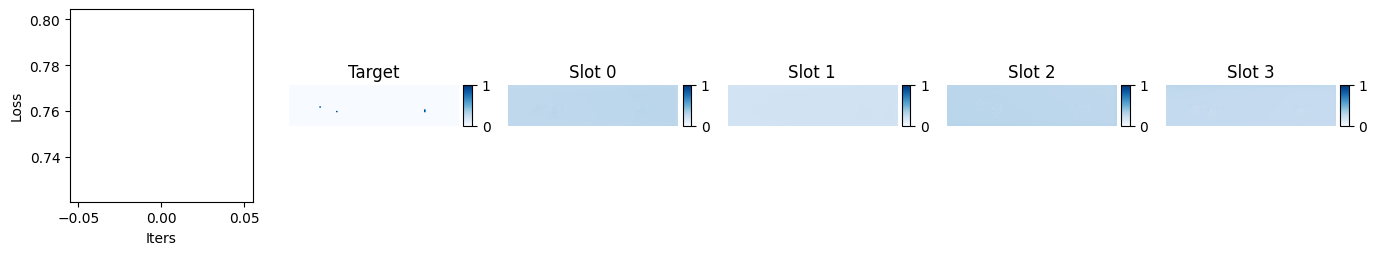

iter 50 , loss 0.7620132 , lr 2.999988434072206e-06


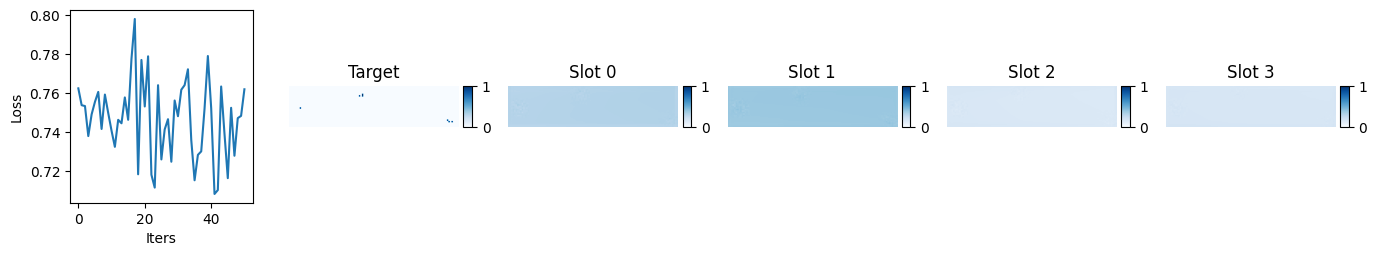

iter 100 , loss 0.7375597 , lr 5.999907472934369e-06


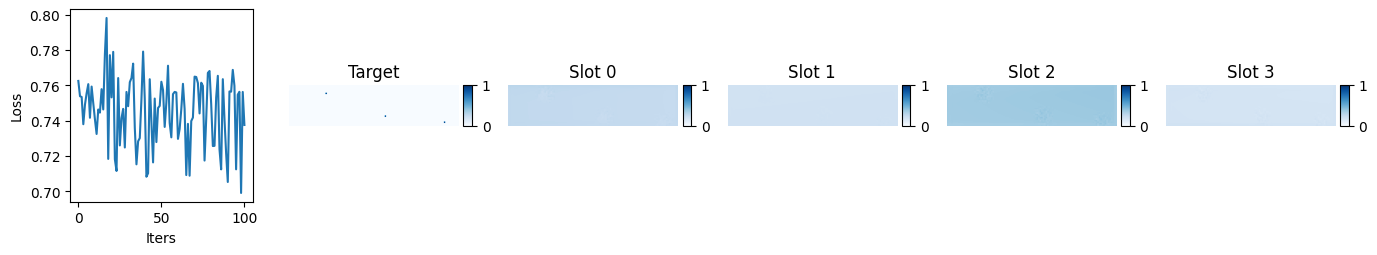

iter 150 , loss 0.7335304 , lr 8.999687723160046e-06


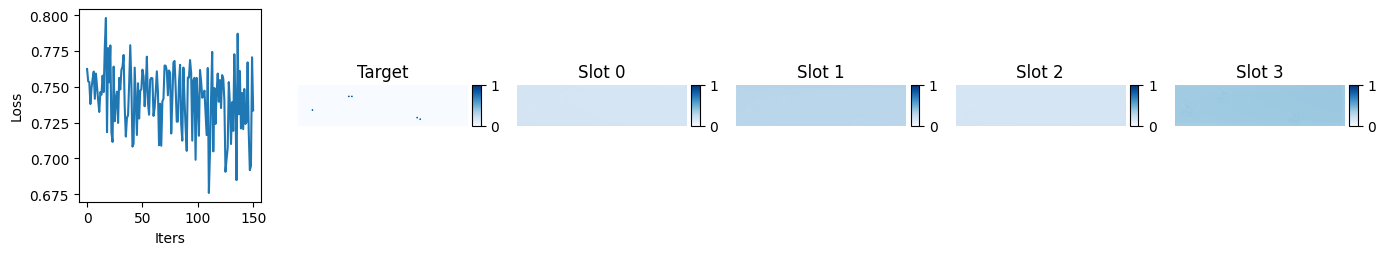

iter 200 , loss 0.6724782 , lr 1.1999259794889963e-05


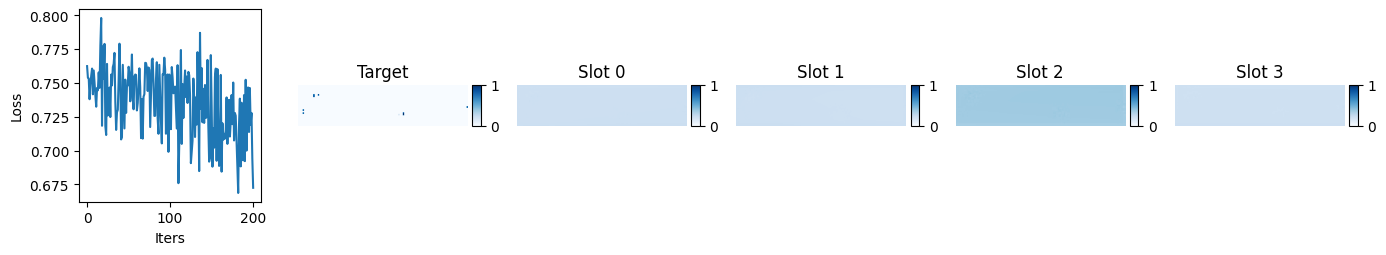

iter 250 , loss 0.6759763 , lr 1.4998554303615487e-05


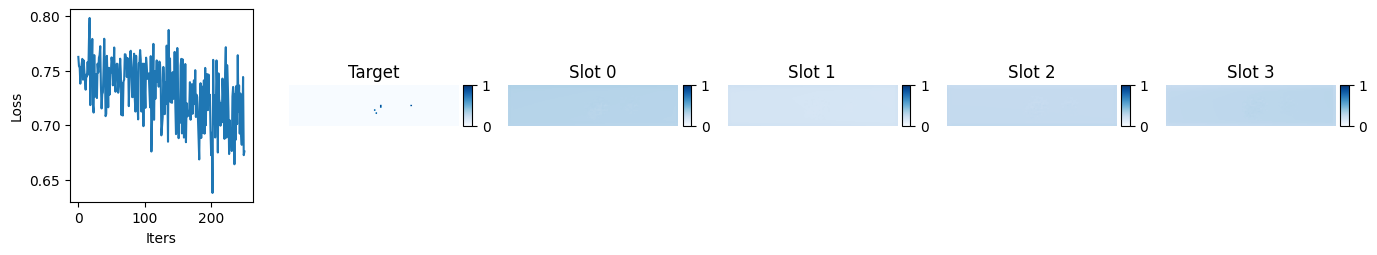

iter 300 , loss 0.67440736 , lr 1.7997501871962002e-05


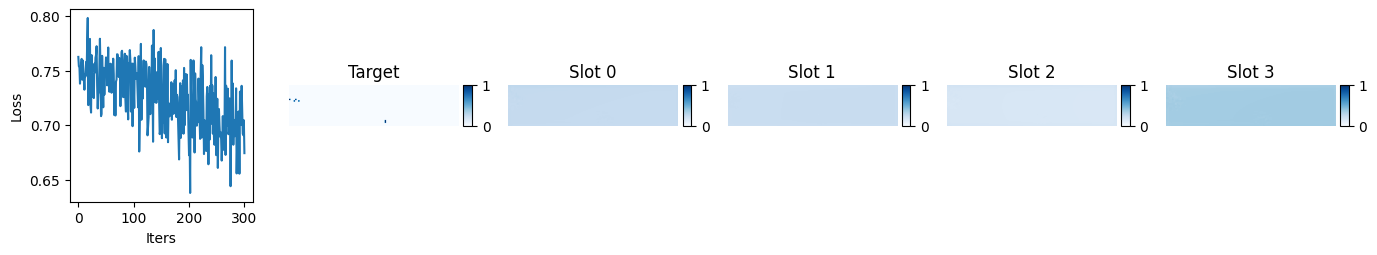

iter 350 , loss 0.63120145 , lr 2.0996033131472145e-05


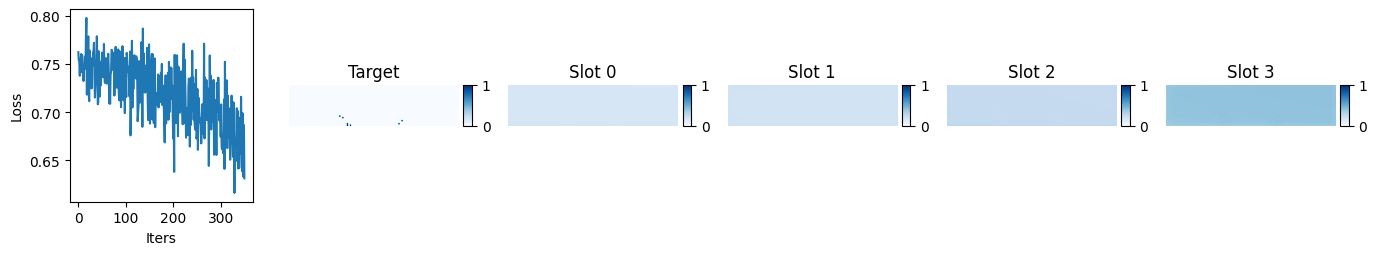

iter 400 , loss 0.63420725 , lr 2.3994078724388778e-05


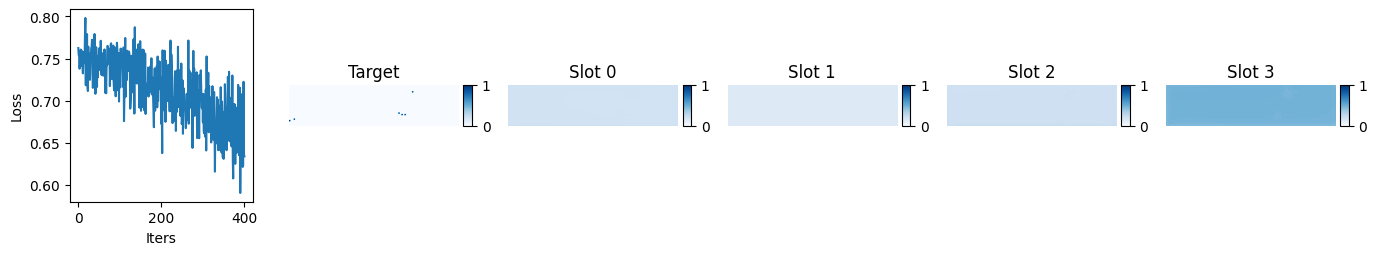

iter 450 , loss 0.5898746 , lr 2.6991569305437837e-05


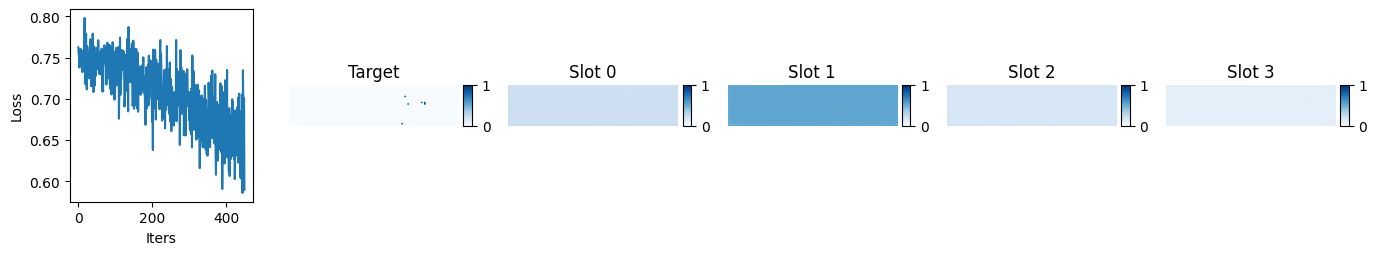

iter 500 , loss 0.63701665 , lr 2.9988435543610846e-05


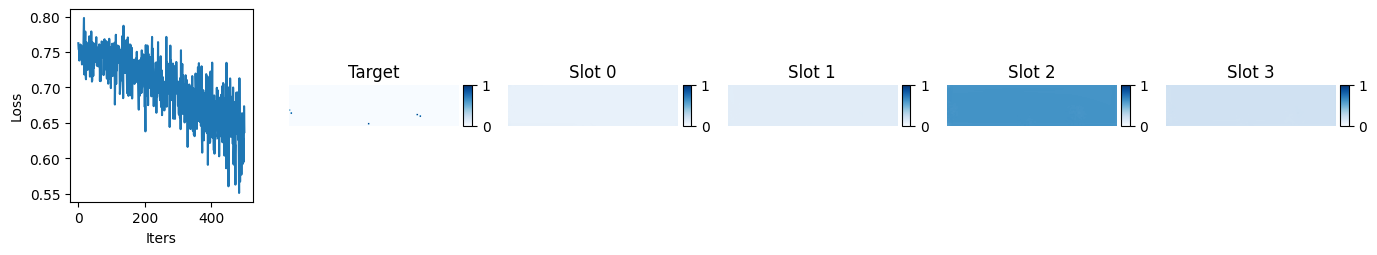

iter 550 , loss 0.6455474 , lr 3.298460812394707e-05


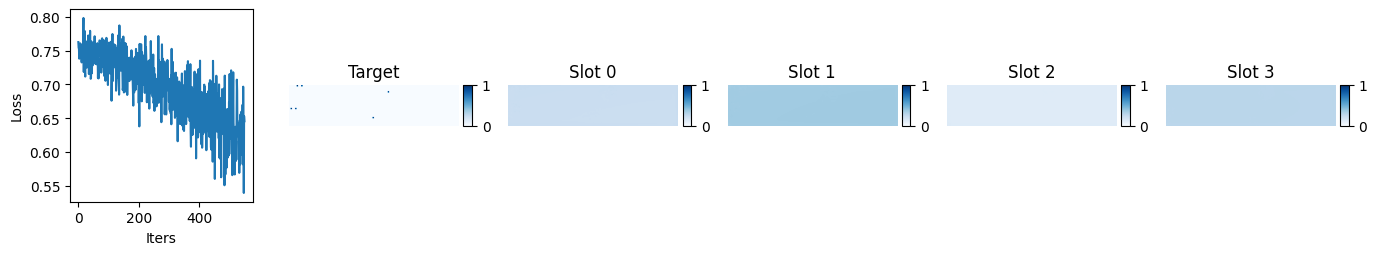

iter 600 , loss 0.67838293 , lr 3.5980017749315456e-05


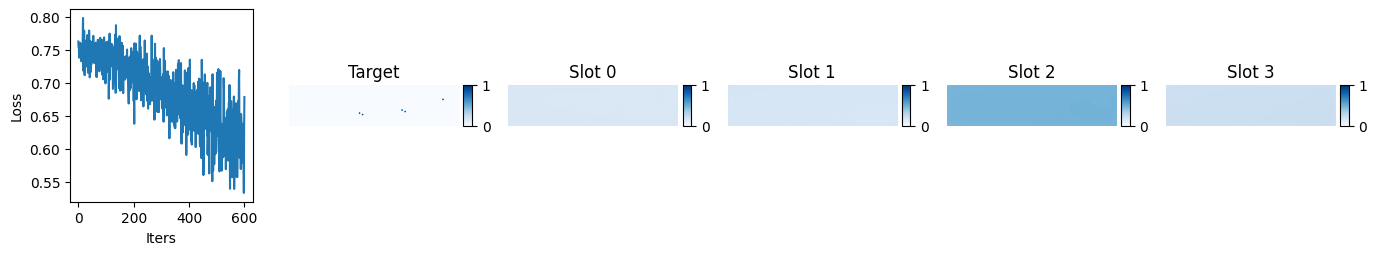

iter 650 , loss 0.57747835 , lr 3.897459514219611e-05


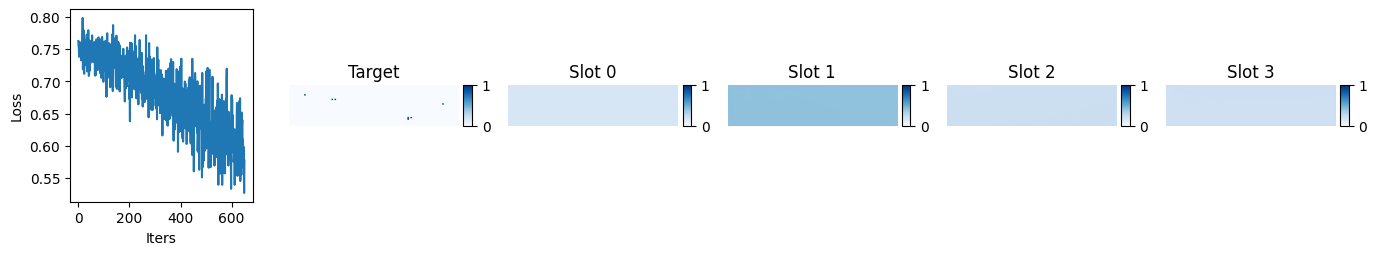

iter 700 , loss 0.5378018 , lr 4.19682710464613e-05


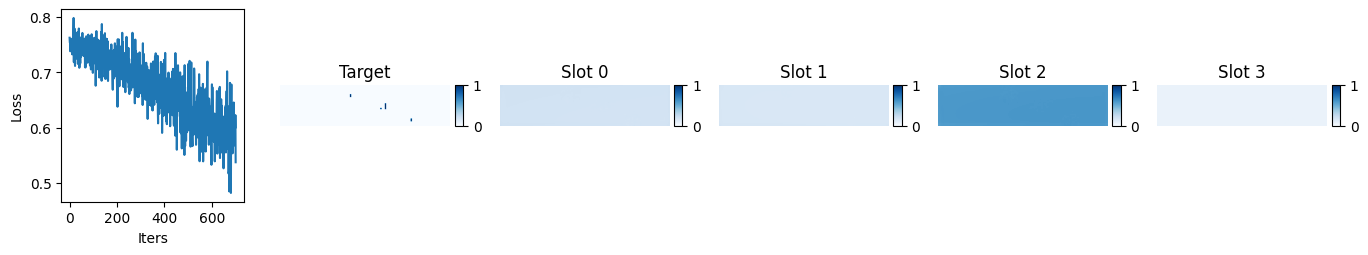

iter 750 , loss 0.5621345 , lr 4.4960976229156103e-05


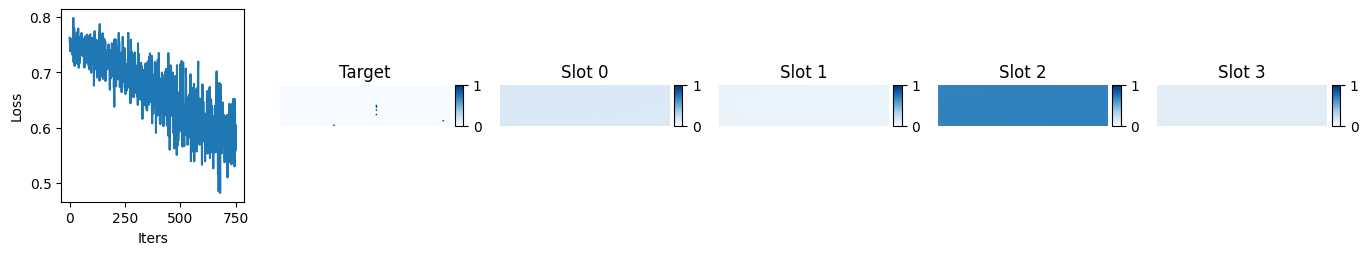

iter 800 , loss 0.4237922 , lr 4.7952641482278515e-05


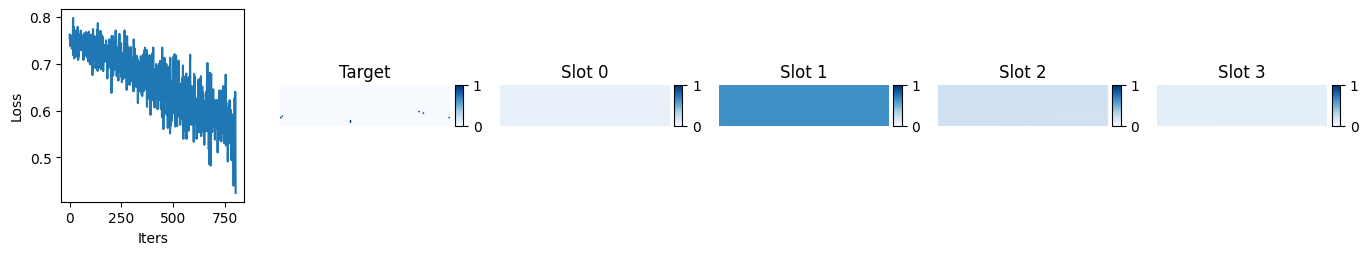

iter 850 , loss 0.6012976 , lr 5.094319762455895e-05


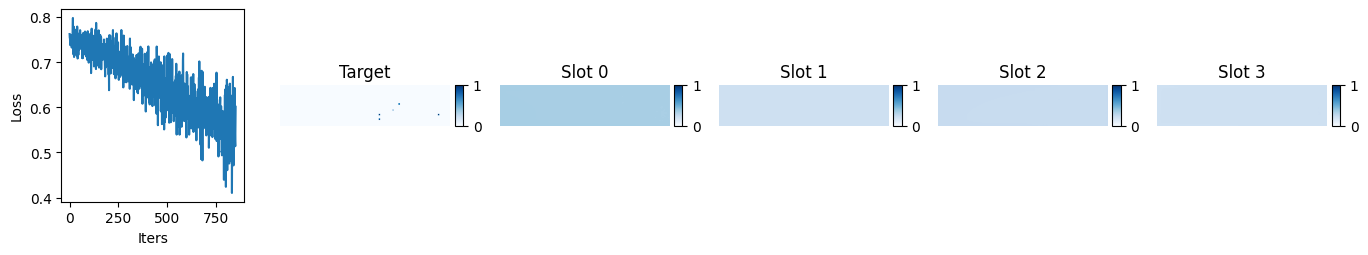

iter 900 , loss 0.5991539 , lr 5.393257550323929e-05


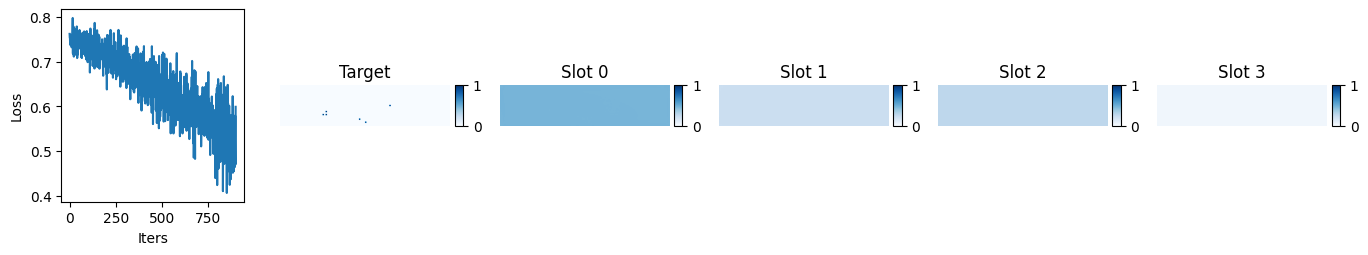

iter 950 , loss 0.5566819 , lr 5.692070599585119e-05


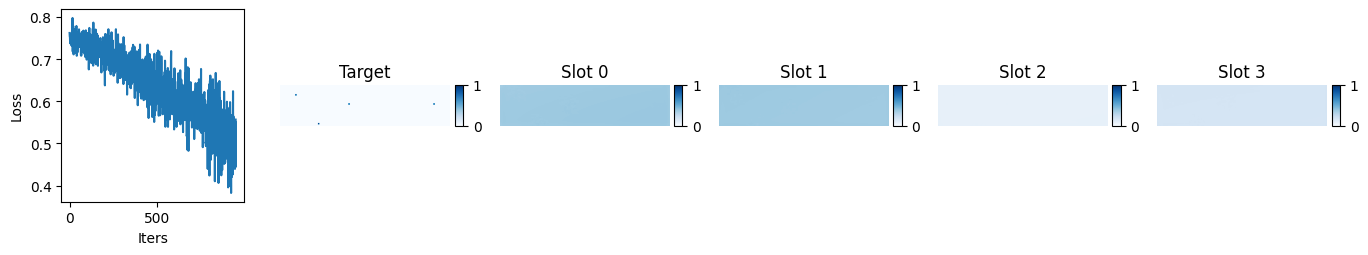

iter 1000 , loss 0.51282126 , lr 5.9907520011993834e-05


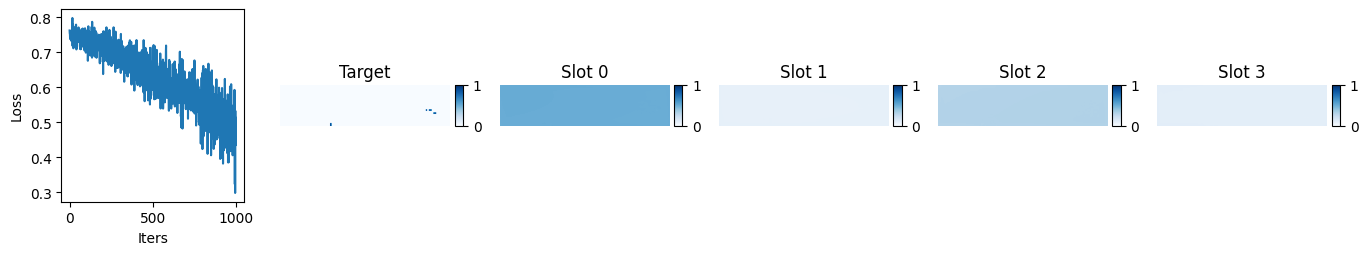

iter 1050 , loss 0.45839146 , lr 6.289294849511095e-05


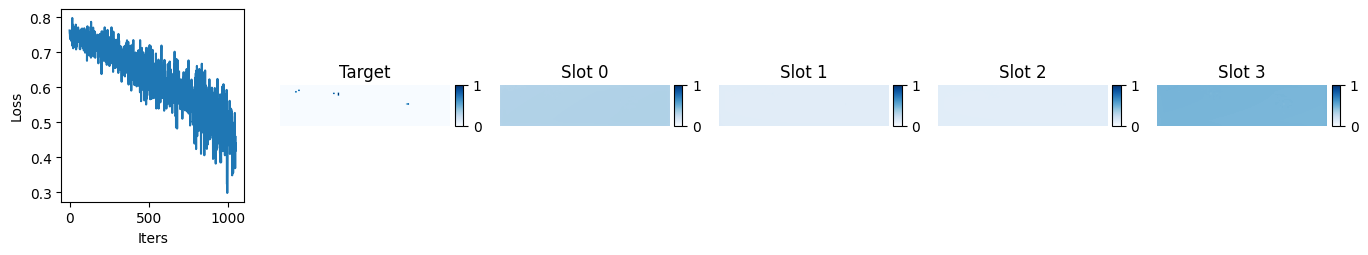

iter 1100 , loss 0.42101616 , lr 6.587692242426705e-05


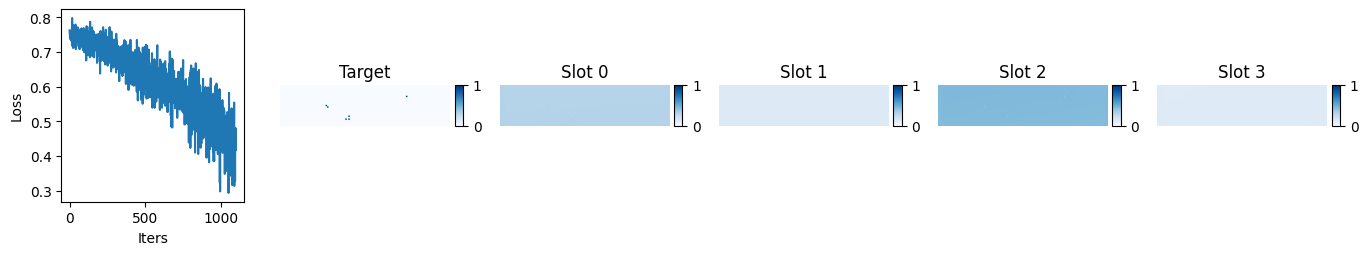

iter 1150 , loss 0.3819604 , lr 6.885937281592306e-05


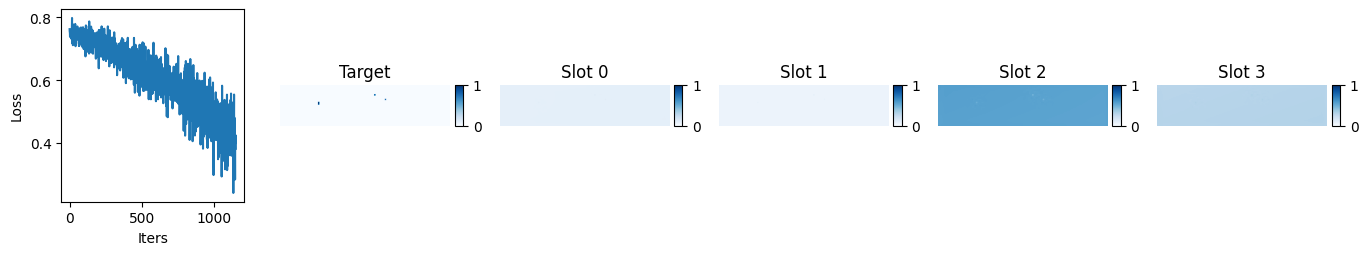

iter 1200 , loss 0.3431986 , lr 7.184023072571087e-05


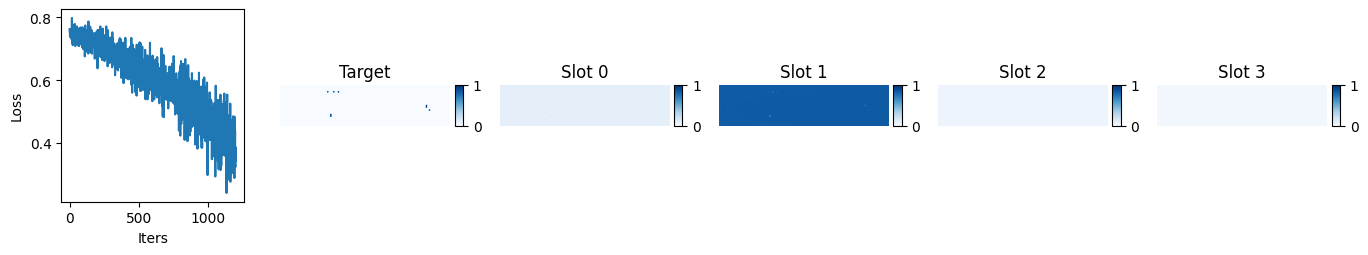

iter 1250 , loss 0.40962693 , lr 7.481942725020738e-05


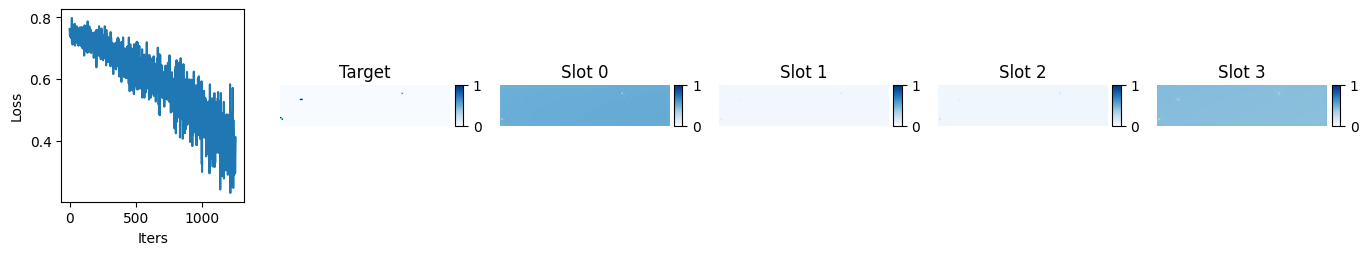

iter 1300 , loss 0.38168567 , lr 7.779689352870732e-05


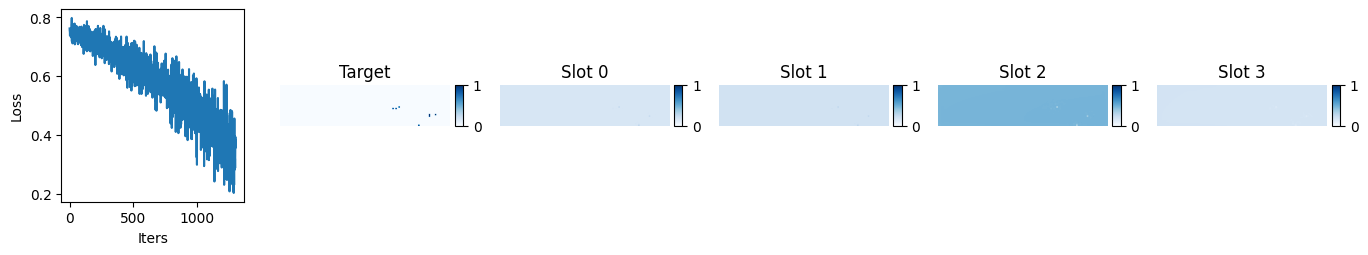

iter 1350 , loss 0.26825058 , lr 8.077256074499546e-05


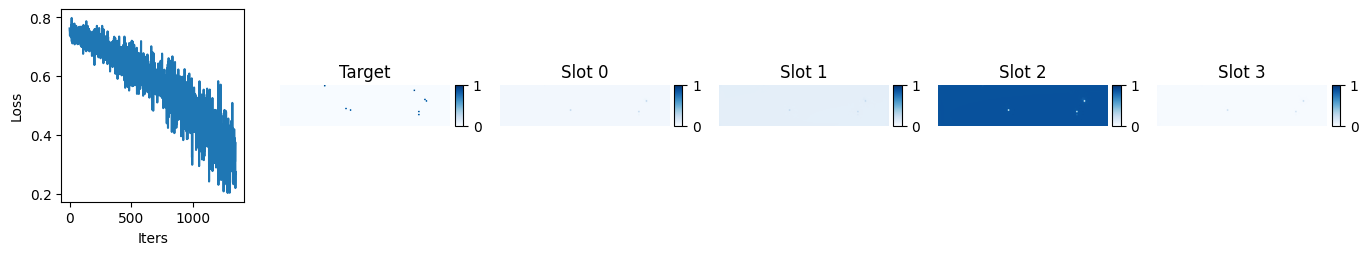

iter 1400 , loss 0.36484233 , lr 8.374636012911756e-05


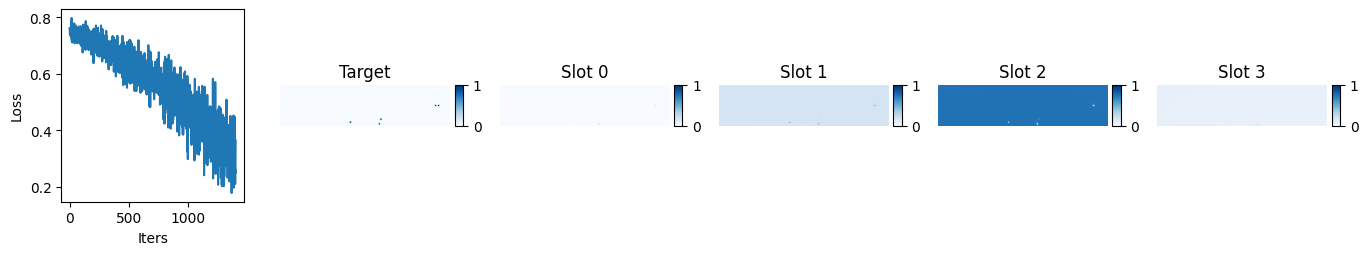

iter 1450 , loss 0.30834344 , lr 8.671822295915055e-05


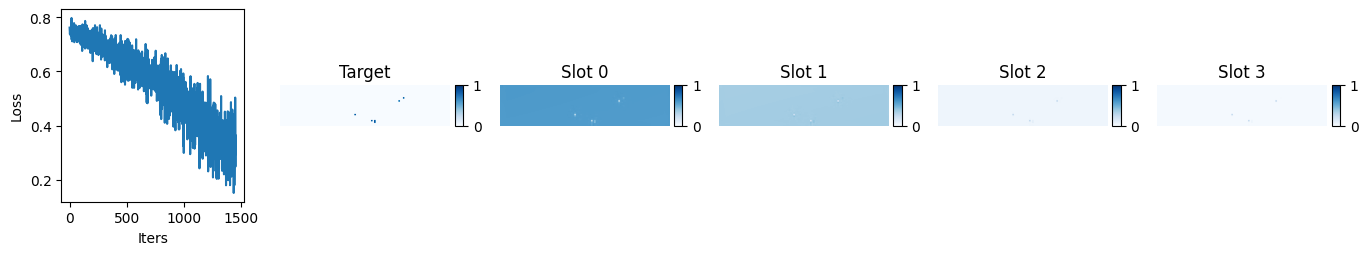

iter 1500 , loss 0.3884992 , lr 8.968808056297168e-05


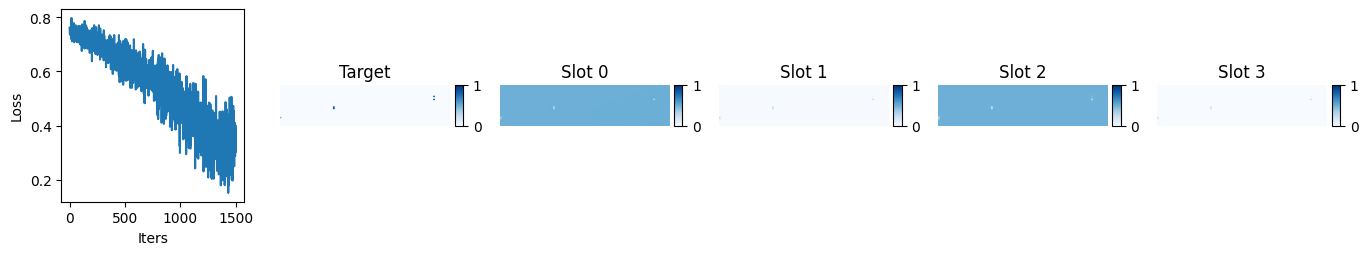

iter 1550 , loss 0.22895502 , lr 9.26558643200263e-05


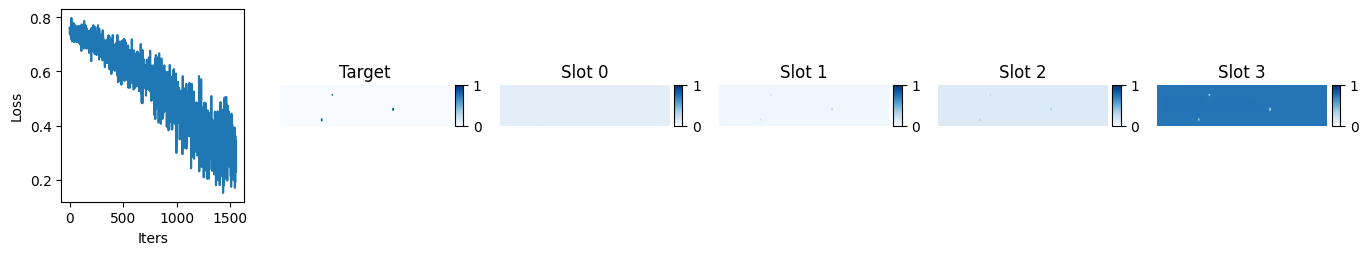

iter 1600 , loss 0.38659543 , lr 9.562150566309494e-05


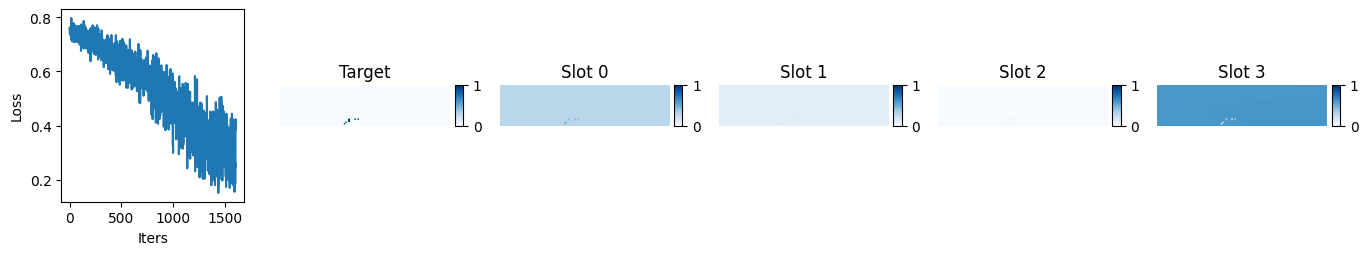

iter 1650 , loss 0.35530677 , lr 9.858493608005883e-05


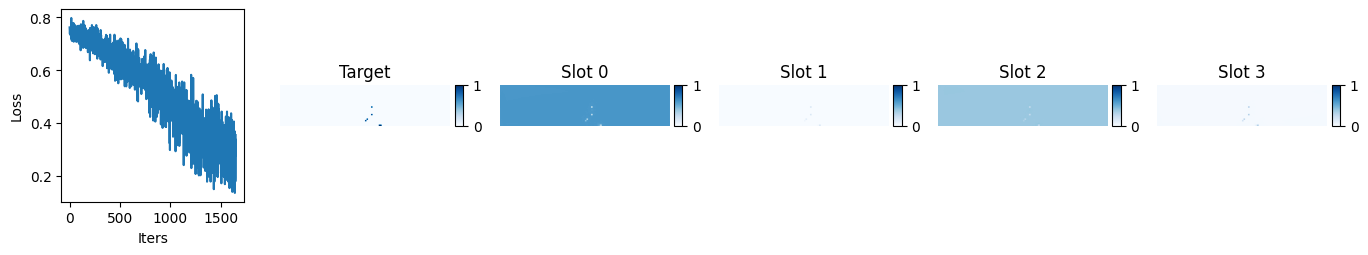

iter 1700 , loss 0.24051404 , lr 0.00010154608711566472


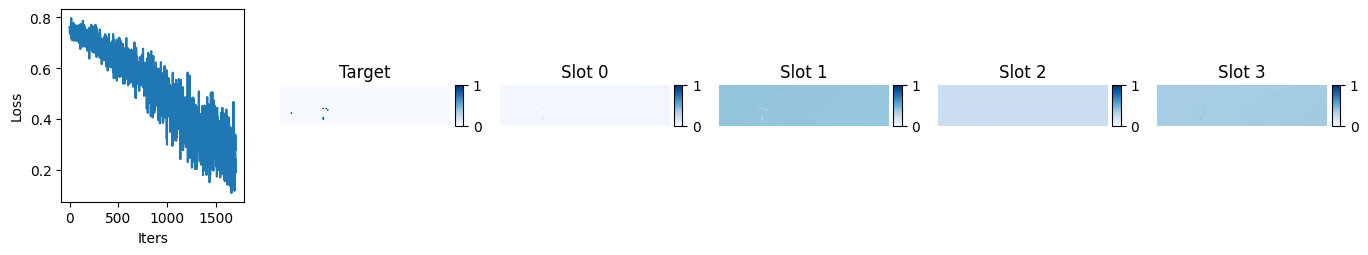

iter 1750 , loss 0.20108941 , lr 0.0001045048903732878


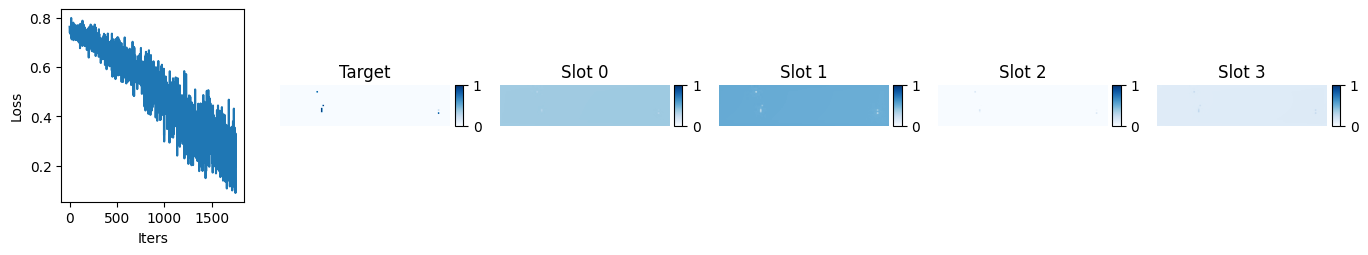

iter 1800 , loss 0.19774657 , lr 0.00010746127751669408


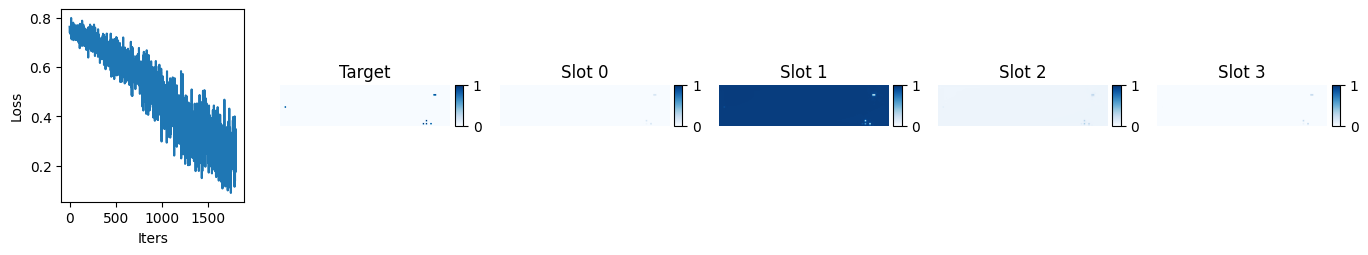

iter 1850 , loss 0.17865814 , lr 0.000110415180271801


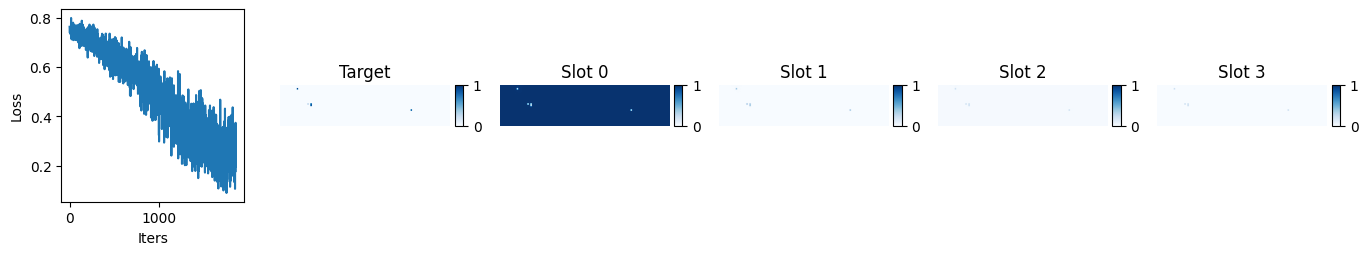

iter 1900 , loss 0.28025836 , lr 0.00011336653042843675


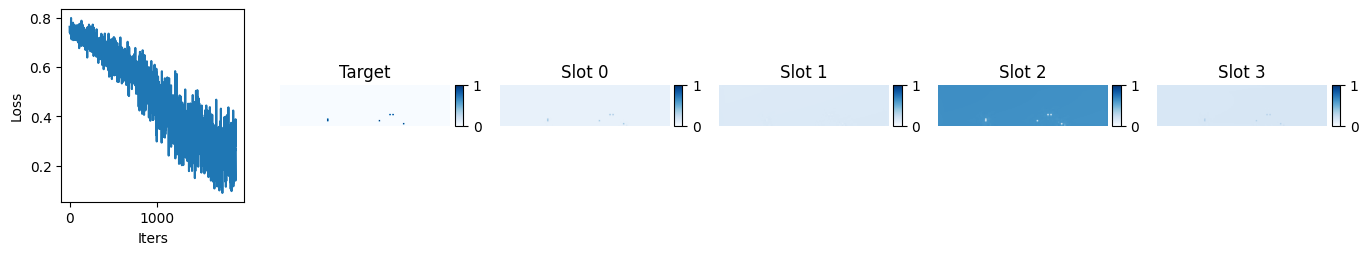

iter 1950 , loss 0.26756987 , lr 0.00011631525984209833


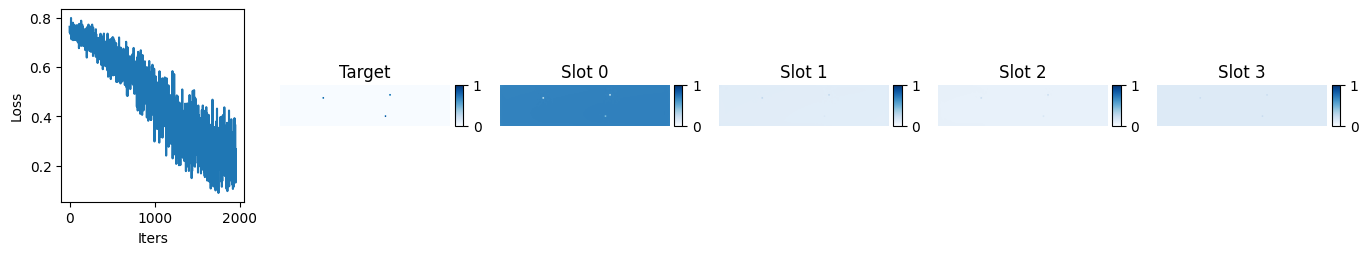

iter 2000 , loss 0.21927086 , lr 0.00011926130043570826


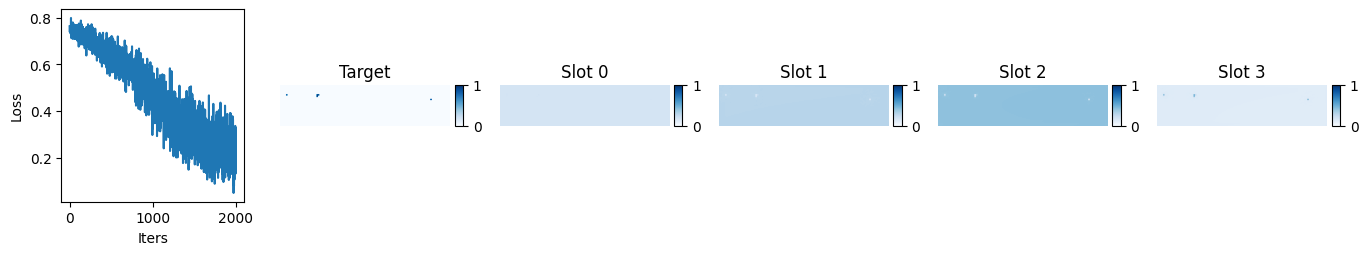

iter 2050 , loss 0.16018139 , lr 0.00012220458420136946


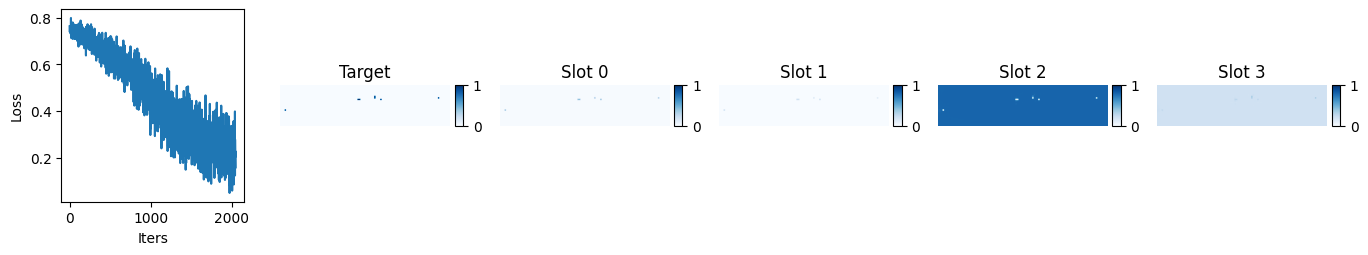

iter 2100 , loss 0.16973904 , lr 0.0001251450432021192


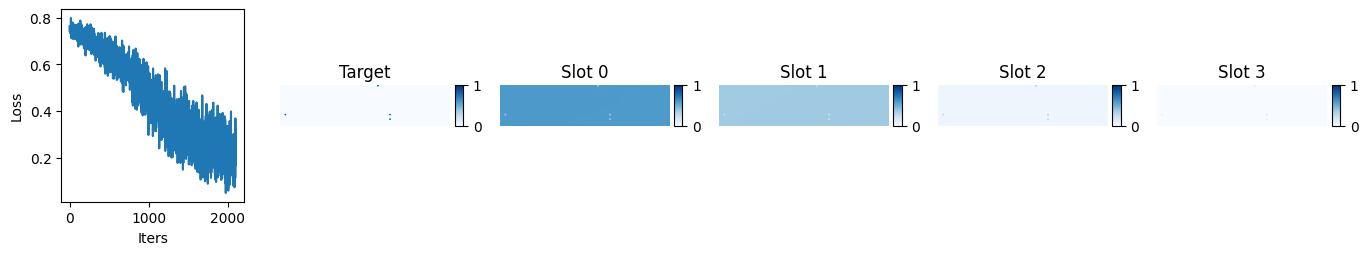

iter 2150 , loss 0.22545241 , lr 0.00012808260957368096


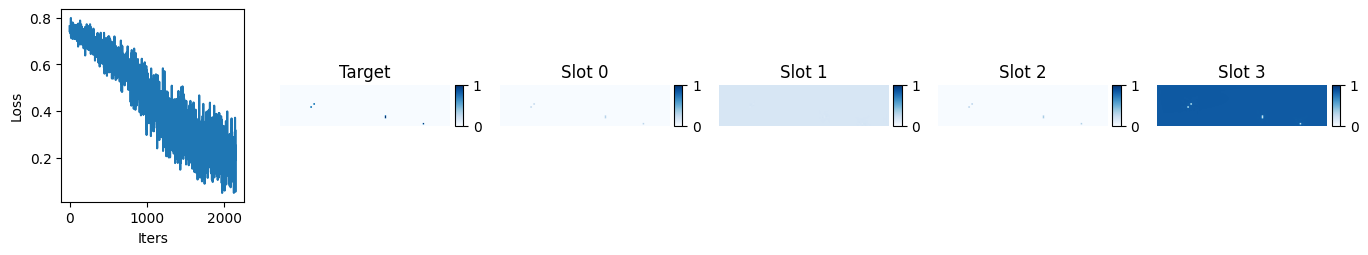

iter 2200 , loss 0.16673411 , lr 0.00013101721552621508


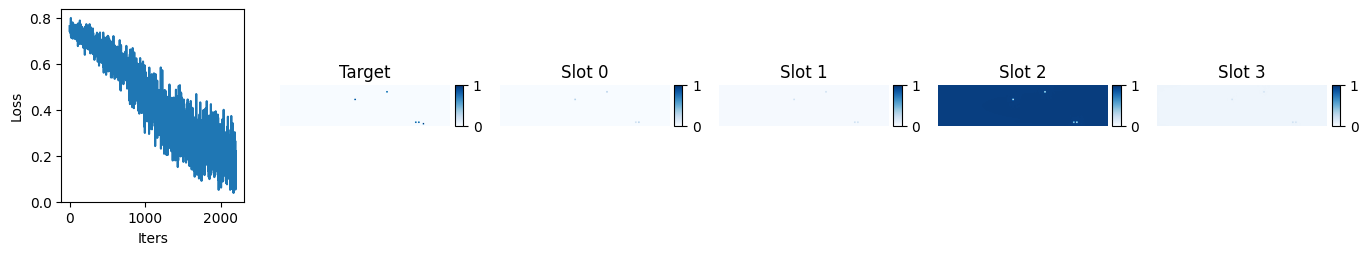

iter 2250 , loss 0.19765496 , lr 0.00013394879334606766


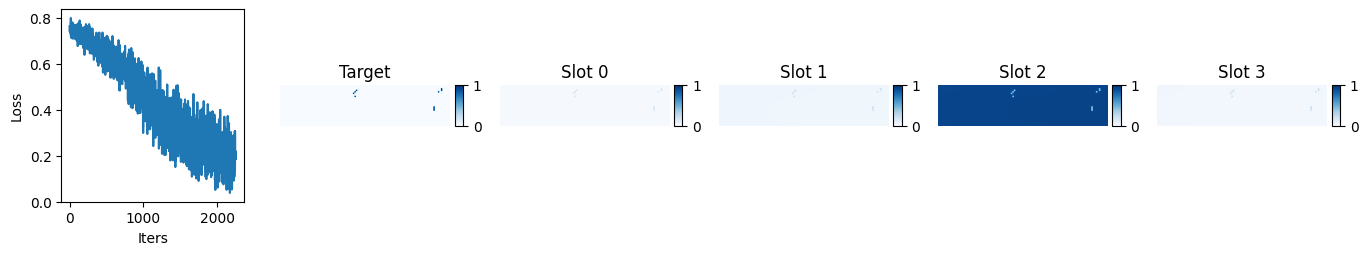

iter 2300 , loss 0.17921674 , lr 0.00013687727539751795


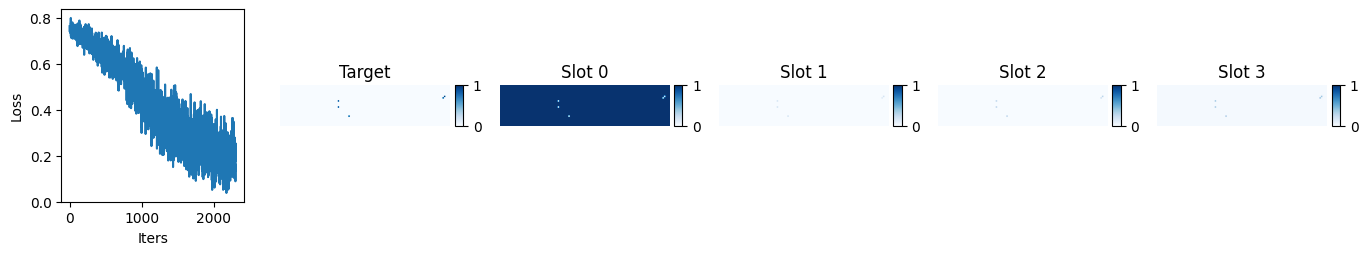

iter 2350 , loss 0.24803545 , lr 0.0001398025941245238


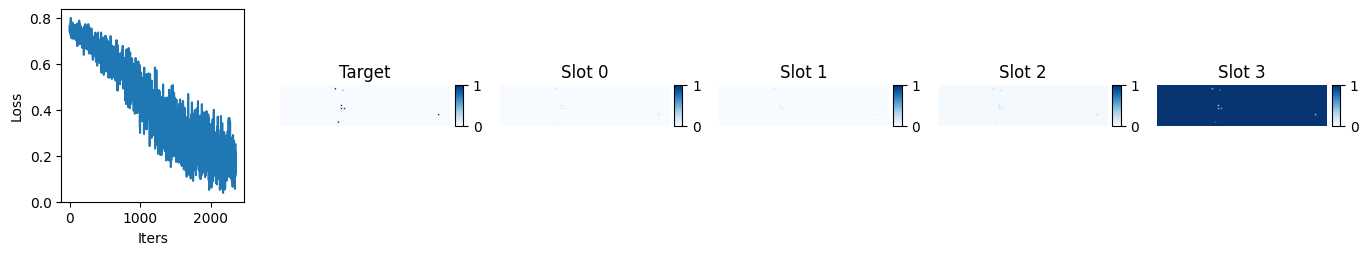

iter 2400 , loss 0.17441875 , lr 0.00014272468205246558


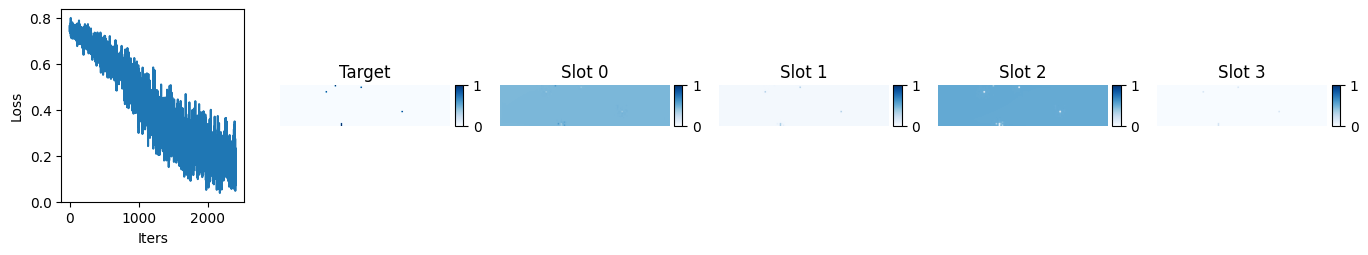

iter 2450 , loss 0.18676293 , lr 0.0001456434717898884


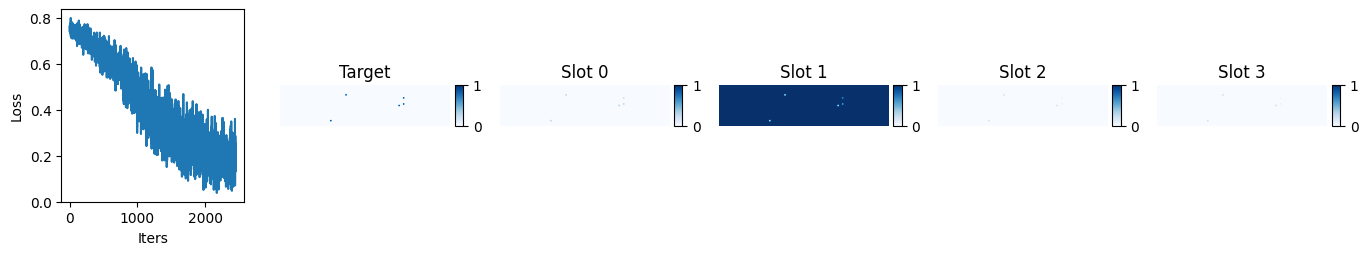

iter 2500 , loss 0.056941222 , lr 0.00014855889603024227


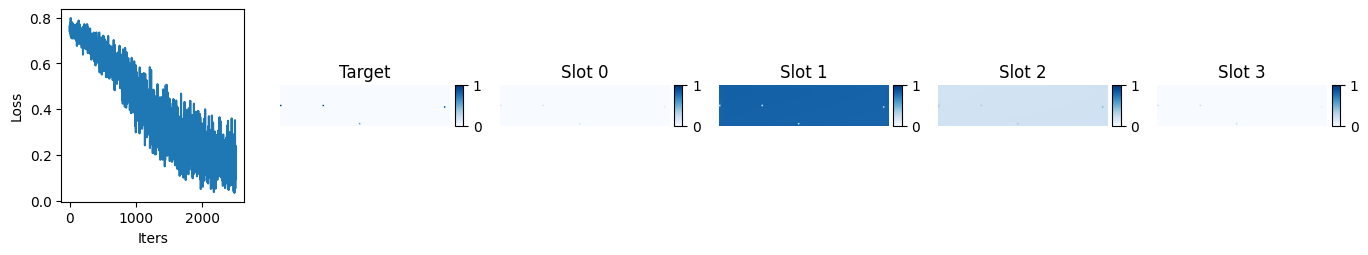

iter 2550 , loss 0.07458944 , lr 0.00015147088755362083


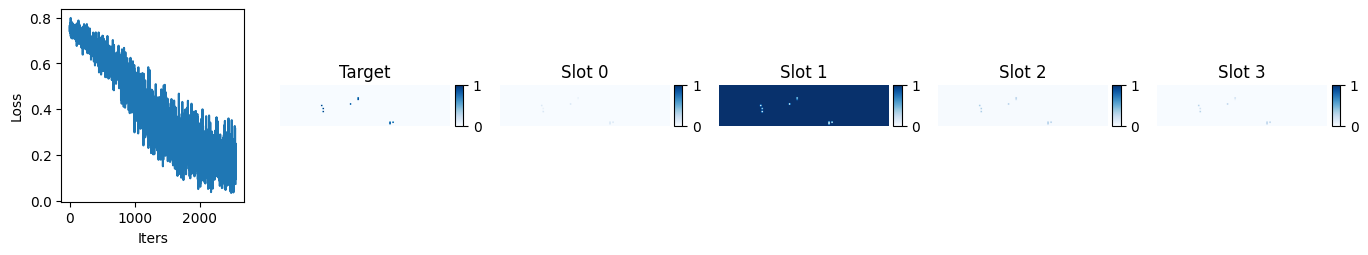

iter 2600 , loss 0.19736321 , lr 0.0001543793792284977


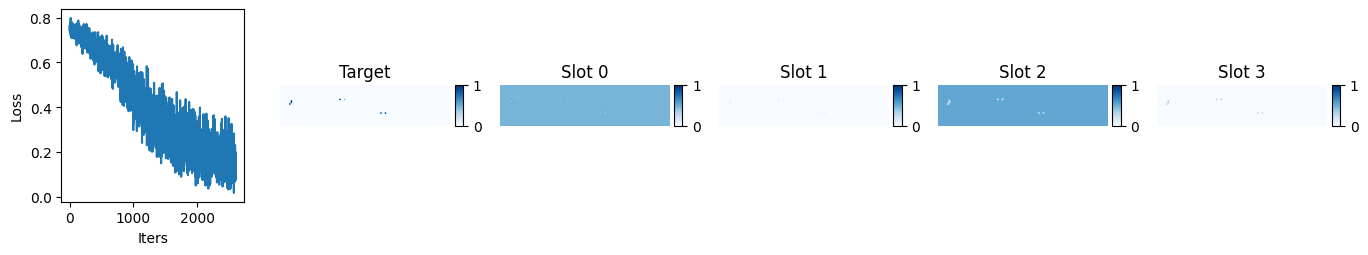

iter 2650 , loss 0.06989489 , lr 0.00015728430401346143


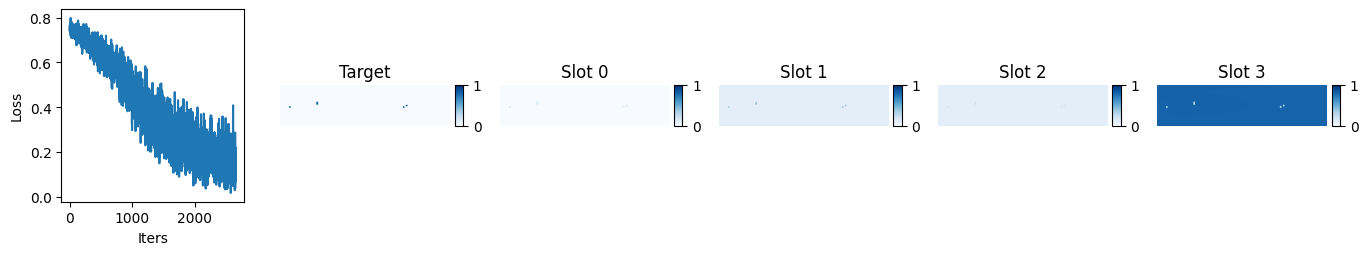

iter 2700 , loss 0.12620074 , lr 0.00016018559495894805


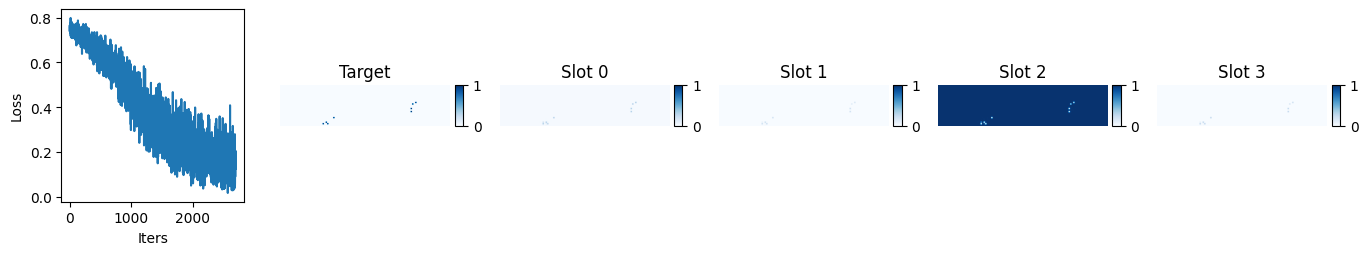

iter 2750 , loss 0.17968228 , lr 0.00016308318520897198


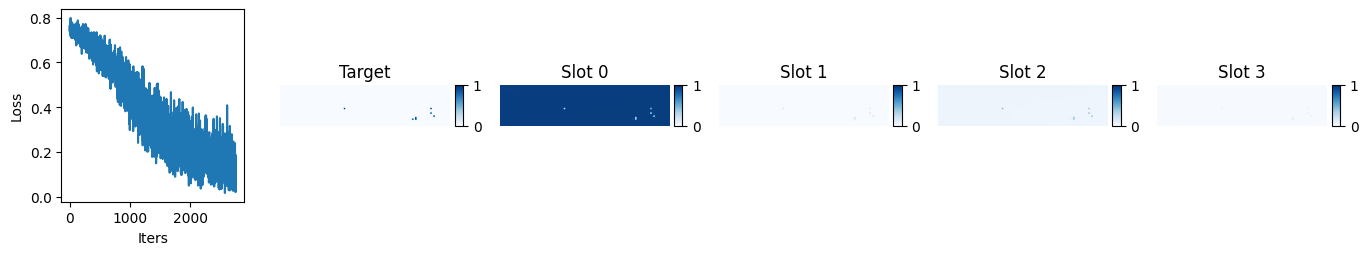

iter 2800 , loss 0.19740216 , lr 0.0001659770080028548


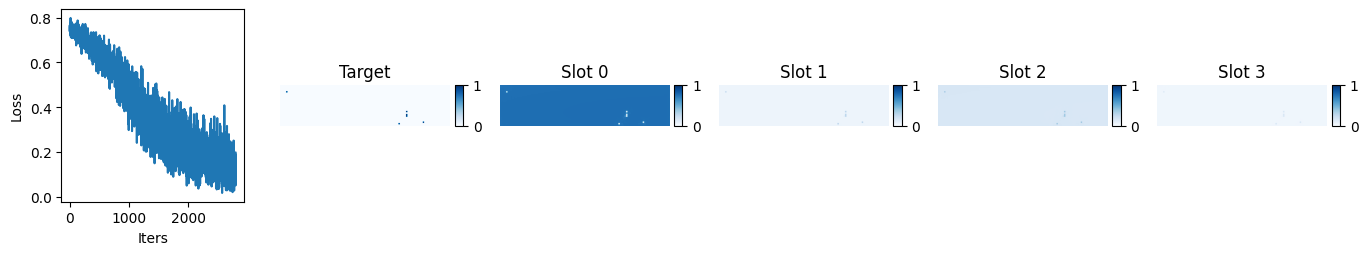

iter 2850 , loss 0.037062444 , lr 0.00016886699667695182


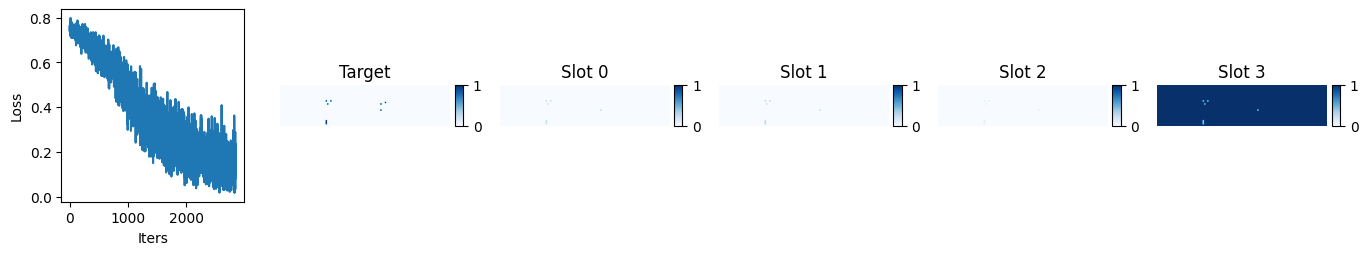

iter 2900 , loss 0.09756085 , lr 0.00017175308466637688


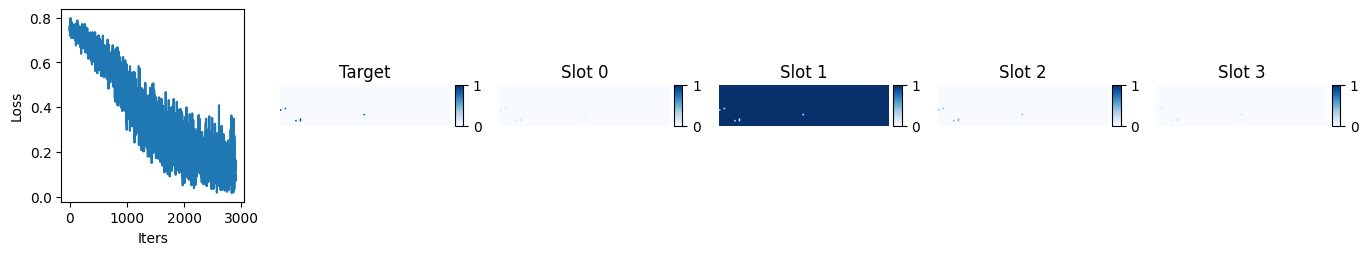

iter 2950 , loss 0.12710738 , lr 0.00017463520550672462


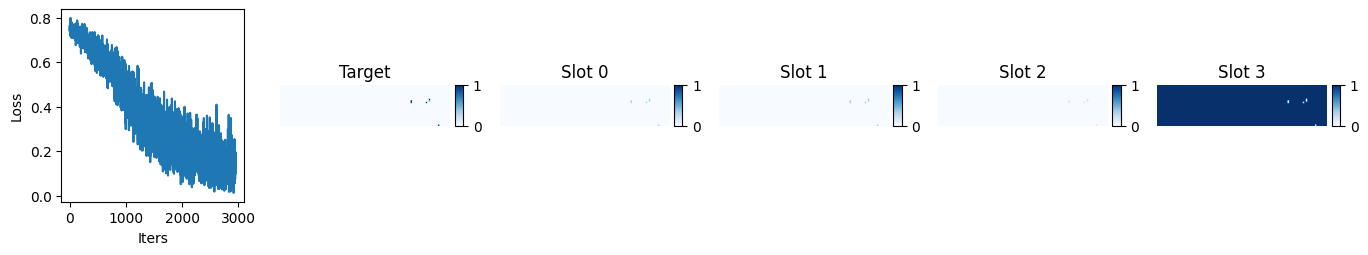

iter 3000 , loss 0.1115267 , lr 0.00017751329283579087


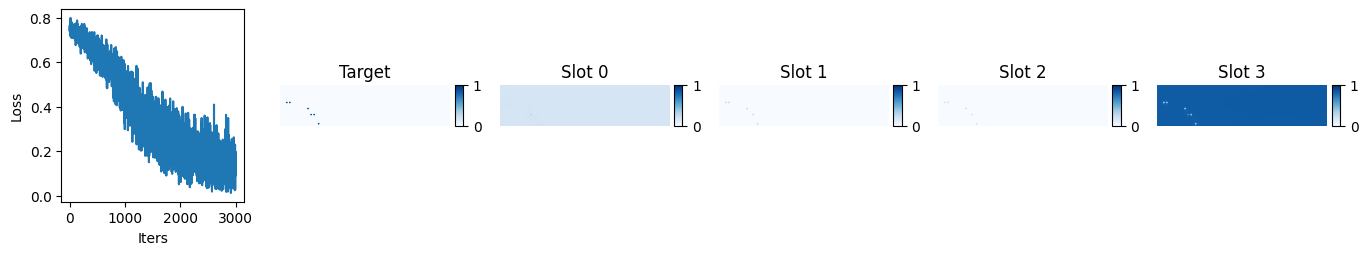

iter 3050 , loss 0.061952274 , lr 0.00018038728039529076


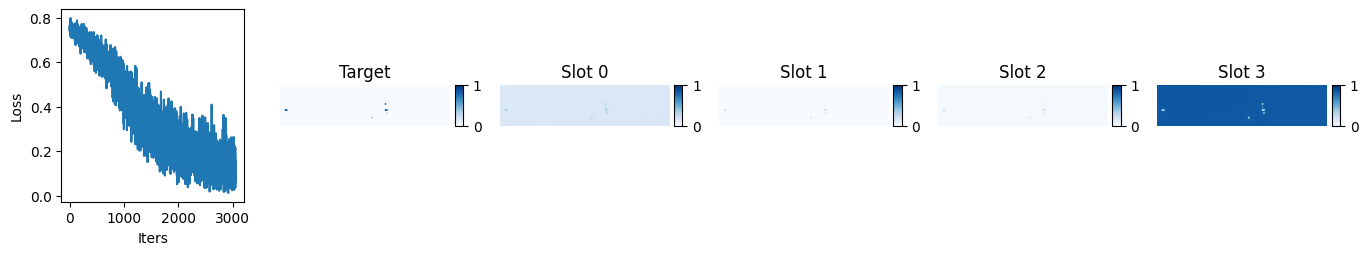

iter 3100 , loss 0.09741039 , lr 0.00018325710203257443


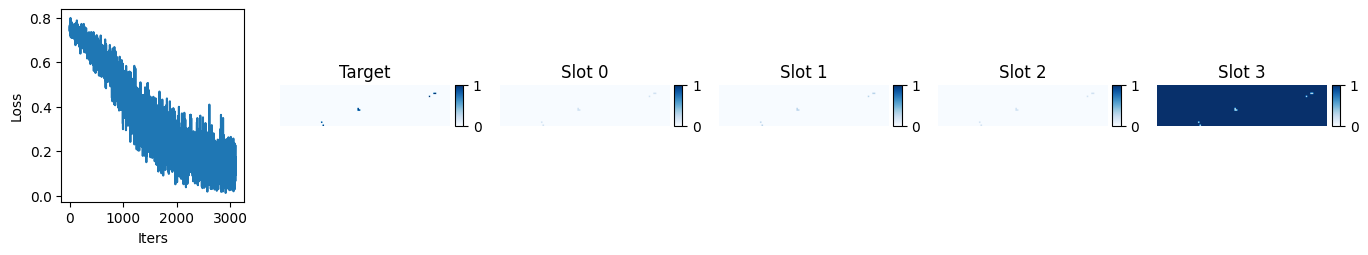

iter 3150 , loss 0.09898226 , lr 0.0001861226917023408


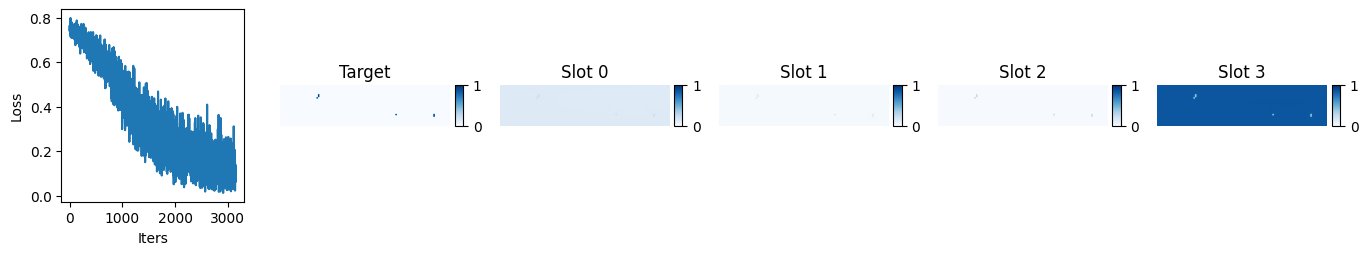

iter 3200 , loss 0.13569222 , lr 0.00018898398346834858


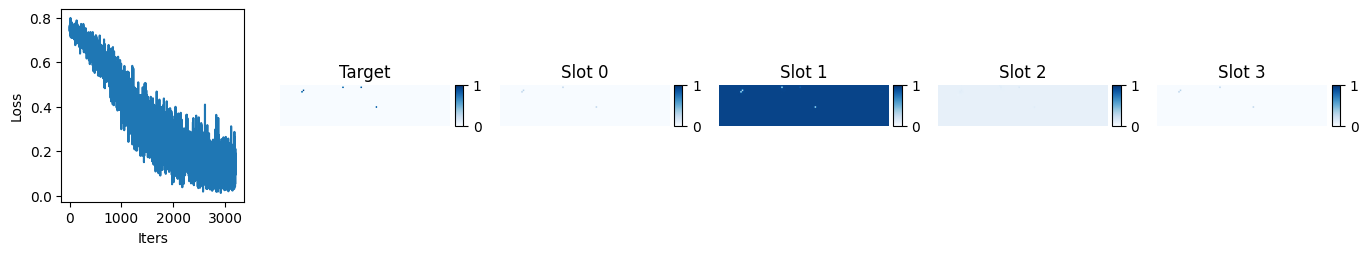

iter 3250 , loss 0.102191135 , lr 0.00019184091150512532


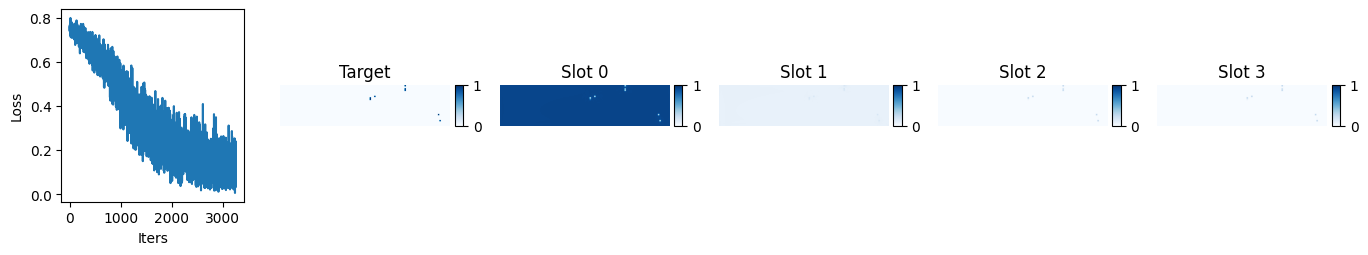

iter 3300 , loss 0.1038545 , lr 0.0001946934100996738


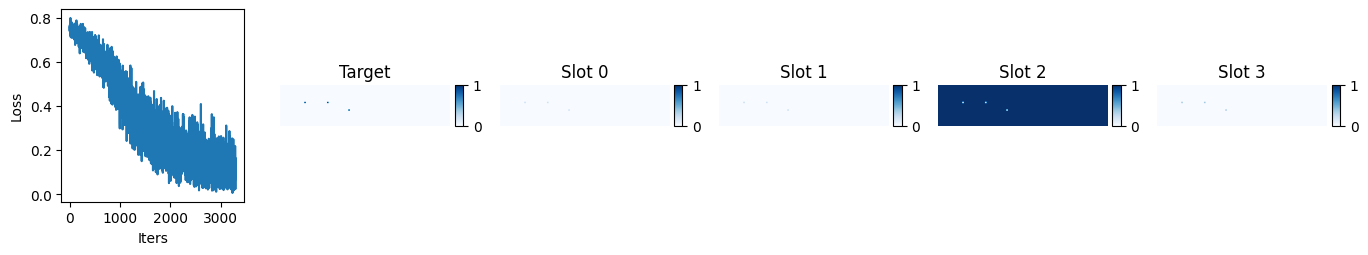

iter 3350 , loss 0.096657515 , lr 0.0001975414136531762


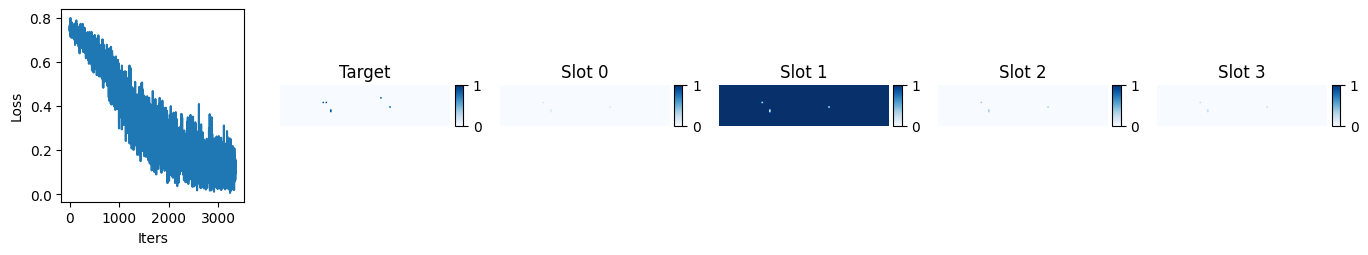

iter 3400 , loss 0.054938238 , lr 0.00020038485668269542


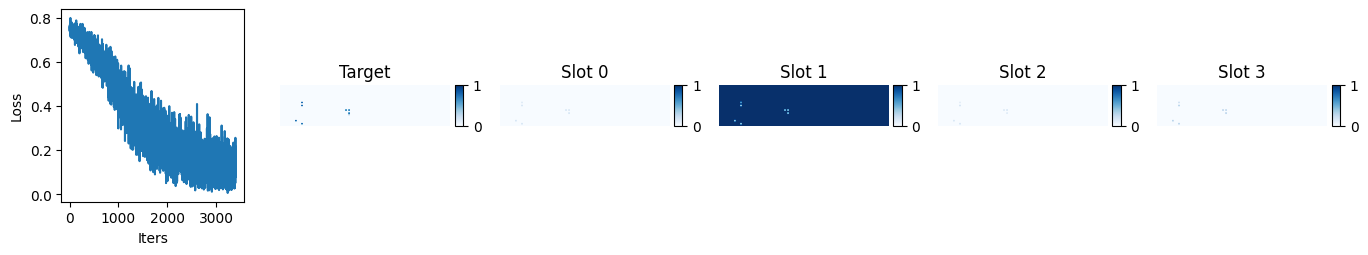

iter 3450 , loss 0.092173934 , lr 0.00020322367382287444


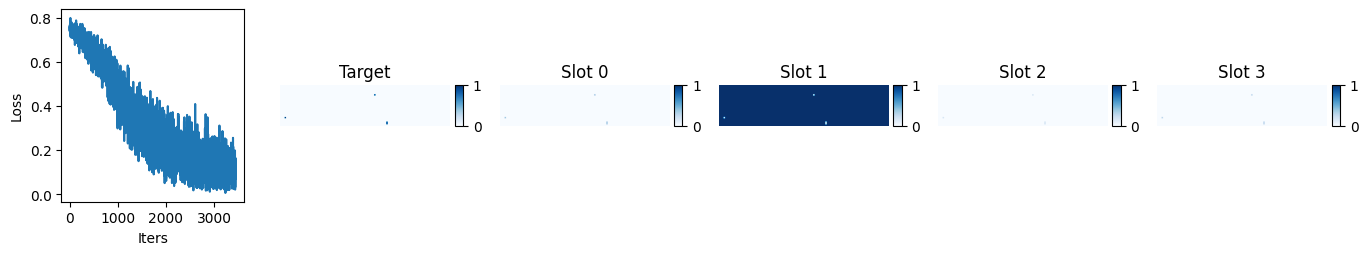

iter 3500 , loss 0.02622702 , lr 0.0002060577998276329


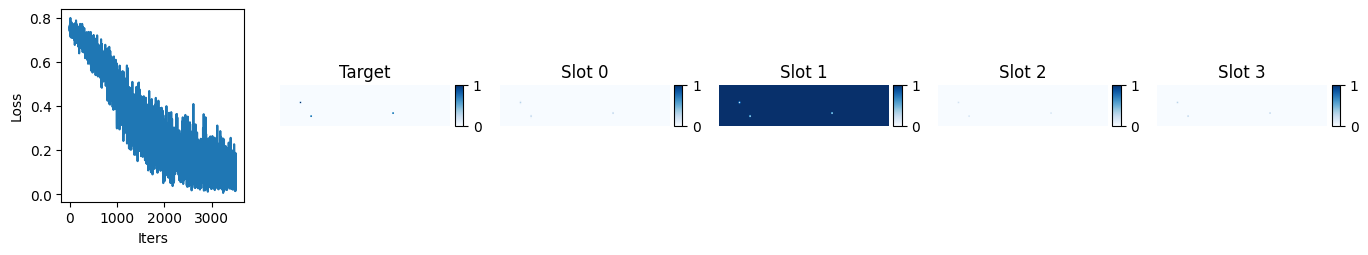

iter 3550 , loss 0.10733676 , lr 0.0002088871695718608


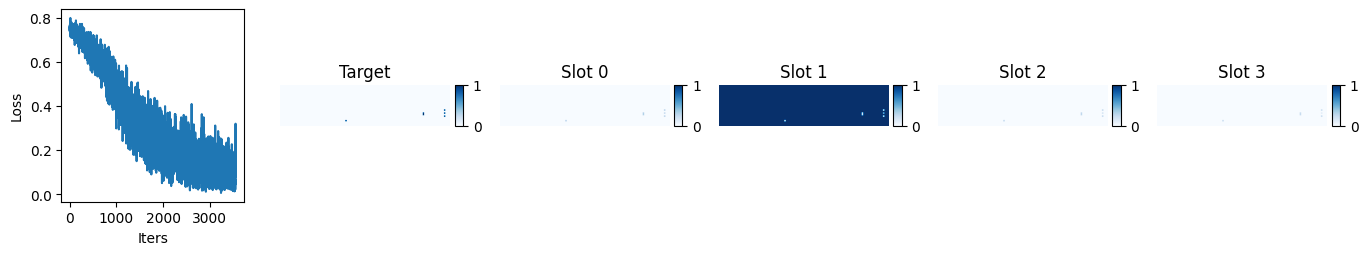

iter 3600 , loss 0.150324 , lr 0.00021171171805310982


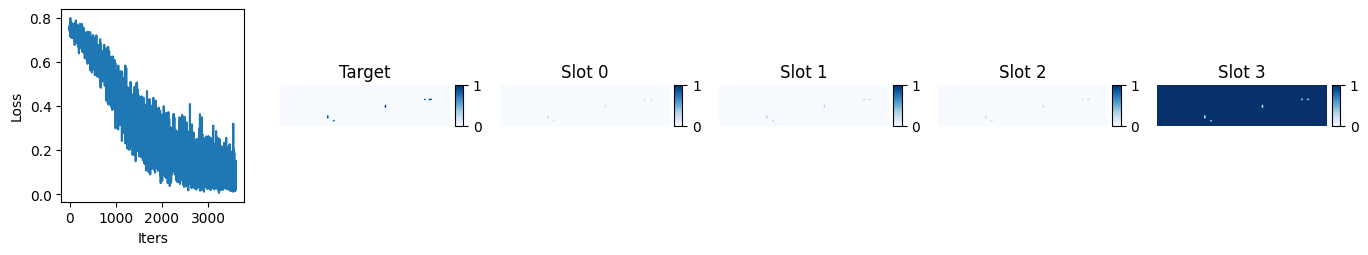

iter 3650 , loss 0.053316694 , lr 0.00021453138039328242


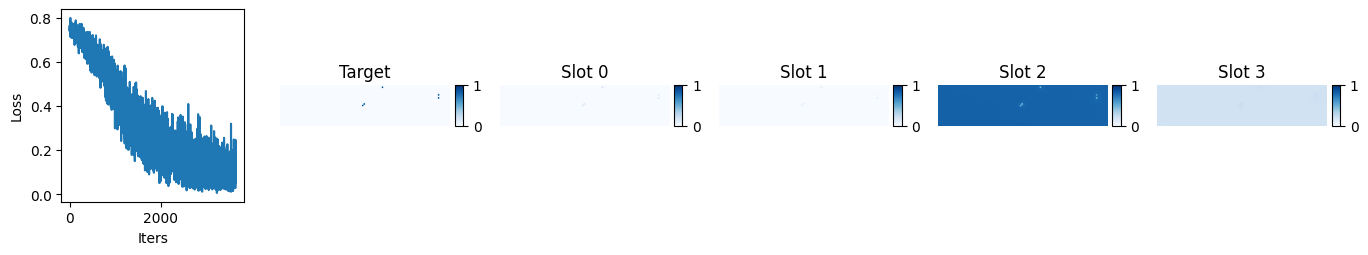

iter 3700 , loss 0.024975099 , lr 0.0002173460918403174


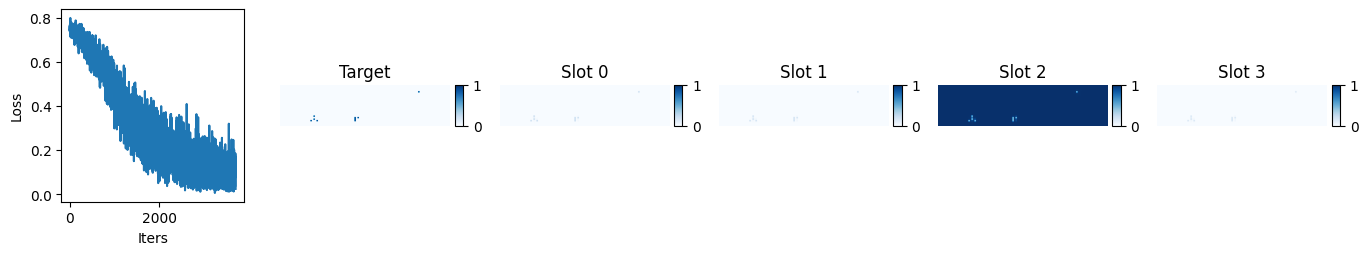

iter 3750 , loss 0.027167203 , lr 0.00022015578776987346


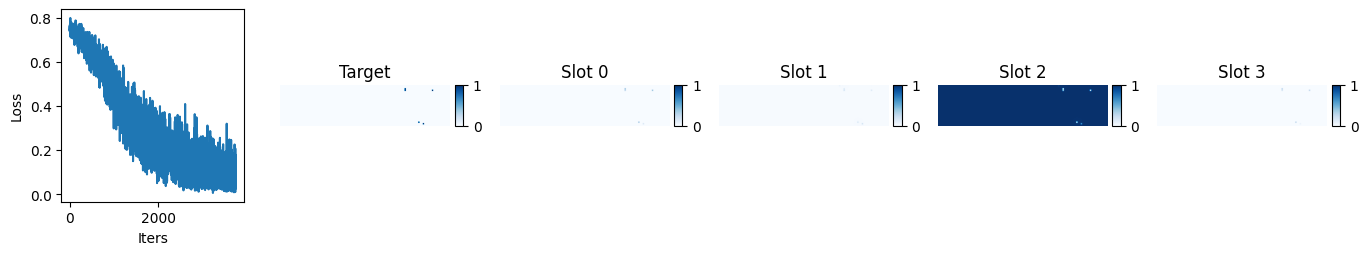

iter 3800 , loss 0.03715825 , lr 0.0002229604036870096


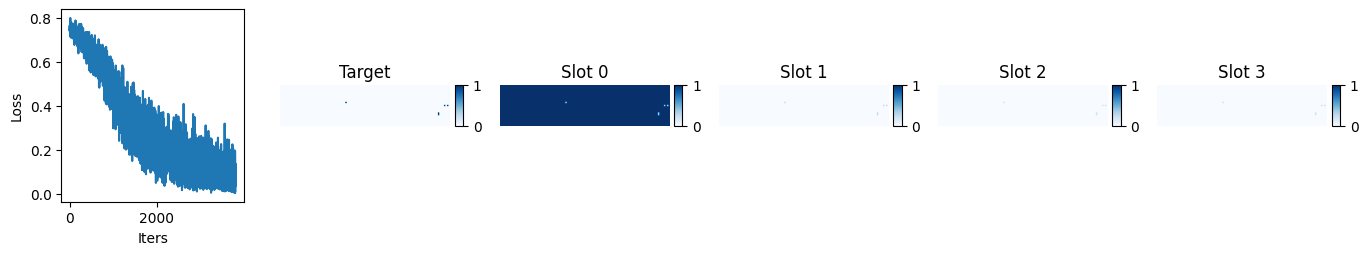

iter 3850 , loss 0.040727895 , lr 0.00022575987522786283


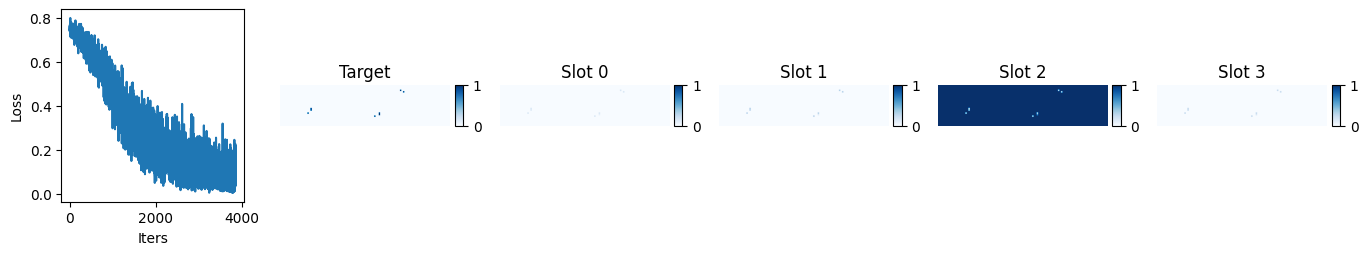

iter 3900 , loss 0.1372559 , lr 0.0002285541381613231


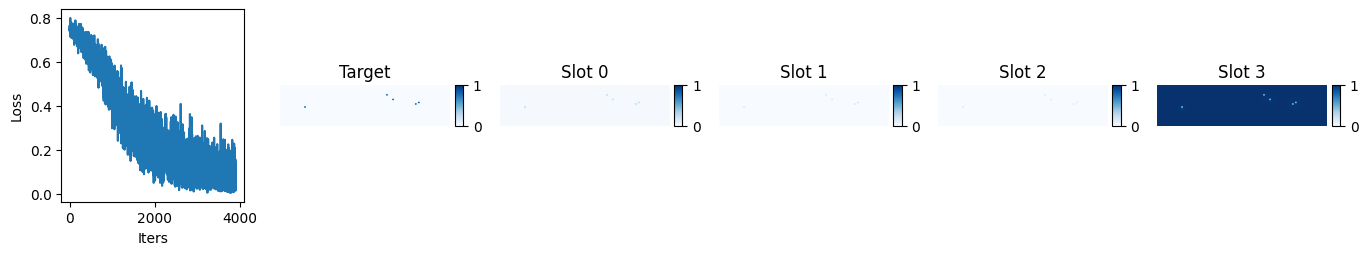

iter 3950 , loss 0.106273055 , lr 0.00023134312839070533


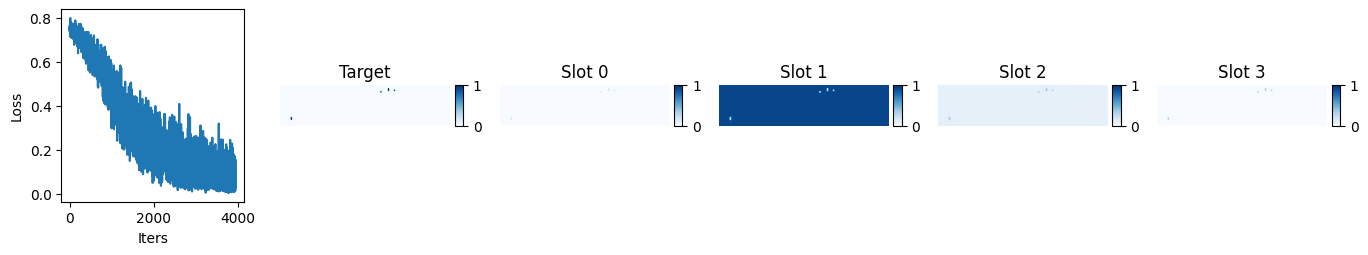

iter 4000 , loss 0.11436099 , lr 0.00023412678195541844


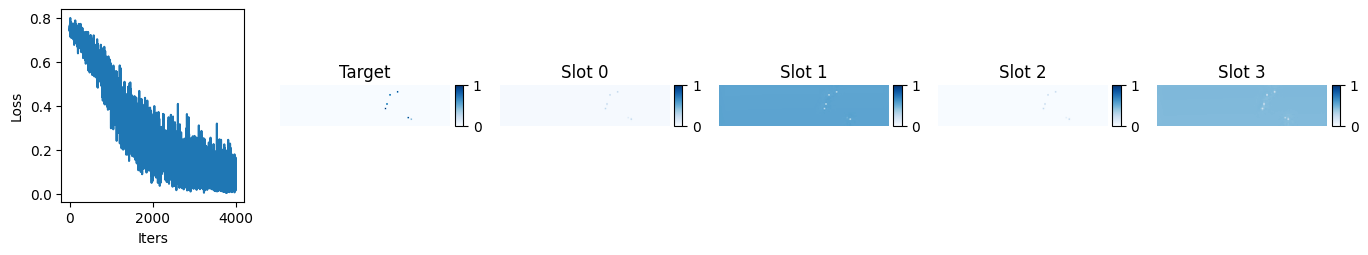

iter 4050 , loss 0.02796347 , lr 0.00023690503503263148


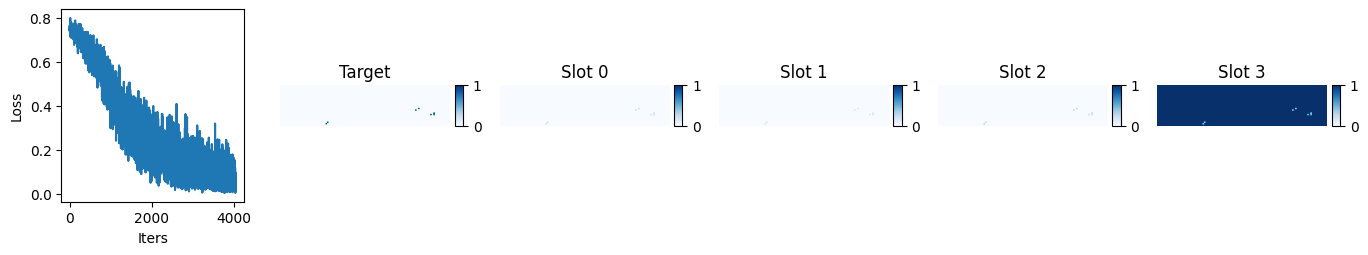

iter 4100 , loss 0.020169357 , lr 0.000239677823938937


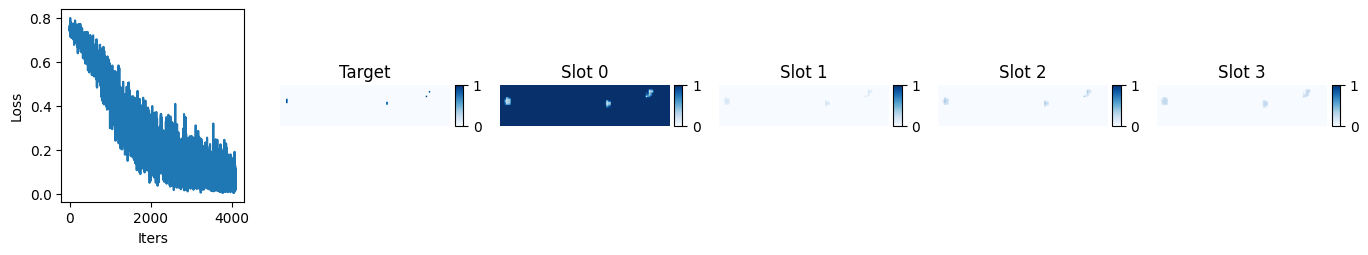

iter 4150 , loss 0.11196597 , lr 0.00024244508513201118


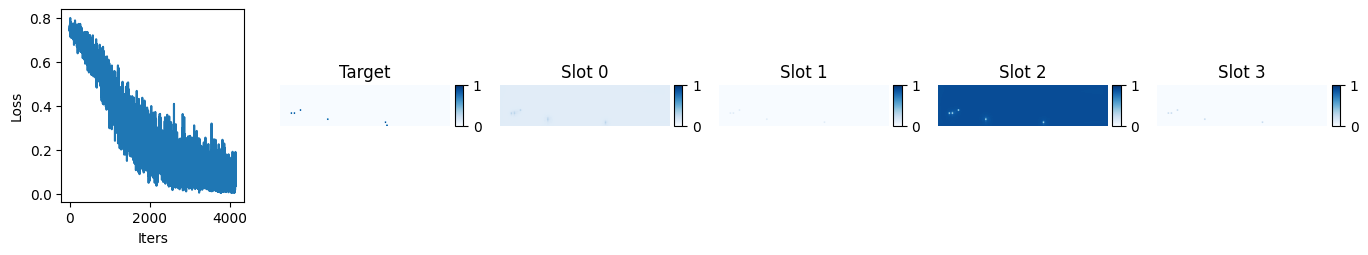

iter 4200 , loss 0.01866865 , lr 0.0002452067552122707


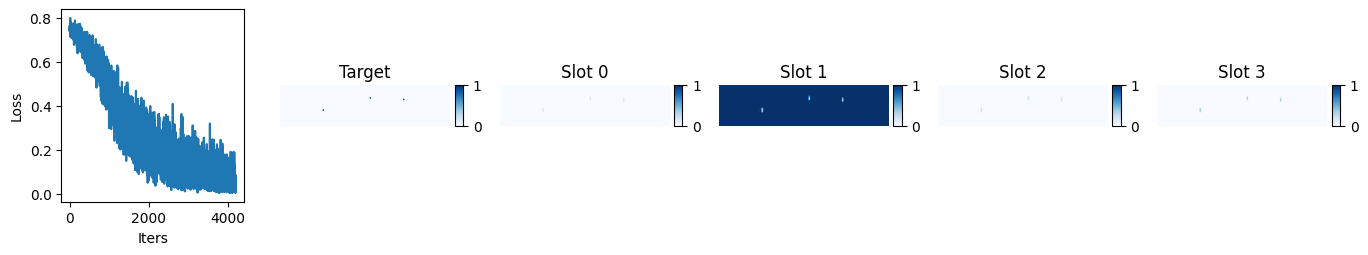

iter 4250 , loss 0.067108996 , lr 0.00024796277092452697


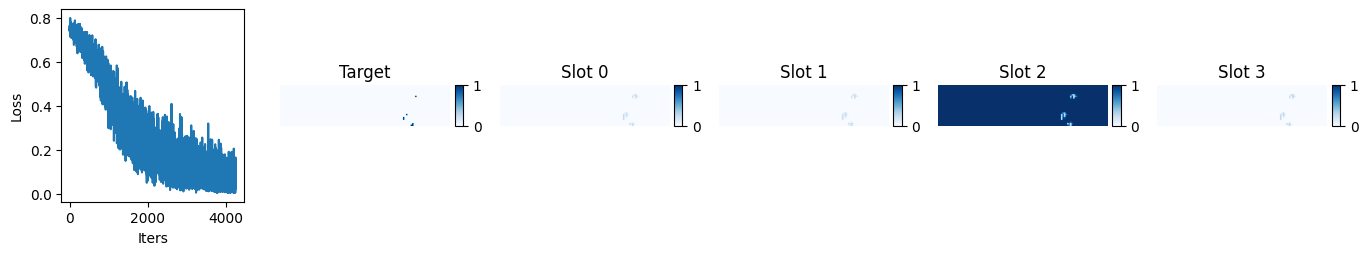

iter 4300 , loss 0.035143867 , lr 0.0002507130691596369


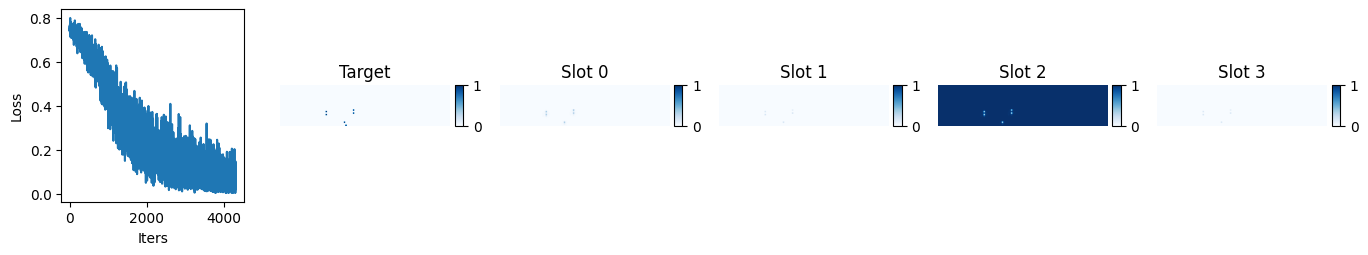

iter 4350 , loss 0.08575031 , lr 0.0002534575869561511


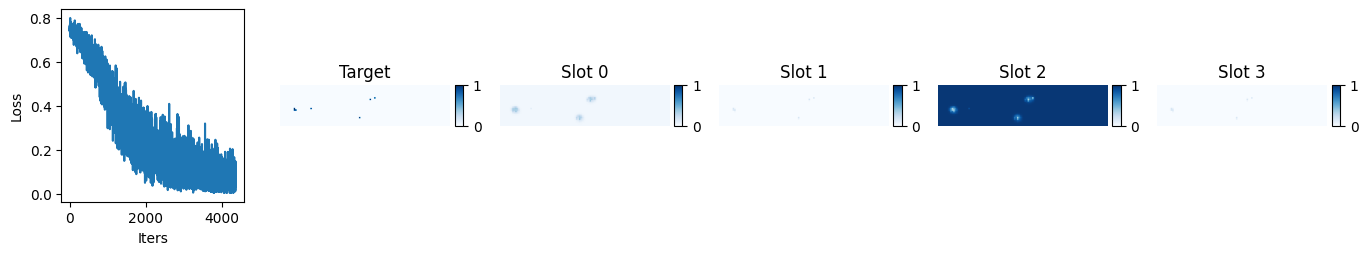

iter 4400 , loss 0.09574299 , lr 0.00025619626150195777


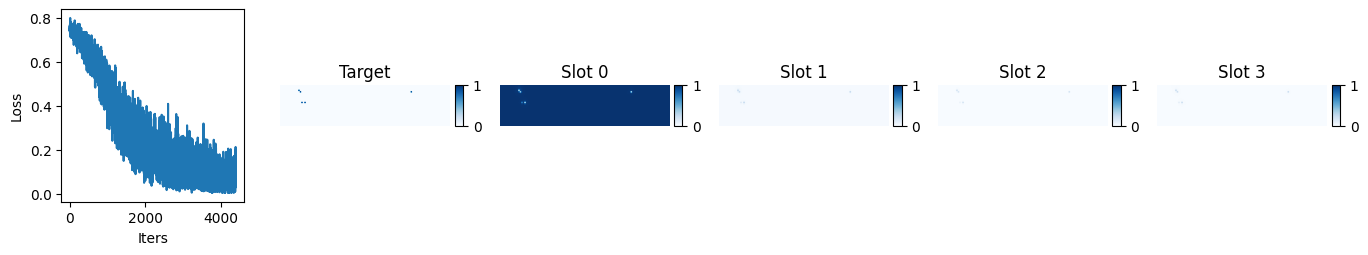

iter 4450 , loss 0.063640215 , lr 0.0002589290301359243


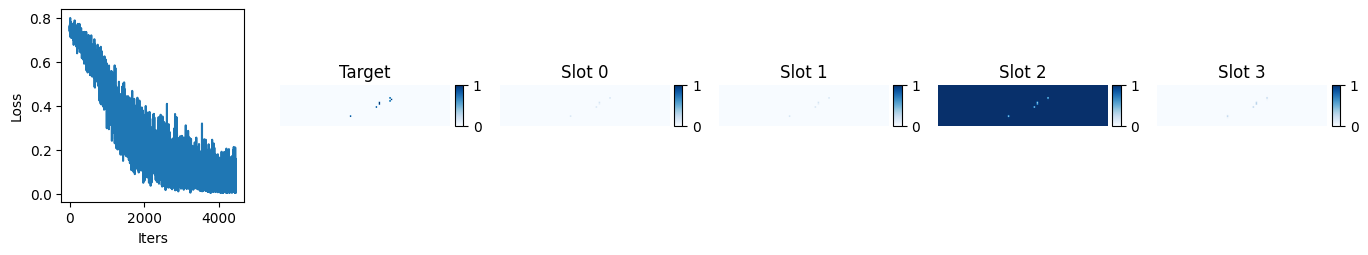

iter 4500 , loss 0.035677984 , lr 0.00026165583034953535


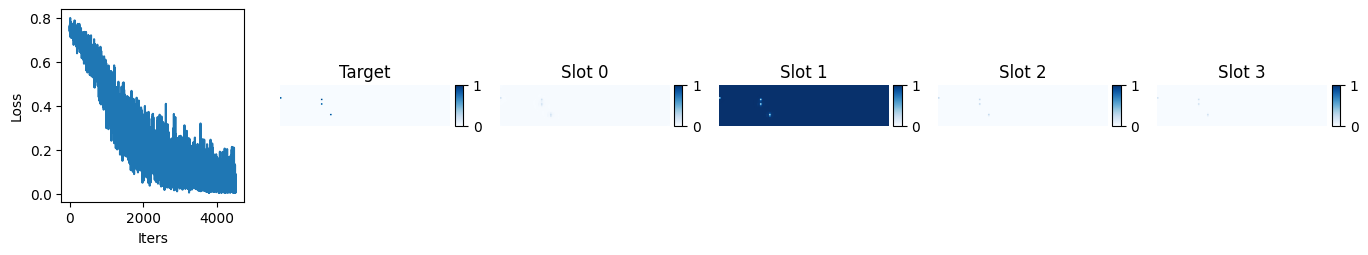

iter 4550 , loss 0.057981145 , lr 0.0002643765997885278


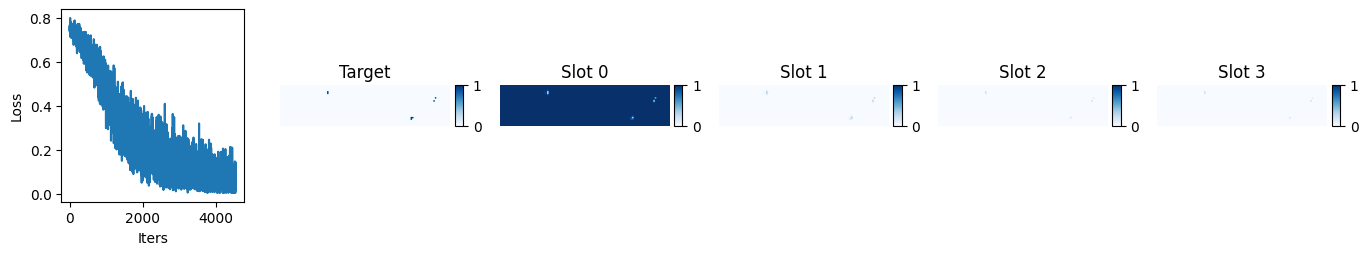

iter 4600 , loss 0.009881123 , lr 0.0002670912762545217


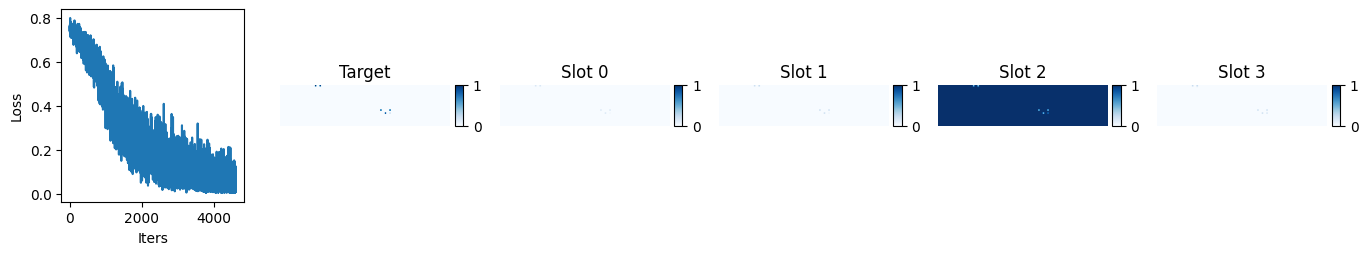

iter 4650 , loss 0.111898705 , lr 0.0002697997977066486


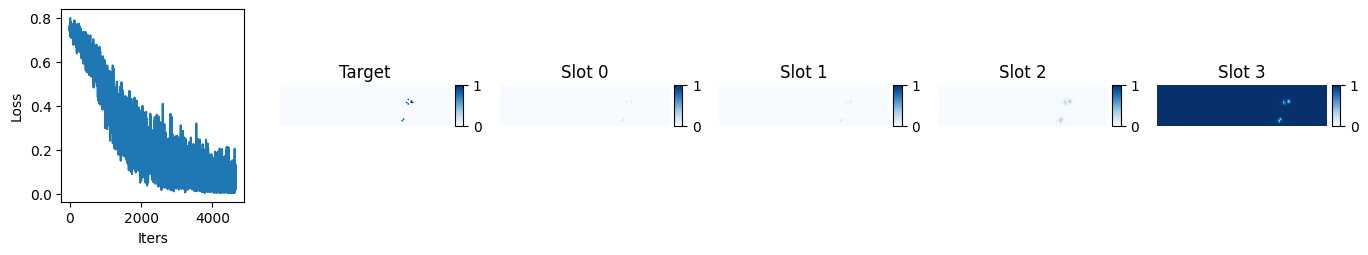

iter 4700 , loss 0.0066020014 , lr 0.00027250210226317627


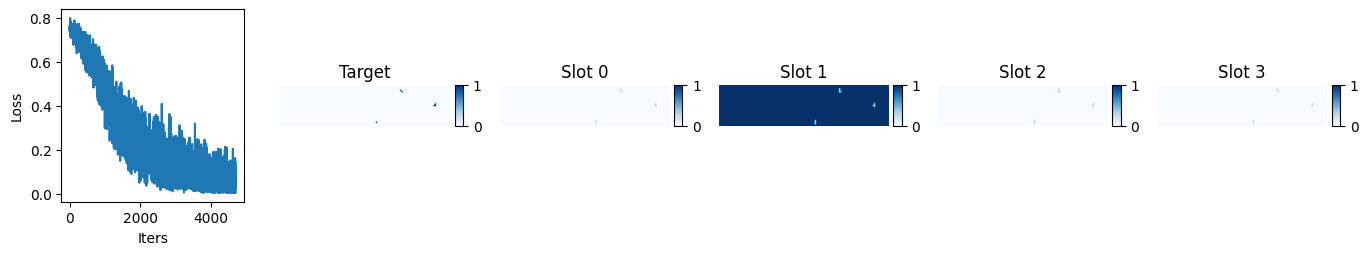

iter 4750 , loss 0.062170036 , lr 0.00027519812820312947


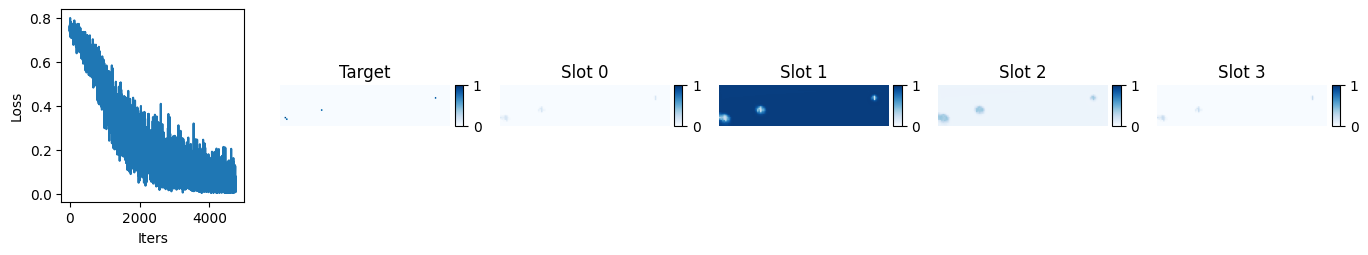

iter 4800 , loss 0.102672 , lr 0.00027788781396790815


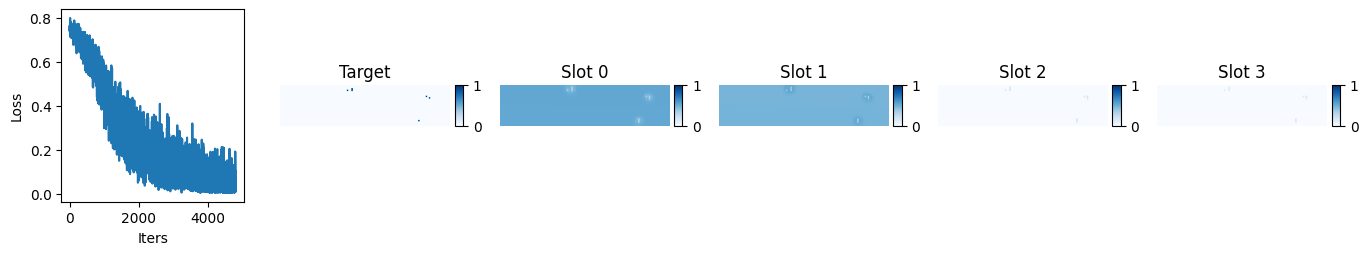

iter 4850 , loss 0.00620623 , lr 0.00028057109816290133


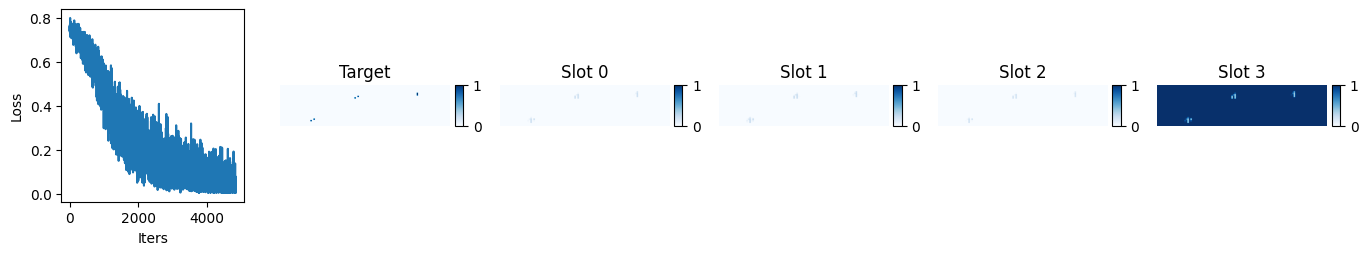

iter 4900 , loss 0.057698984 , lr 0.0002832479195590977


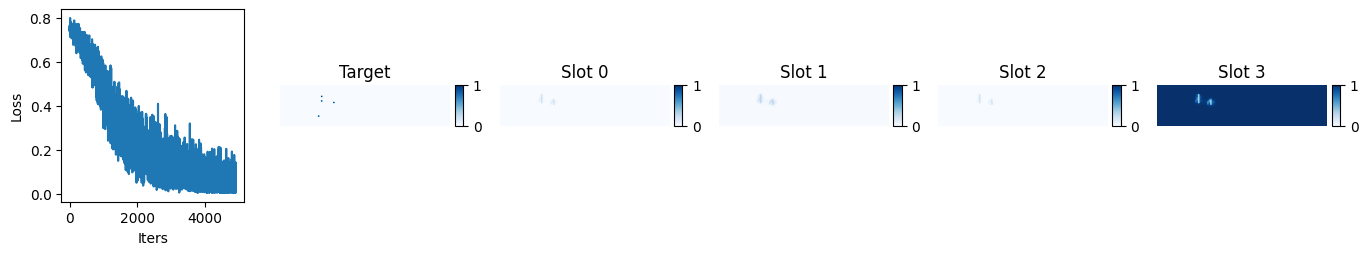

iter 4950 , loss 0.054541387 , lr 0.000285918217094693


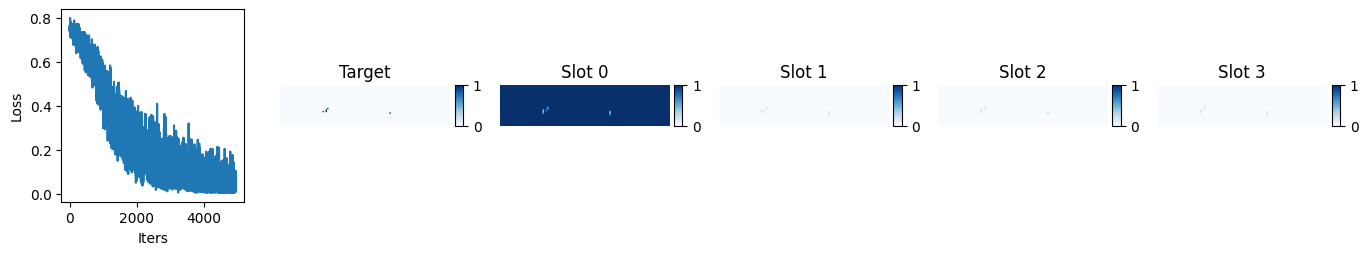

iter 5000 , loss 0.00830131 , lr 0.000288581929876693


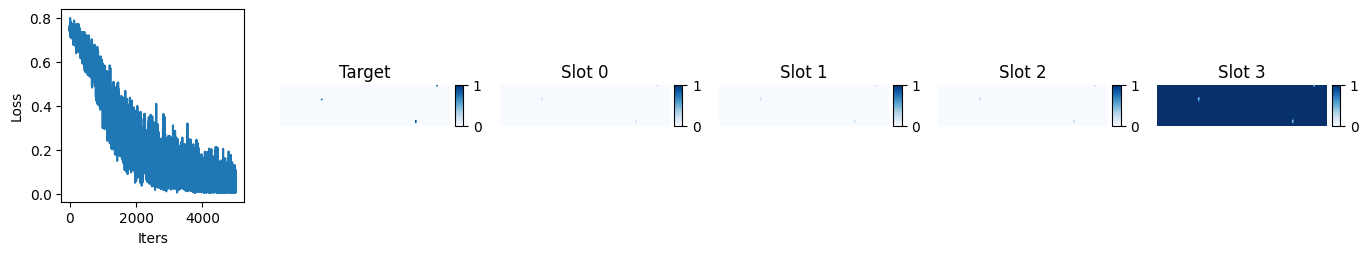

iter 5050 , loss 0.058269512 , lr 0.000288355442754964


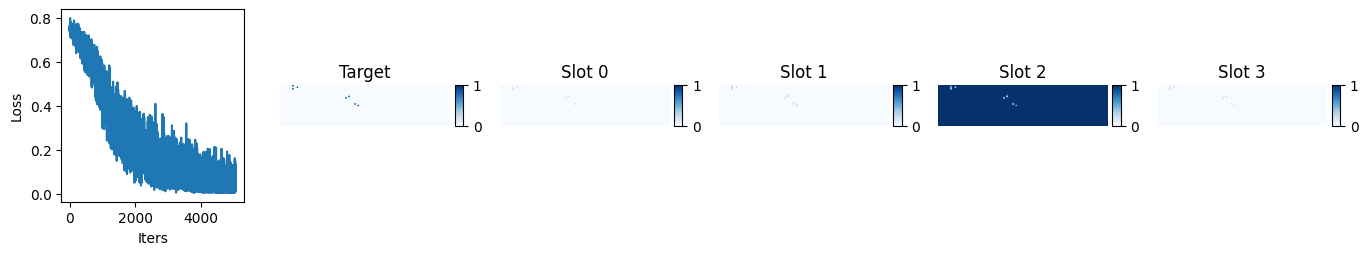

iter 5100 , loss 0.07650797 , lr 0.00028812682202115393


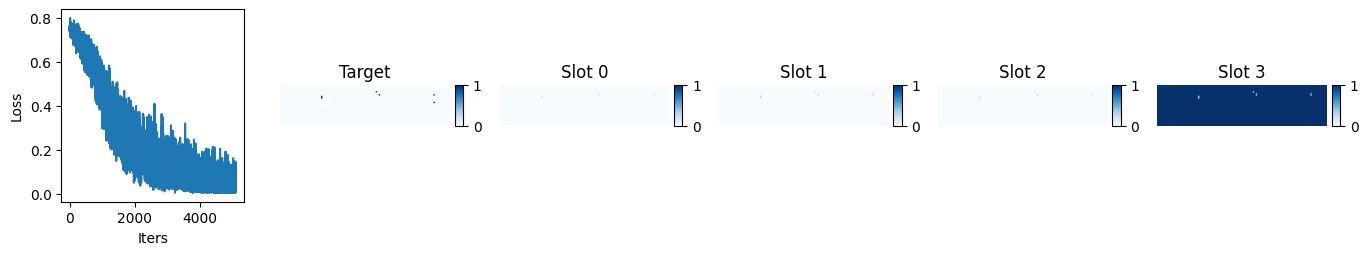

iter 5150 , loss 0.024387961 , lr 0.0002878960712008773


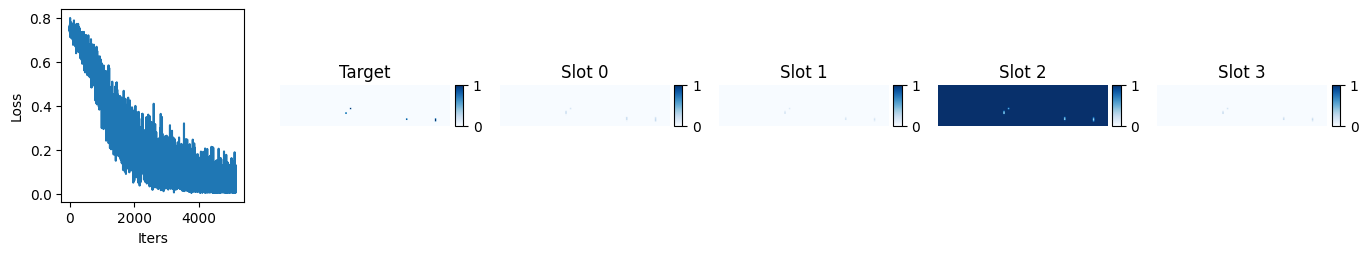

iter 5200 , loss 0.011524485 , lr 0.00028766319385259713


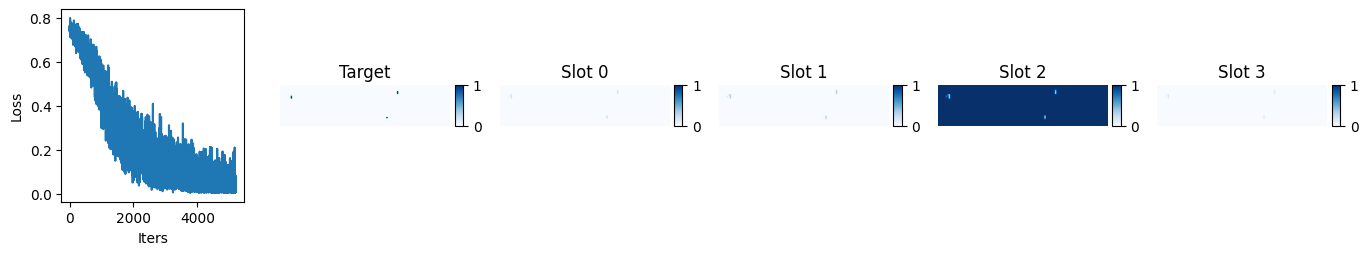

iter 5250 , loss 0.018136045 , lr 0.0002874281935675704


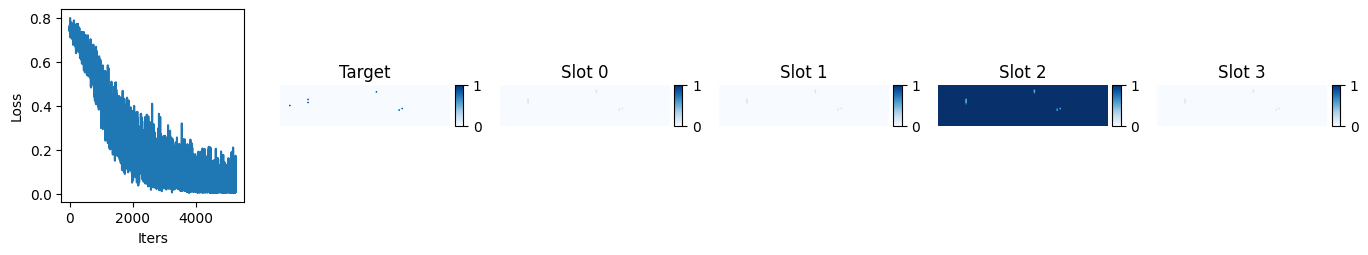

iter 5300 , loss 0.03286629 , lr 0.000287191073969792


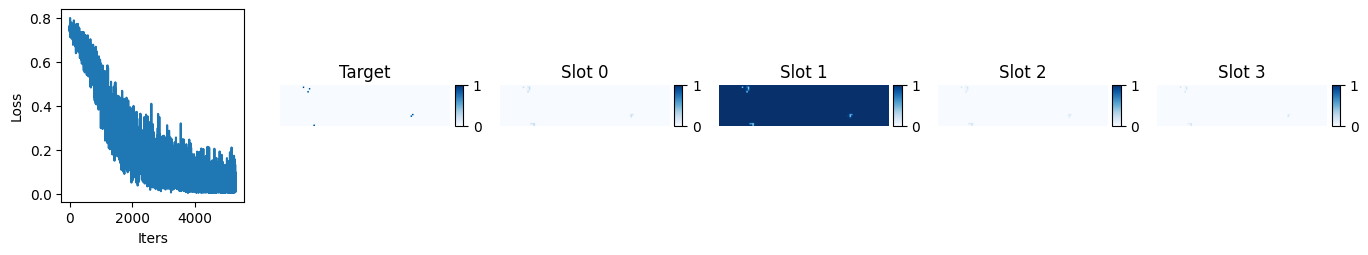

iter 5350 , loss 0.07142614 , lr 0.0002869518387159396


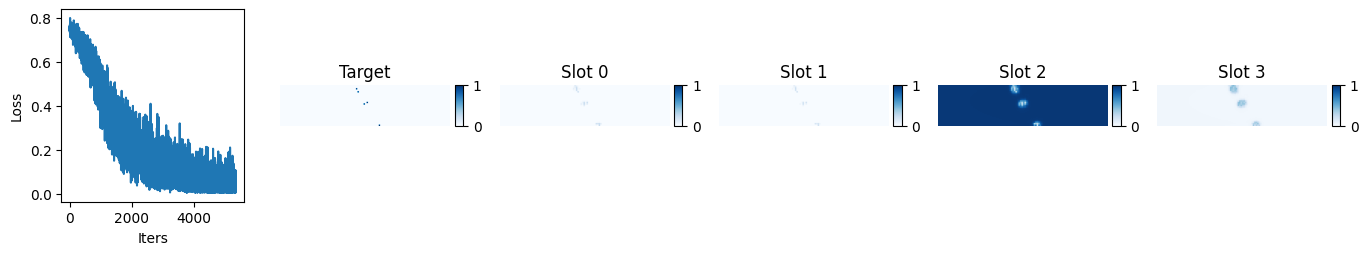

iter 5400 , loss 0.016727183 , lr 0.00028671049149531675


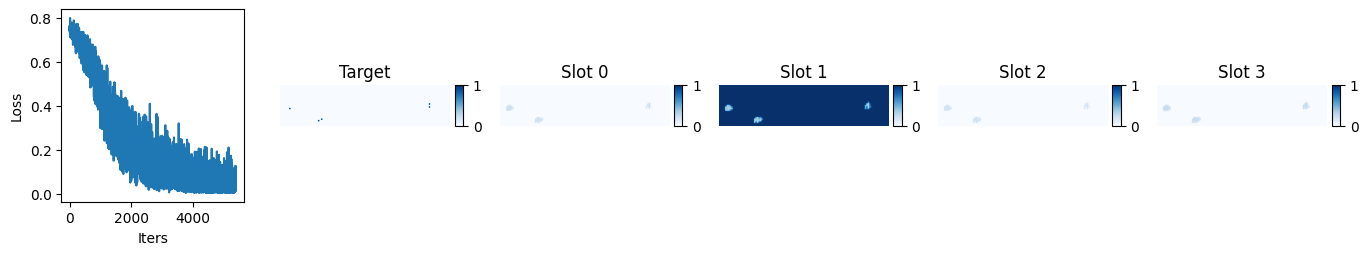

iter 5450 , loss 0.008087405 , lr 0.0002864670360297961


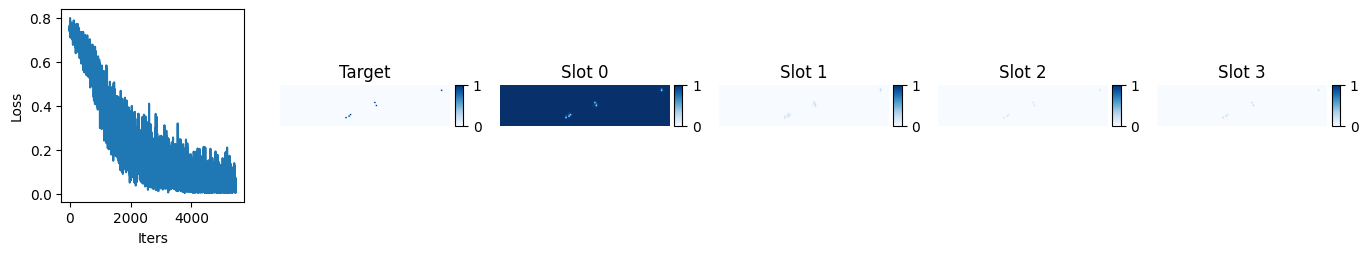

iter 5500 , loss 0.005940784 , lr 0.0002862214760737622


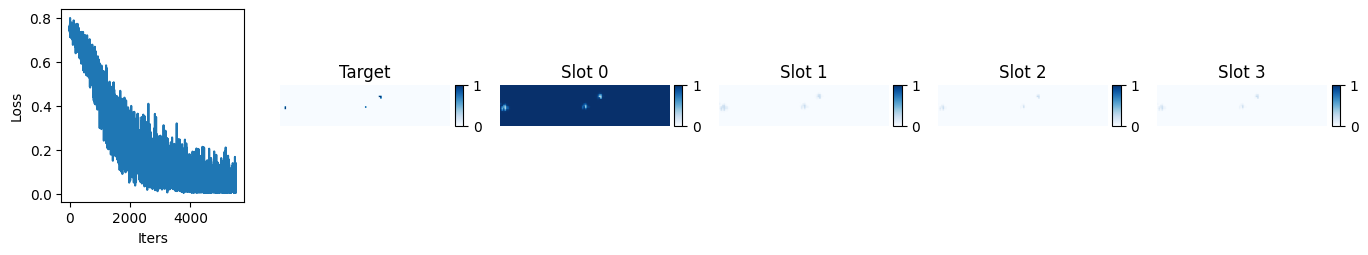

iter 5550 , loss 0.008079152 , lr 0.0002859738154140532


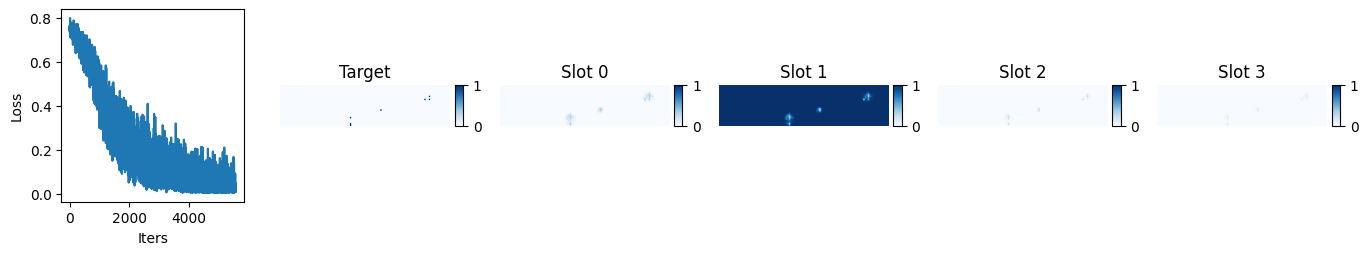

iter 5600 , loss 0.008964555 , lr 0.00028572405786990294


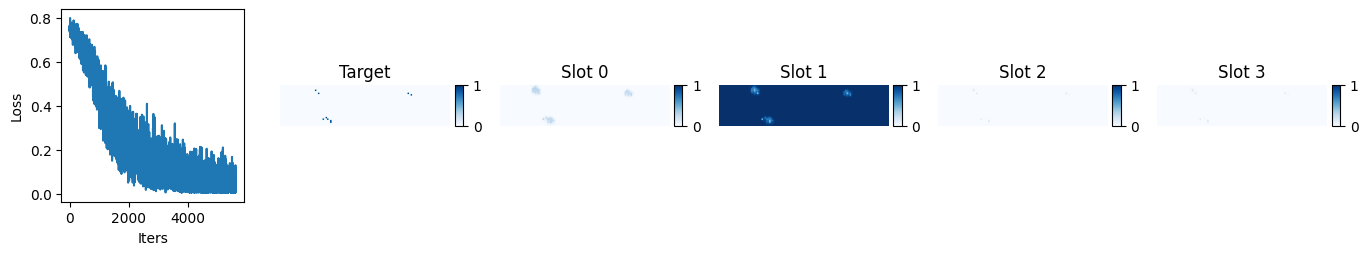

iter 5650 , loss 0.009562049 , lr 0.00028547220729288164


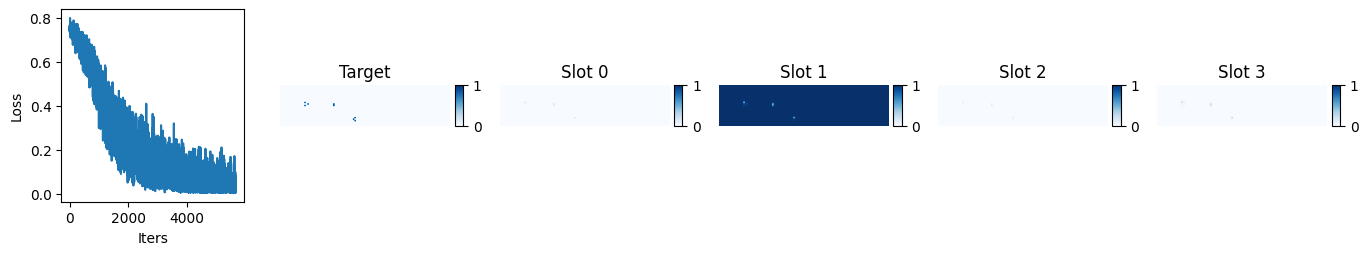

iter 5700 , loss 0.018585036 , lr 0.0002852182675668368


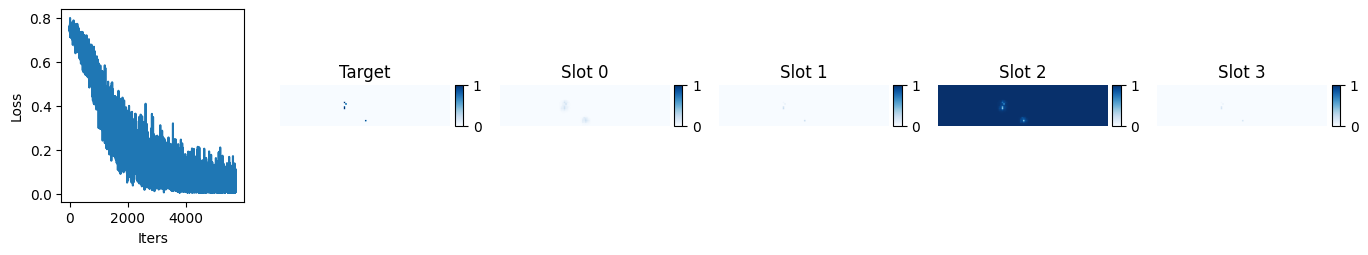

iter 5750 , loss 0.004225791 , lr 0.0002849622426078332


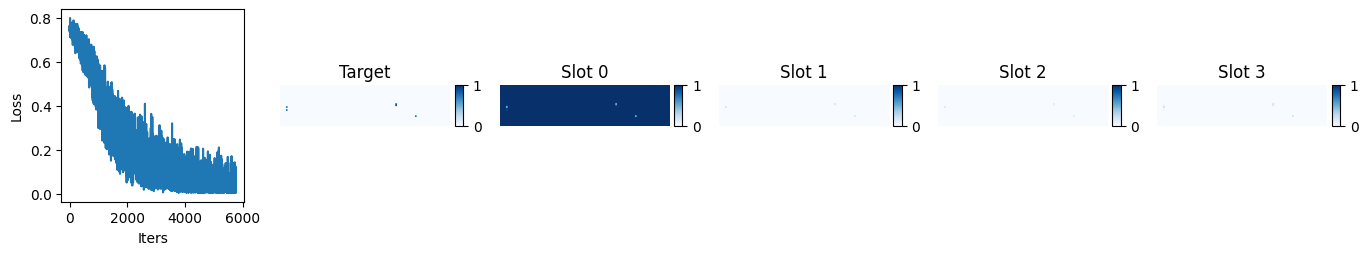

iter 5800 , loss 0.0061628167 , lr 0.0002847041363640923


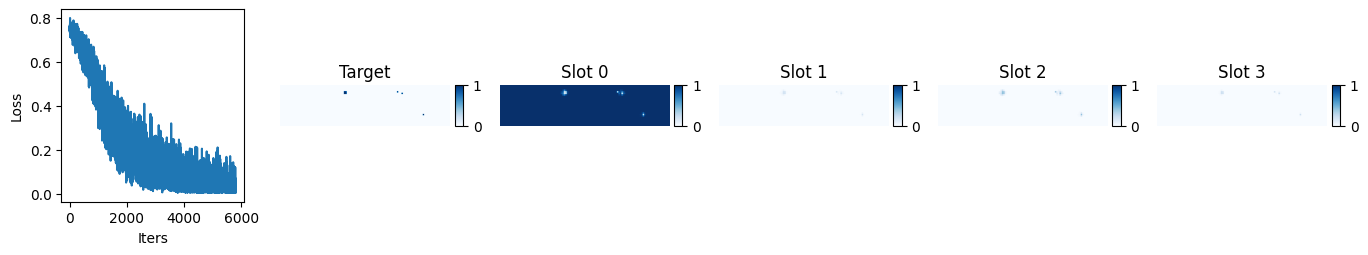

iter 5850 , loss 0.007057642 , lr 0.0002844439528159318


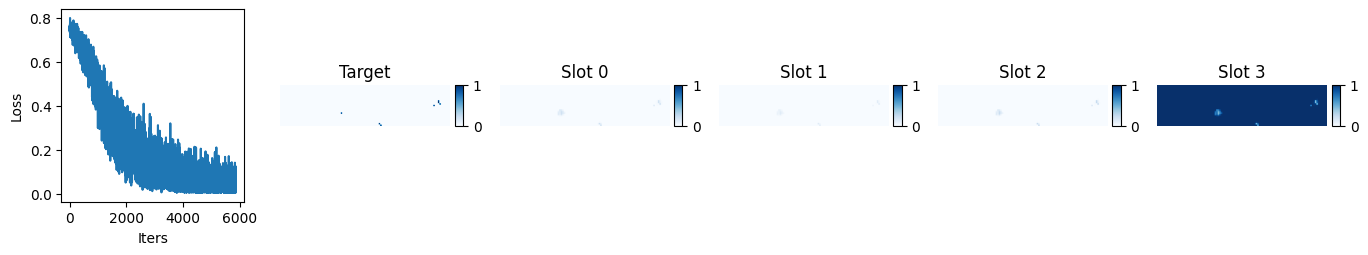

iter 5900 , loss 0.0050373585 , lr 0.0002841816959757037


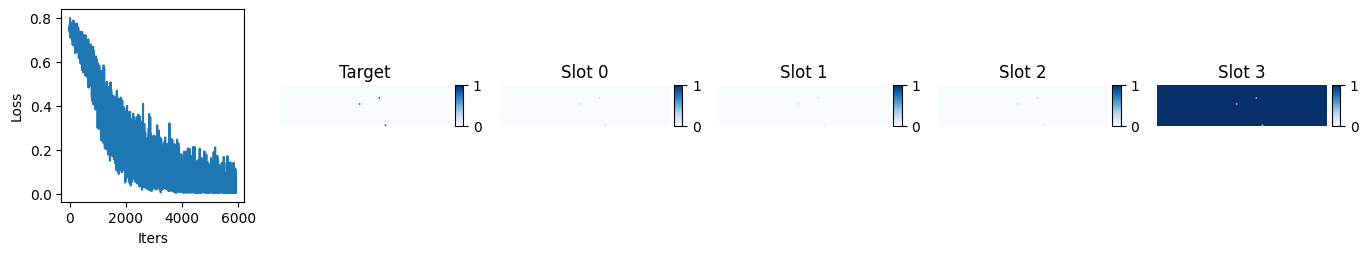

iter 5950 , loss 0.1058566 , lr 0.0002839173698877331


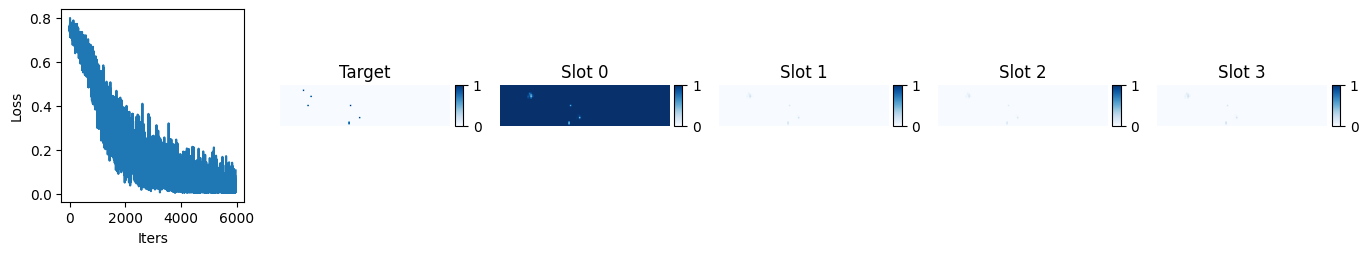

iter 6000 , loss 0.010578344 , lr 0.00028365097862825513


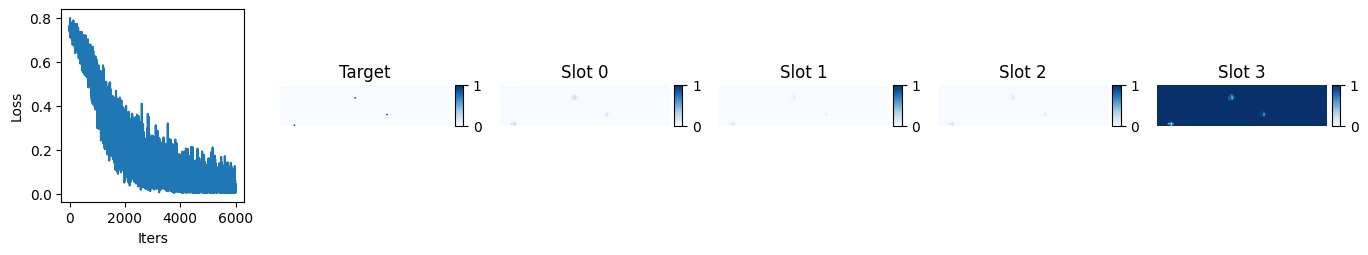

iter 6050 , loss 0.0061223893 , lr 0.00028338252630535264


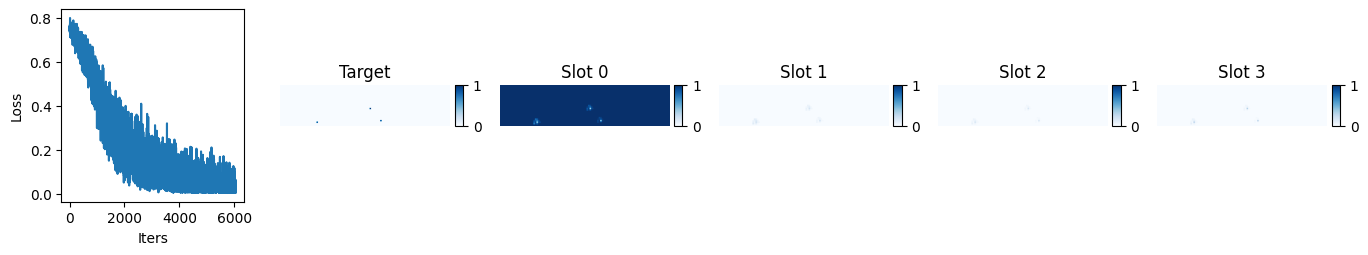

iter 6100 , loss 0.011420239 , lr 0.00028311201705889246


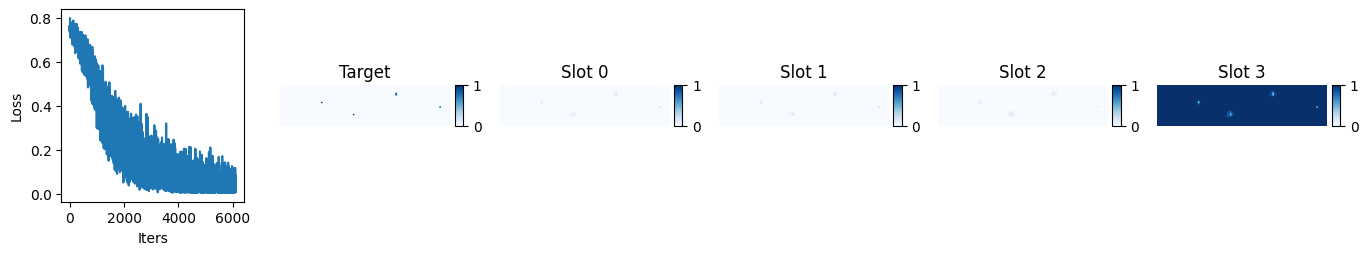

iter 6150 , loss 0.028477047 , lr 0.0002828394550604618


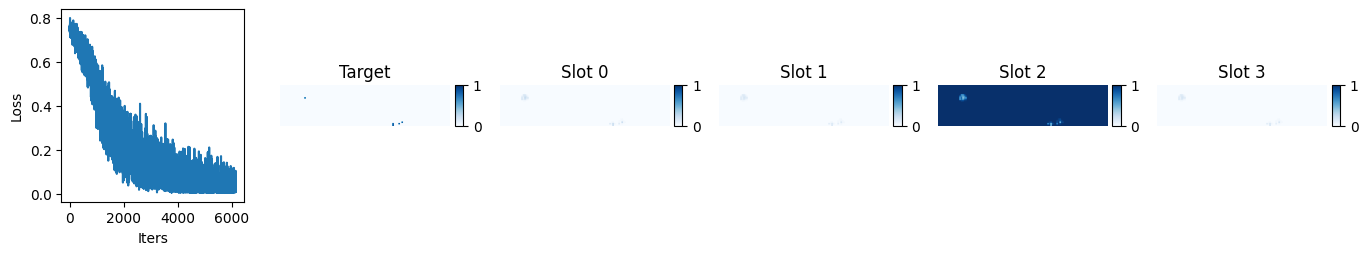

iter 6200 , loss 0.0077454266 , lr 0.00028256484451330403


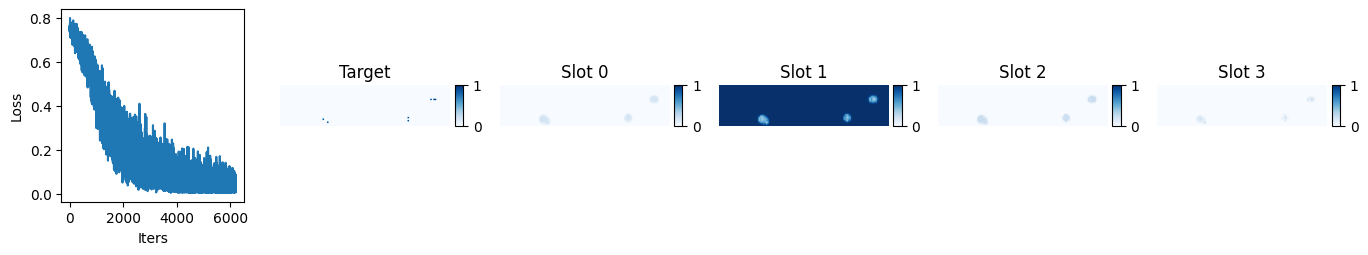

iter 6250 , loss 0.013228048 , lr 0.0002822881896522532


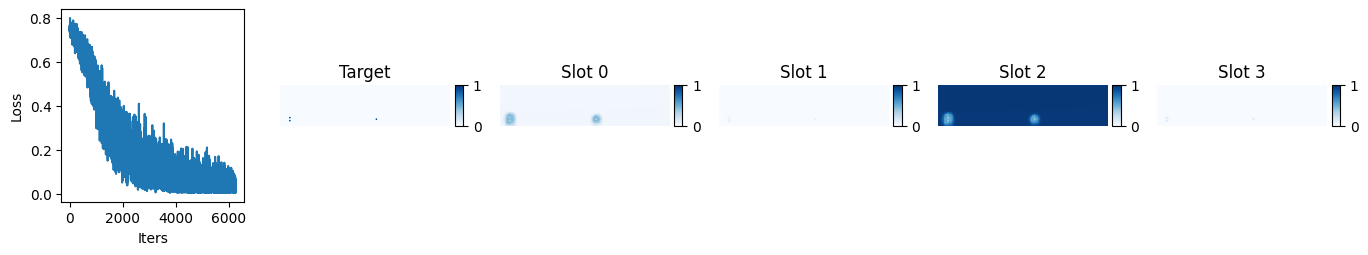

iter 6300 , loss 0.10796112 , lr 0.0002820094947436698


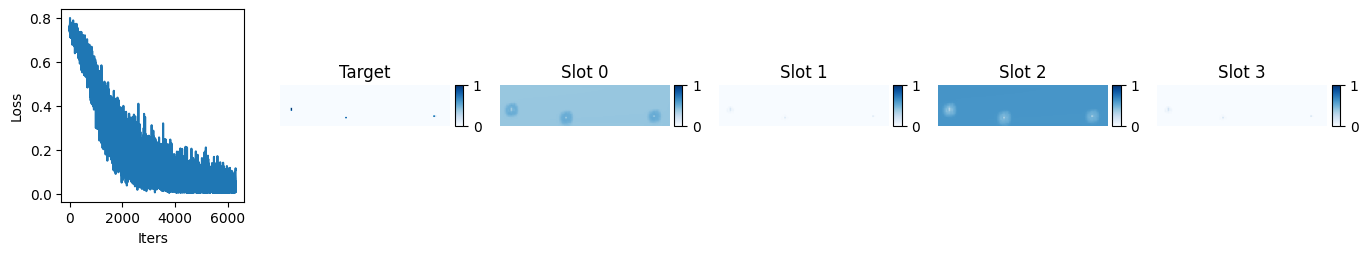

iter 6350 , loss 0.016961202 , lr 0.0002817287640853738


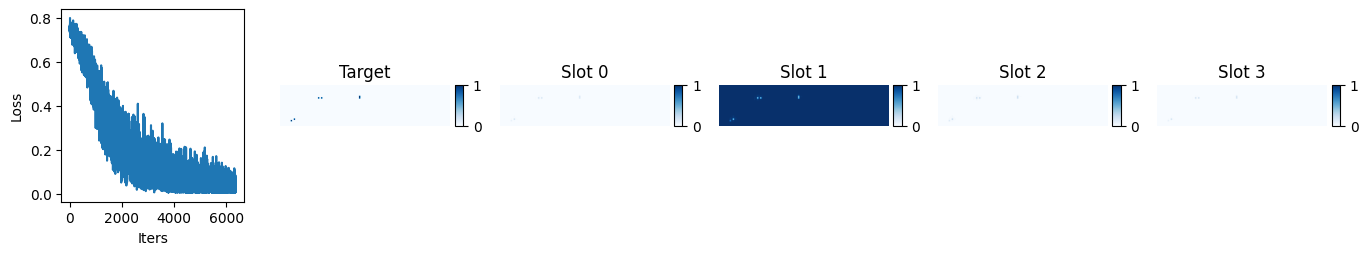

iter 6400 , loss 0.024365623 , lr 0.0002814460020065795


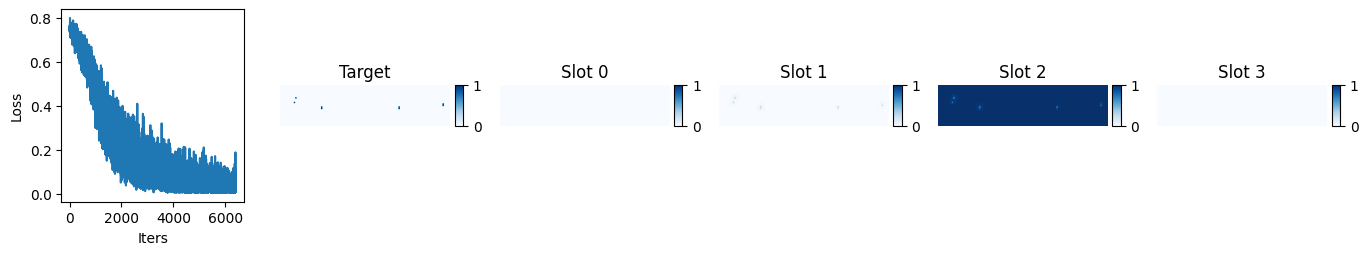

iter 6450 , loss 0.03871711 , lr 0.00028116121286782784


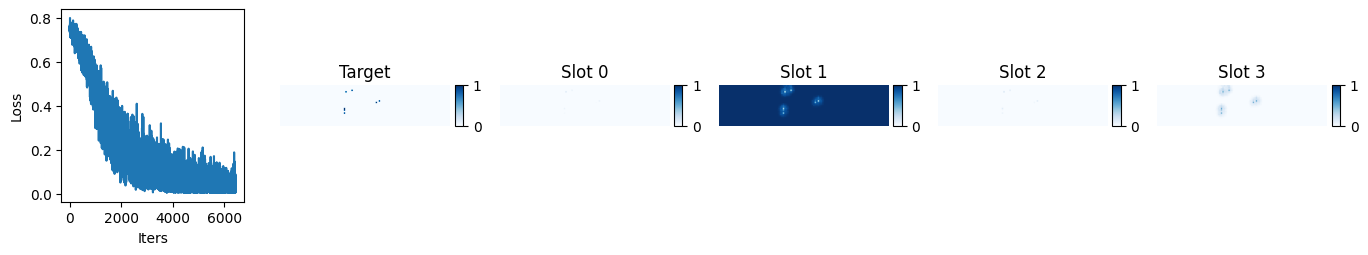

iter 6500 , loss 0.052334044 , lr 0.0002808744010609196


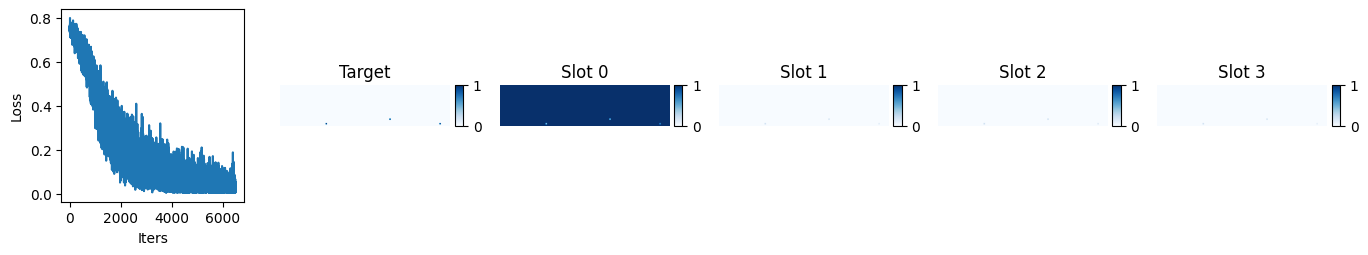

iter 6550 , loss 0.010039554 , lr 0.0002805855710088476


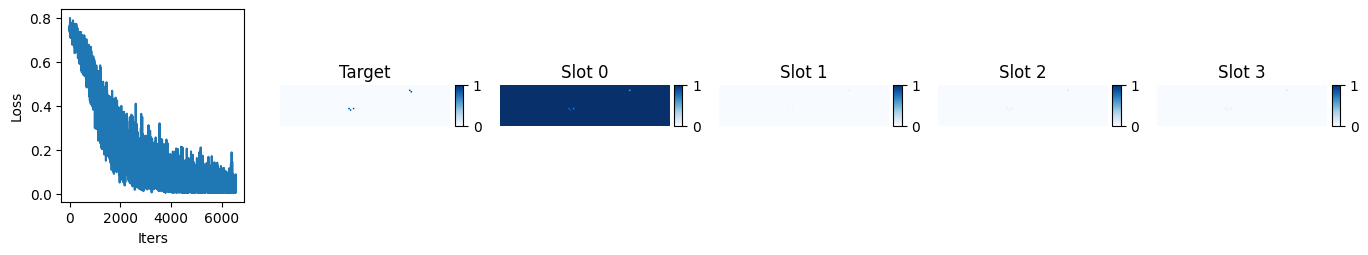

iter 6600 , loss 0.02660455 , lr 0.00028029472716572867


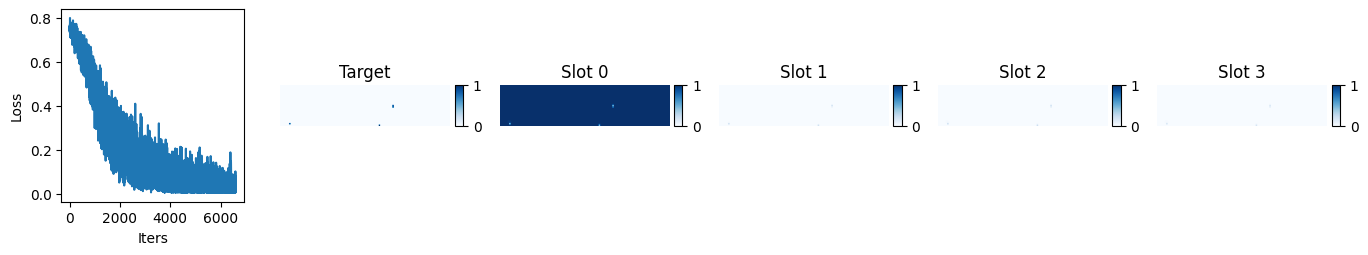

iter 6650 , loss 0.013444851 , lr 0.0002800018740167346


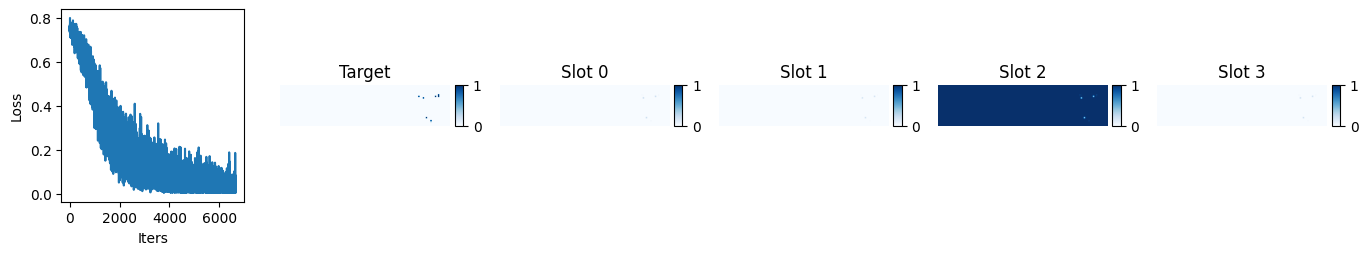

iter 6700 , loss 0.0064356434 , lr 0.0002797070160780232


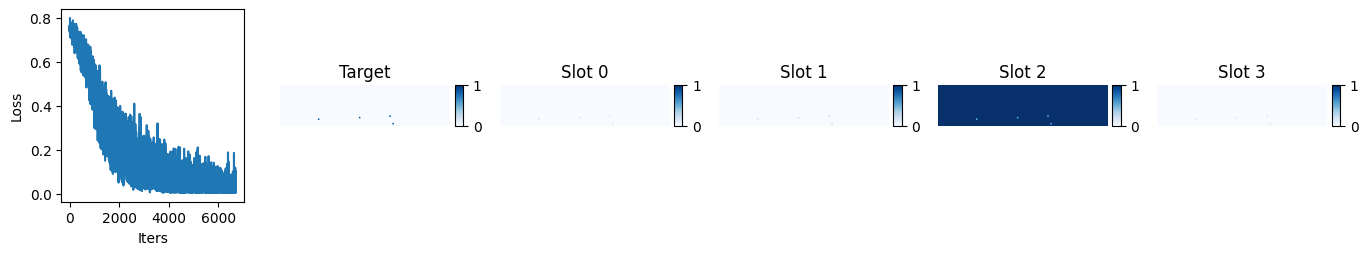

iter 6750 , loss 0.08617688 , lr 0.00027941015789666873


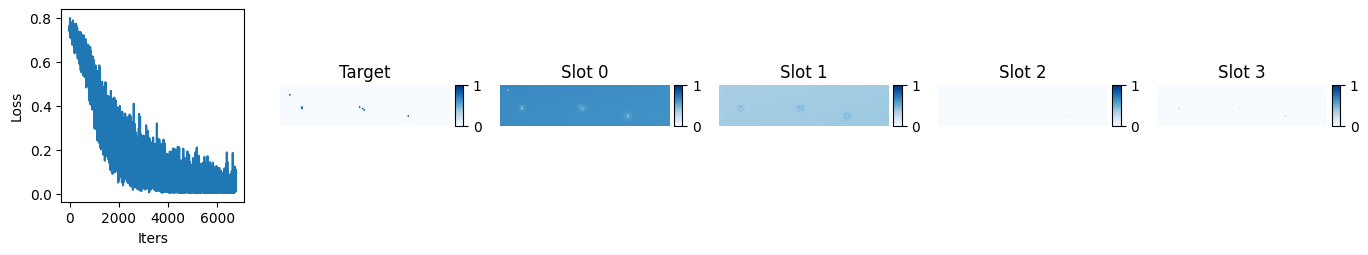

iter 6800 , loss 0.01129812 , lr 0.0002791113040505915


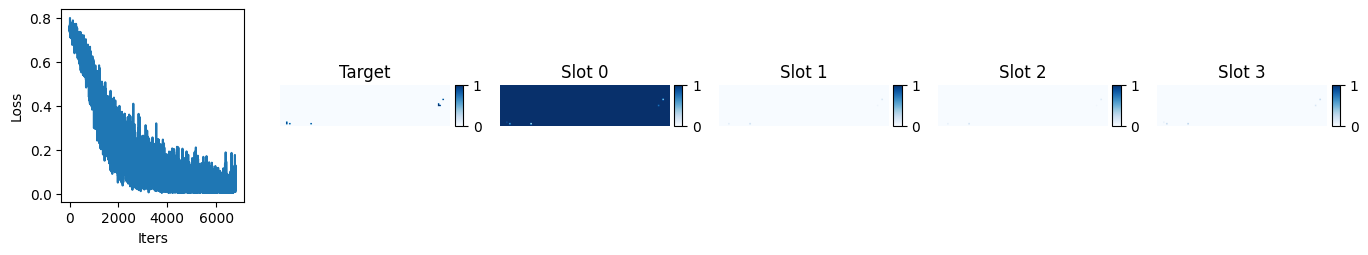

iter 6850 , loss 0.008836116 , lr 0.00027881045914848756


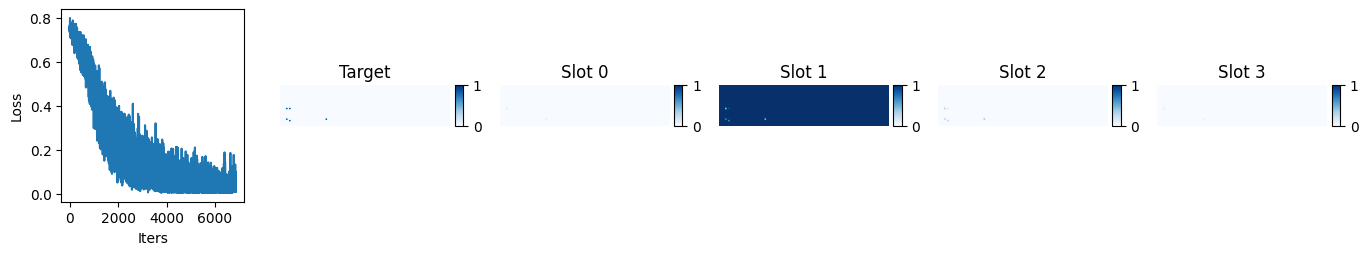

iter 6900 , loss 0.028968344 , lr 0.0002785076278297574


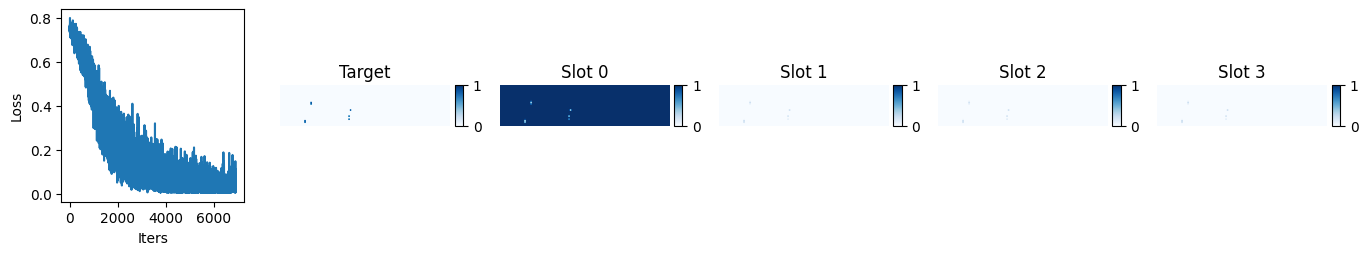

iter 6950 , loss 0.0063156052 , lr 0.00027820281476443465


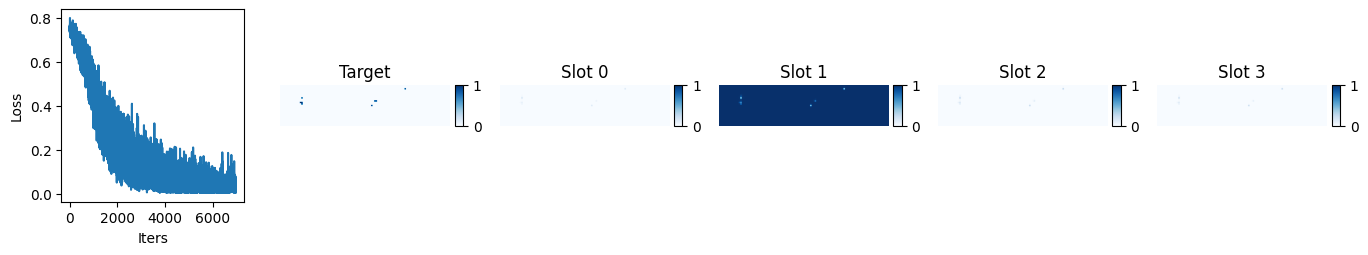

iter 7000 , loss 0.00922592 , lr 0.0002778960246531138


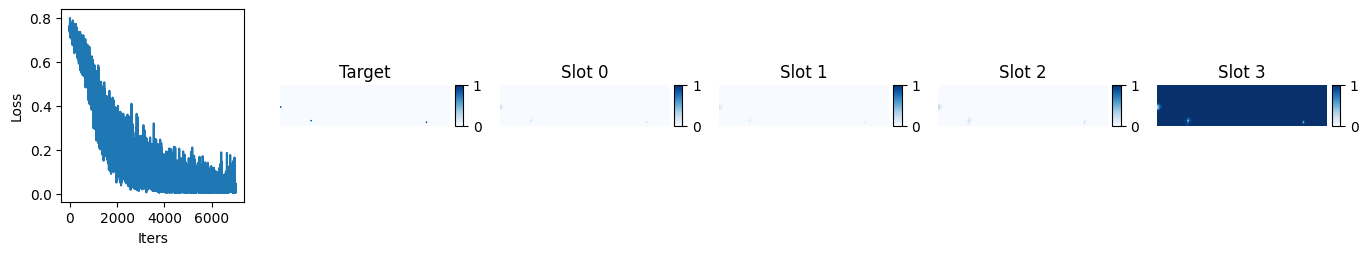

iter 7050 , loss 0.014924591 , lr 0.0002775872622268779


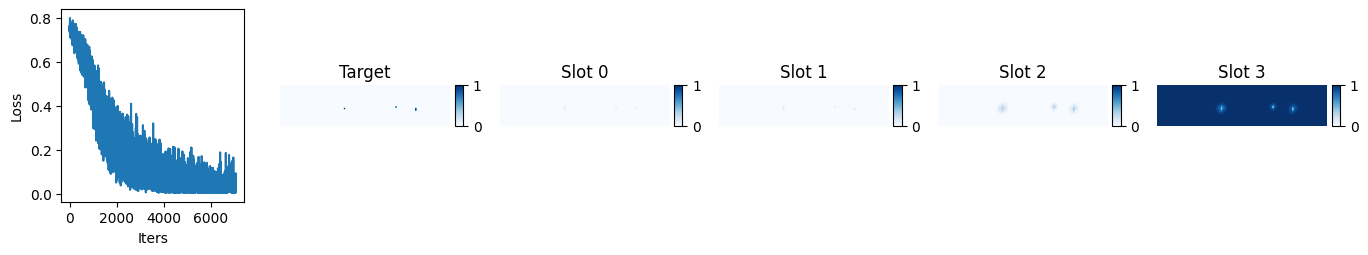

iter 7100 , loss 0.02412533 , lr 0.00027727653224722553


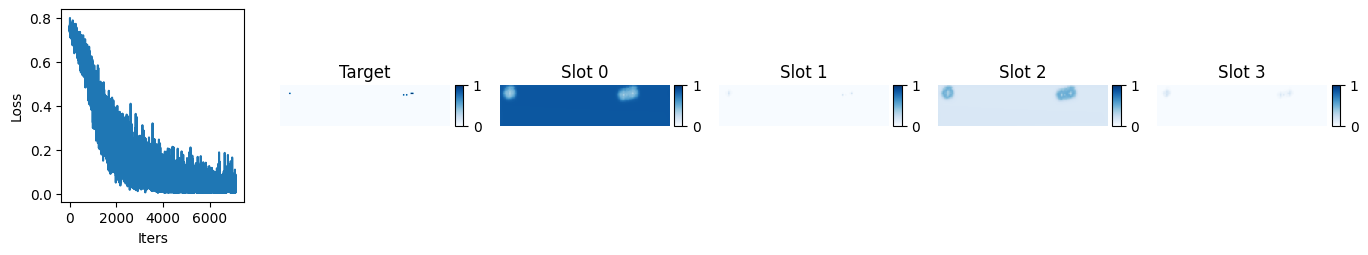

iter 7150 , loss 0.059735388 , lr 0.0002769638395059973


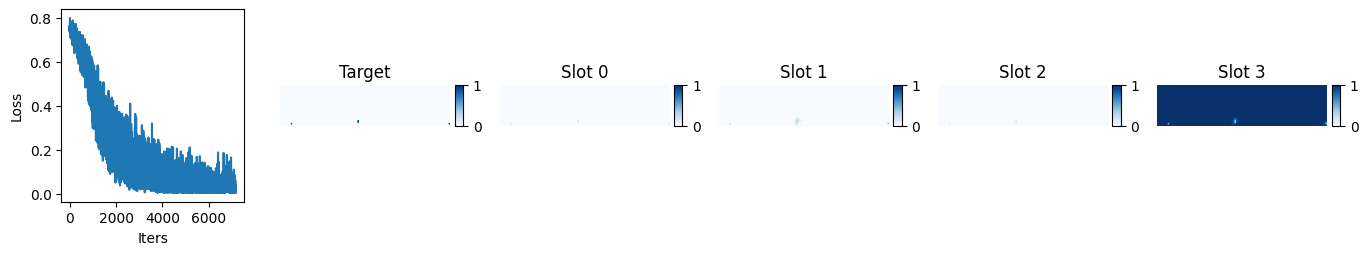

iter 7200 , loss 0.0075250585 , lr 0.00027664918882530225


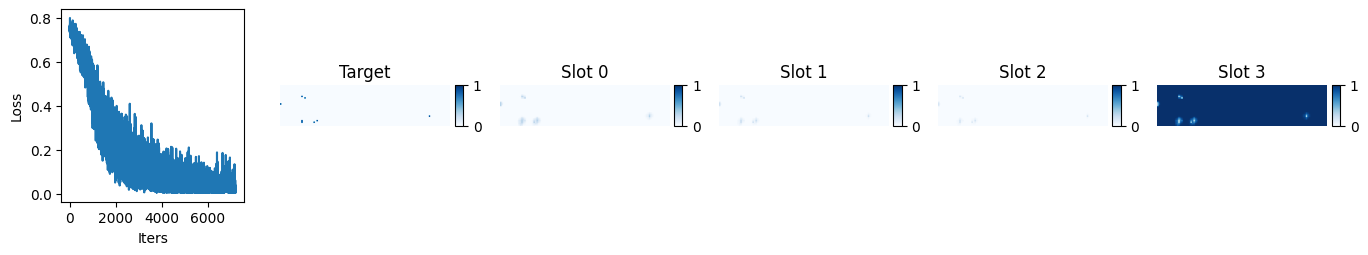

iter 7250 , loss 0.019284746 , lr 0.00027633258505744293


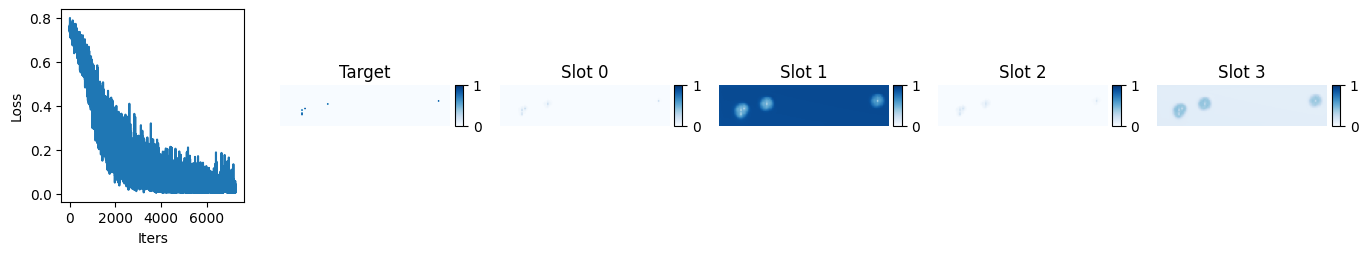

iter 7300 , loss 0.05746711 , lr 0.0002760140330848412


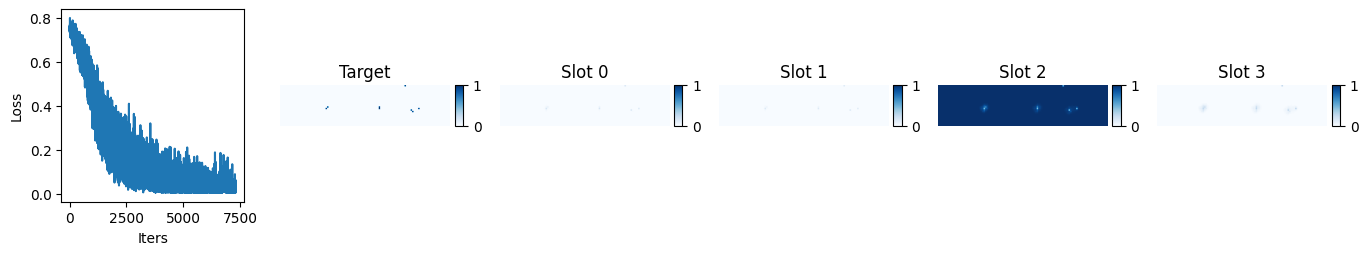

iter 7350 , loss 0.006000012 , lr 0.00027569353781996264


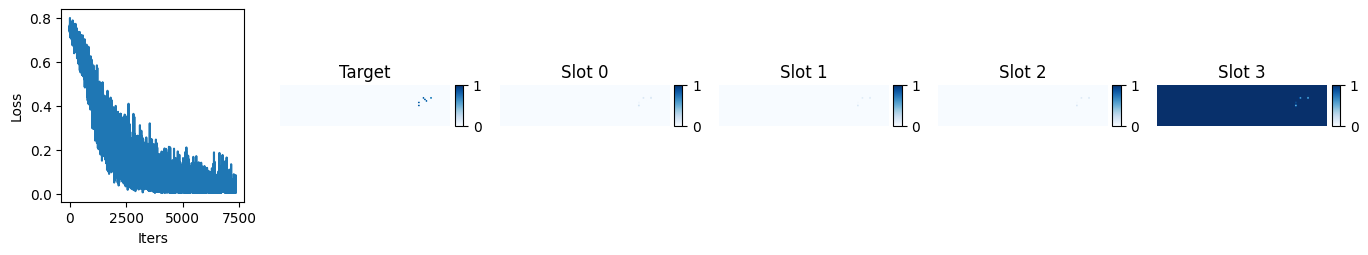

iter 7400 , loss 0.019727206 , lr 0.0002753711042052405


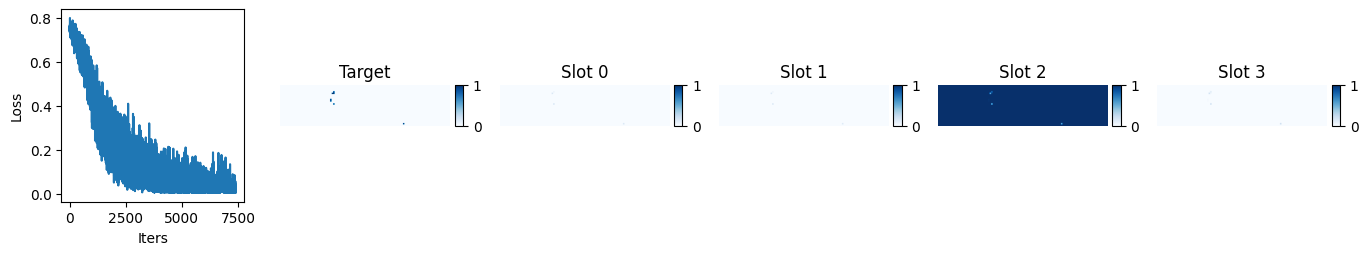

iter 7450 , loss 0.006615915 , lr 0.00027504673721300015


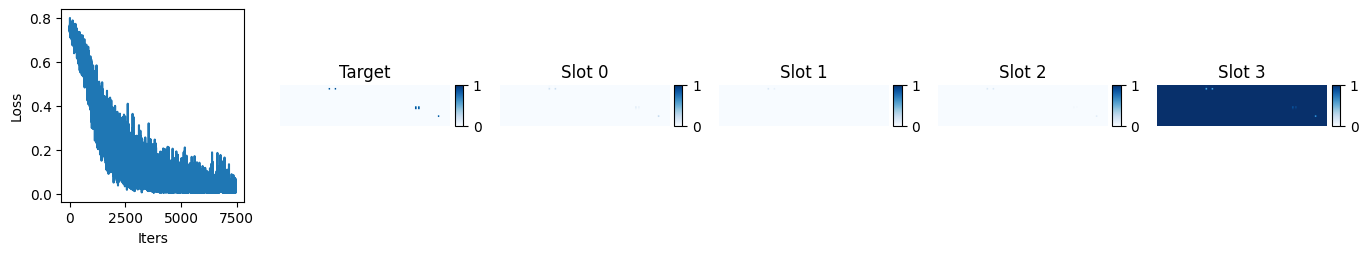

iter 7500 , loss 0.07448323 , lr 0.0002747204418453818


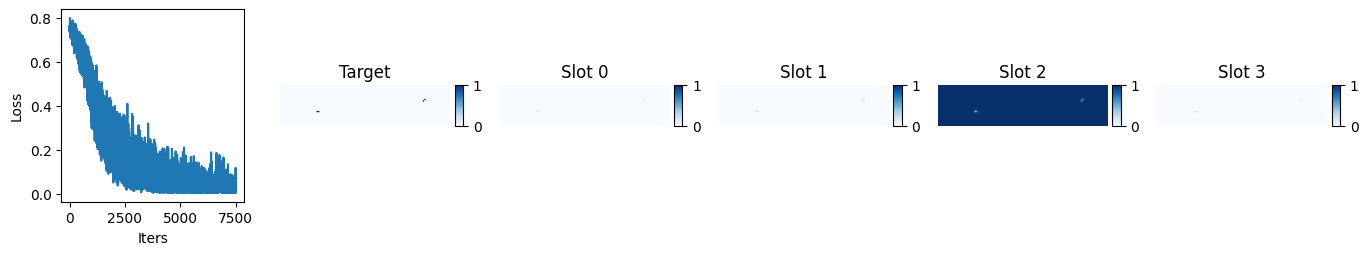

iter 7550 , loss 0.059908018 , lr 0.0002743922231342636


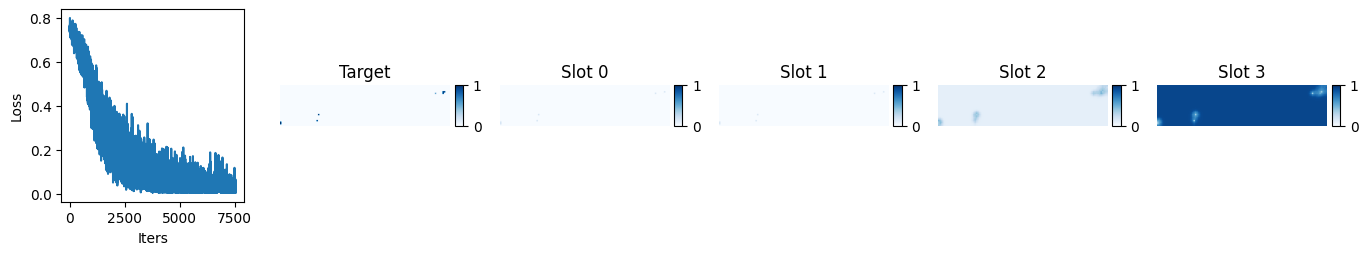

iter 7600 , loss 0.0636869 , lr 0.00027406208614118424


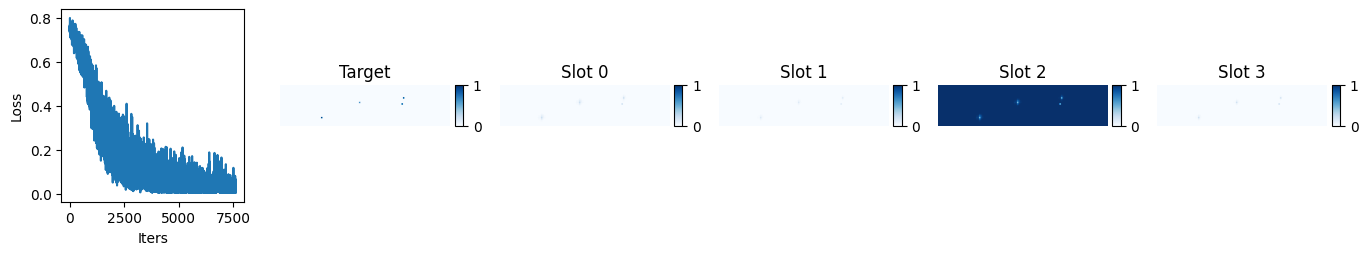

iter 7650 , loss 0.006561155 , lr 0.0002737300359572645


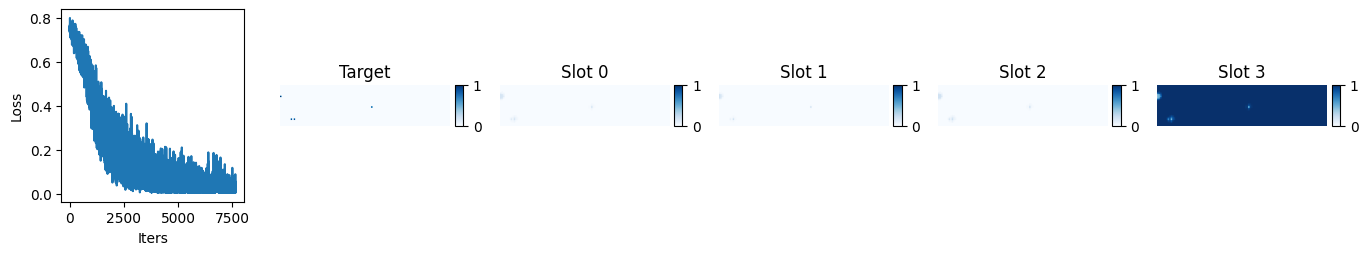

iter 7700 , loss 0.005001259 , lr 0.00027339607770312895


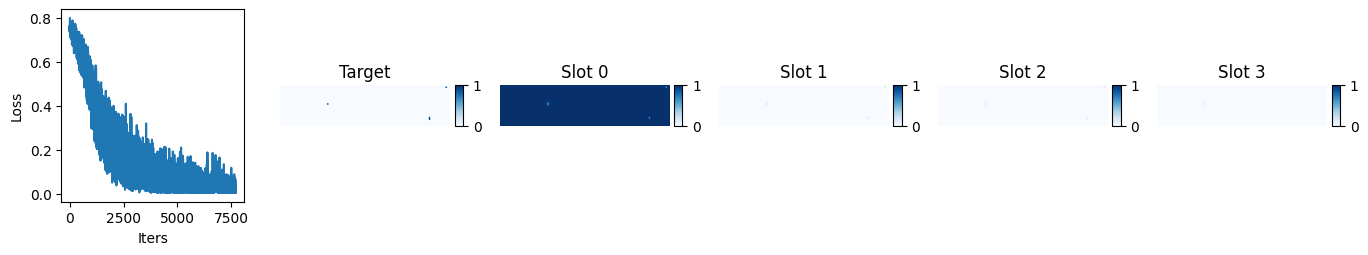

iter 7750 , loss 0.0049628974 , lr 0.00027306021652882703


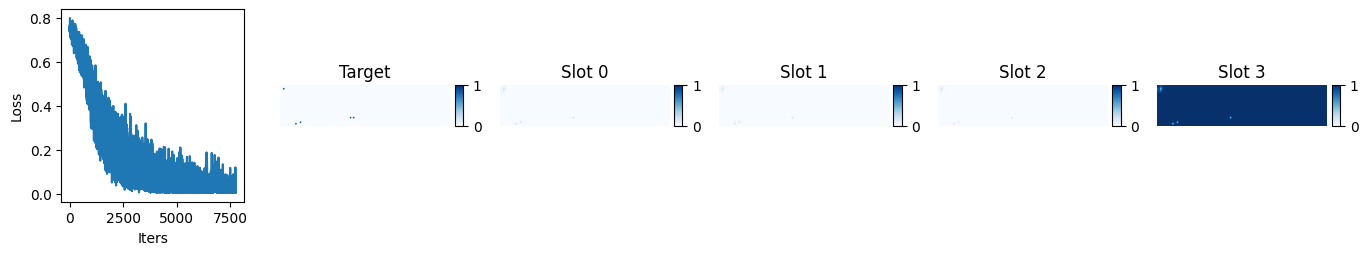

iter 7800 , loss 0.0061384337 , lr 0.0002727224576137535


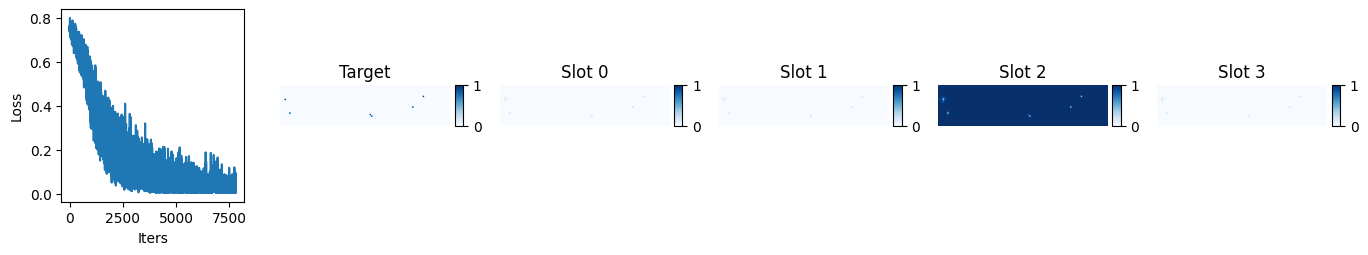

iter 7850 , loss 0.018976064 , lr 0.00027238280616656866


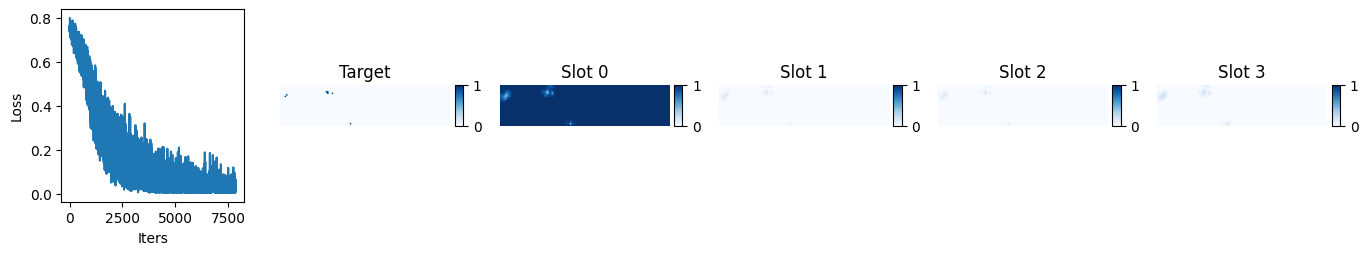

iter 7900 , loss 0.008492201 , lr 0.00027204126742511807


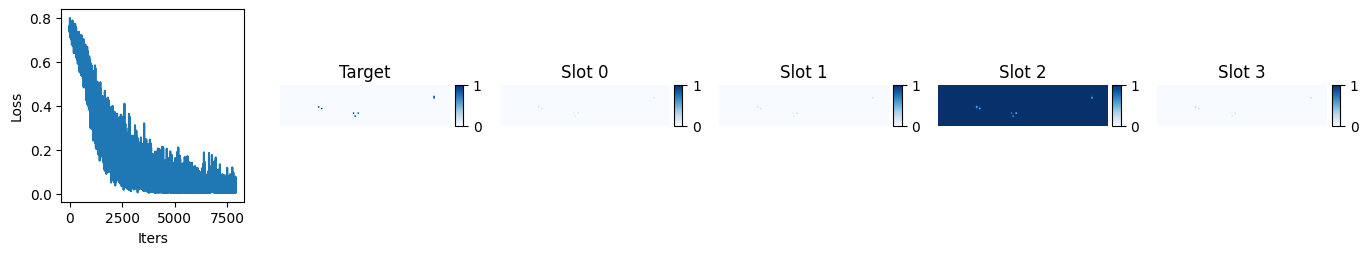

iter 7950 , loss 0.010313334 , lr 0.00027169784665635147


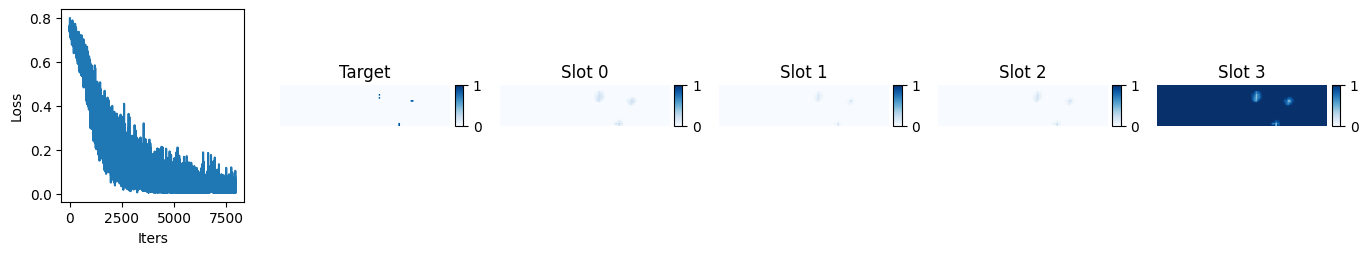

iter 8000 , loss 0.0072434926 , lr 0.0002713525491562421


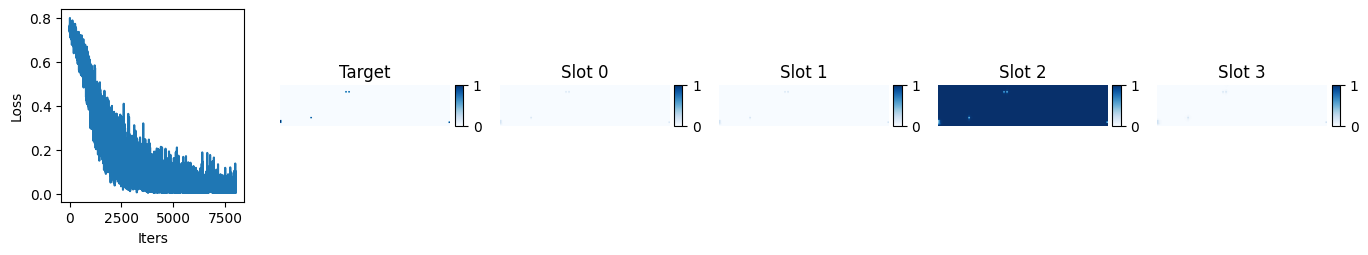

iter 8050 , loss 0.056659624 , lr 0.00027100538024970444


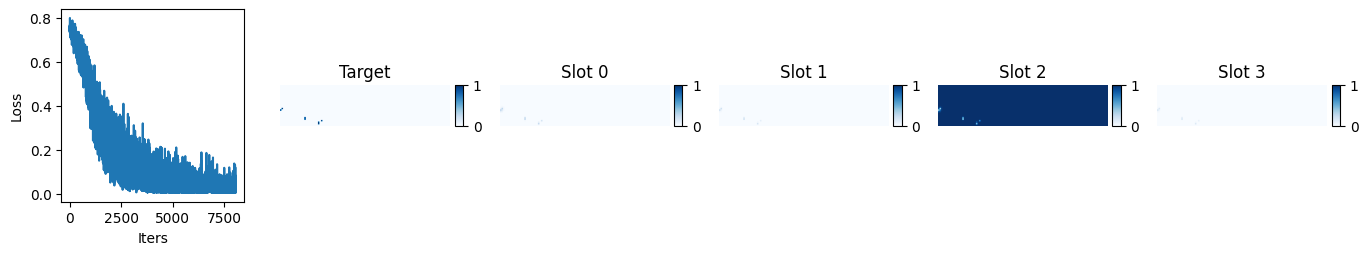

iter 8100 , loss 0.034341004 , lr 0.00027065634529051263


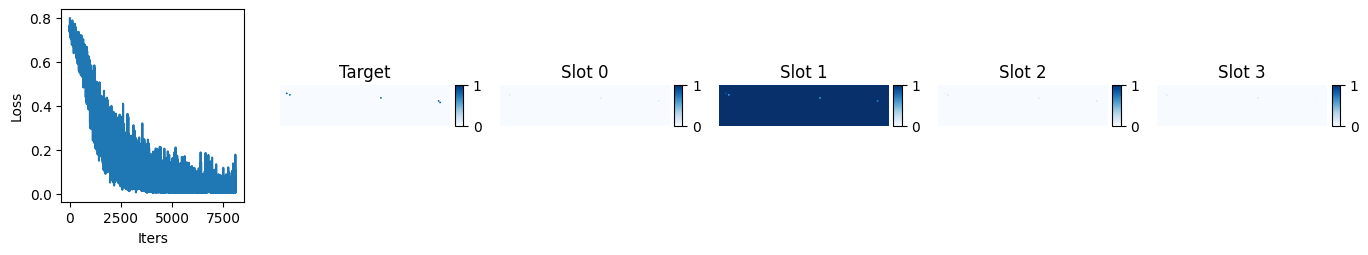

iter 8150 , loss 0.056887414 , lr 0.0002703054496612174


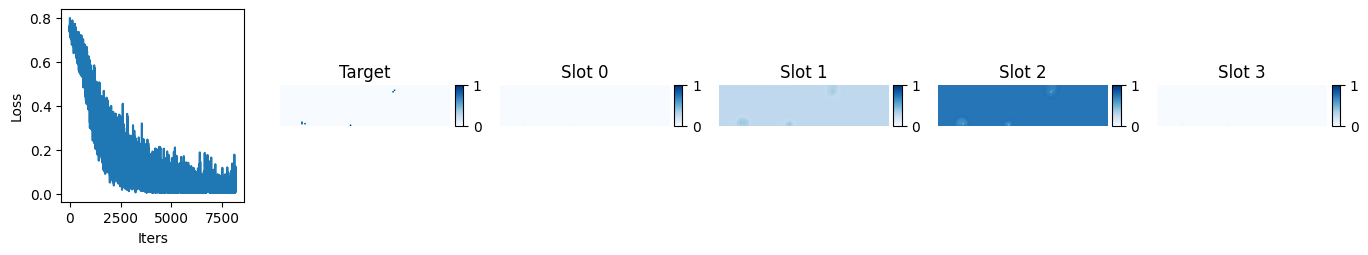

iter 8200 , loss 0.015401469 , lr 0.00026995269877306356


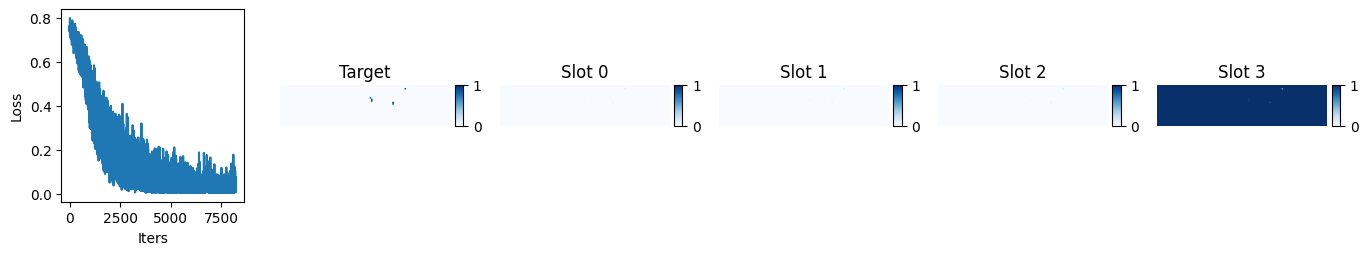

iter 8250 , loss 0.014800151 , lr 0.00026959809806590605


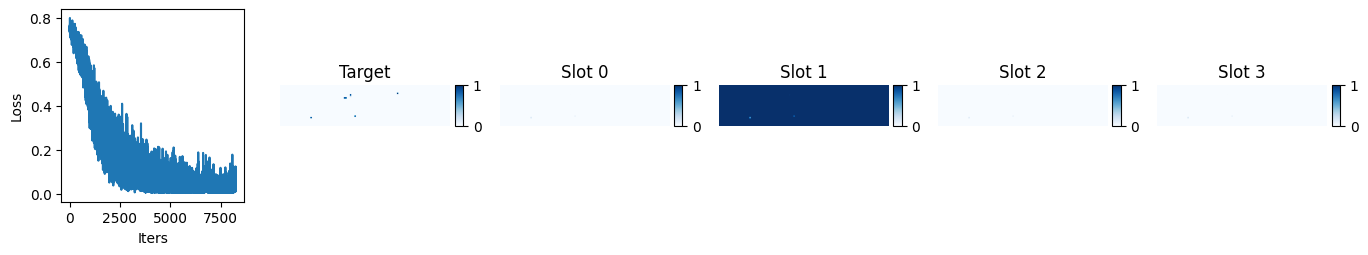

iter 8300 , loss 0.032333754 , lr 0.0002692416530081265


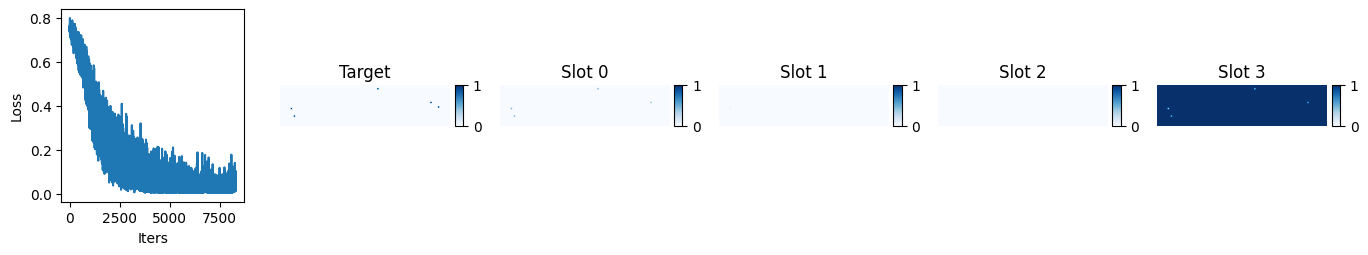

iter 8350 , loss 0.015450184 , lr 0.0002688833690965486


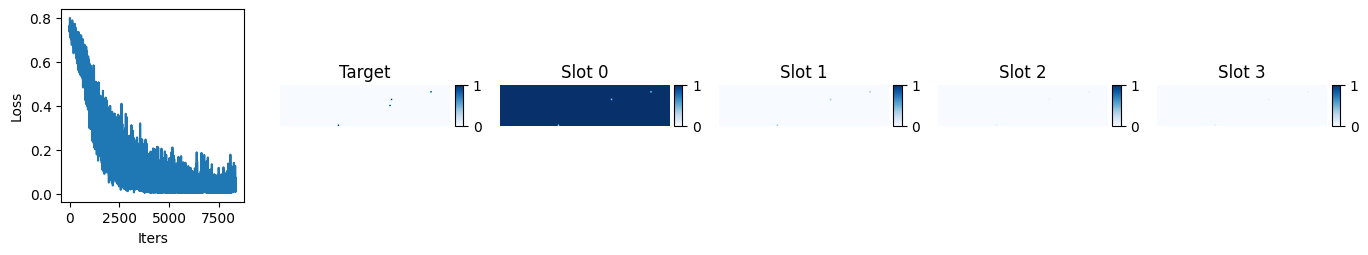

iter 8400 , loss 0.00583875 , lr 0.0002685232518563535


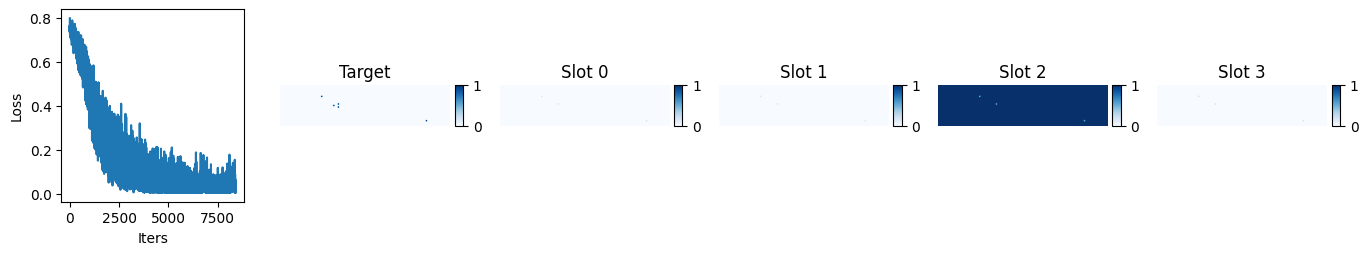

iter 8450 , loss 0.0065526715 , lr 0.0002681613068409946


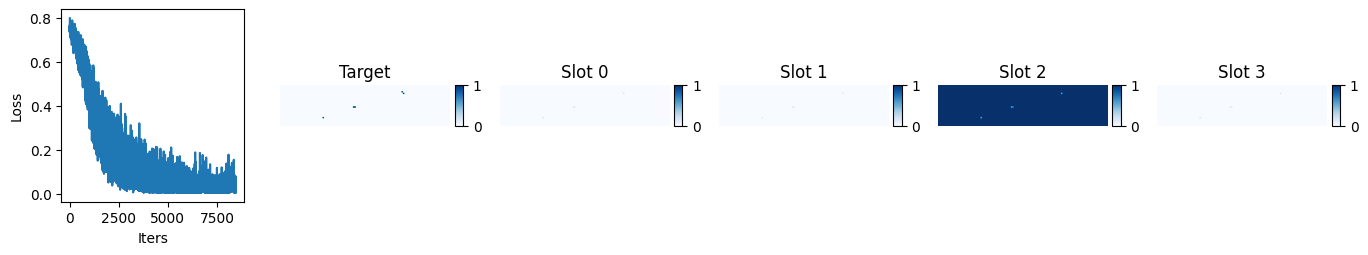

iter 8500 , loss 0.0071693906 , lr 0.0002677975396321117


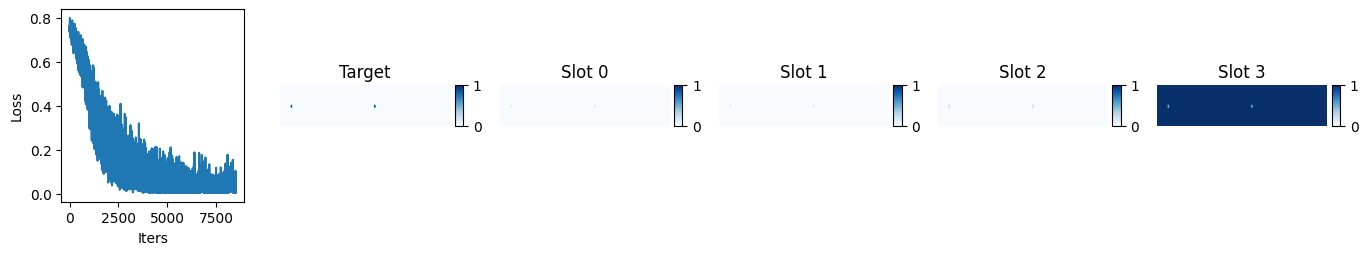

iter 8550 , loss 0.0061005154 , lr 0.00026743195583944524


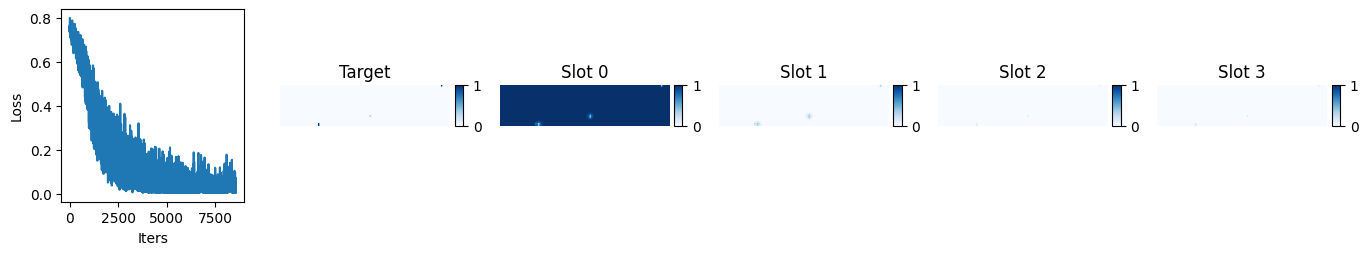

iter 8600 , loss 0.10575404 , lr 0.00026706456110074943


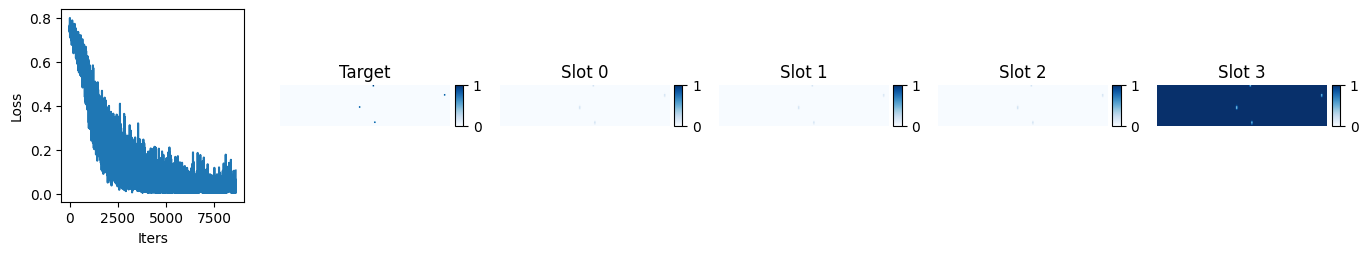

iter 8650 , loss 0.009847455 , lr 0.0002666953610817058


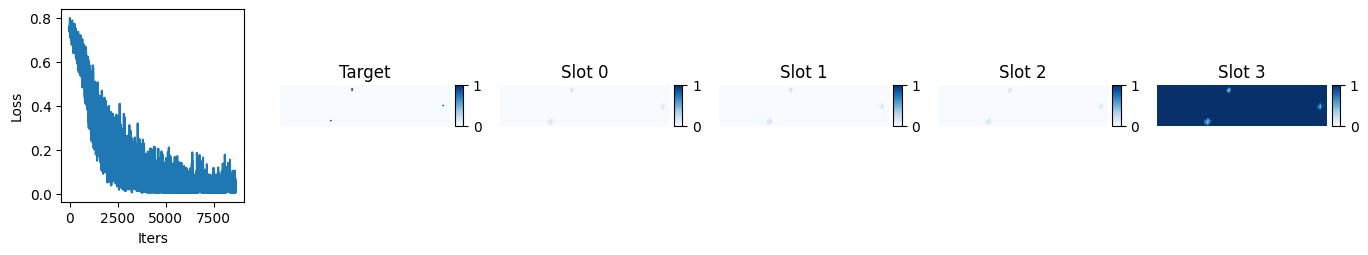

iter 8700 , loss 0.011998435 , lr 0.0002663243614758351


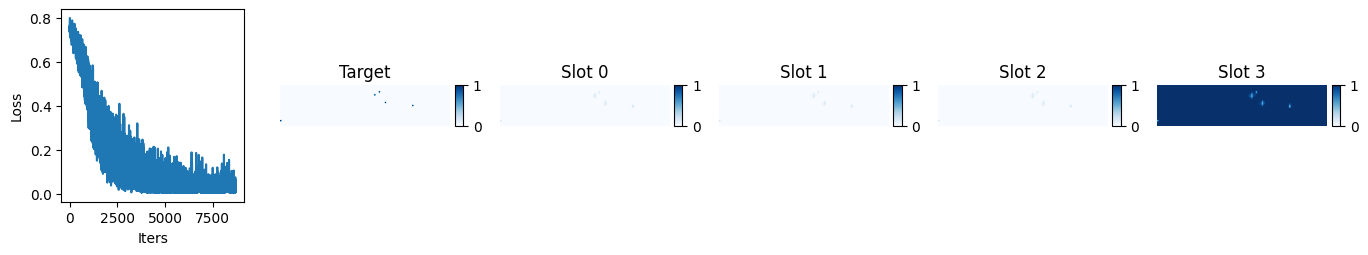

iter 8750 , loss 0.02041045 , lr 0.0002659515680044105


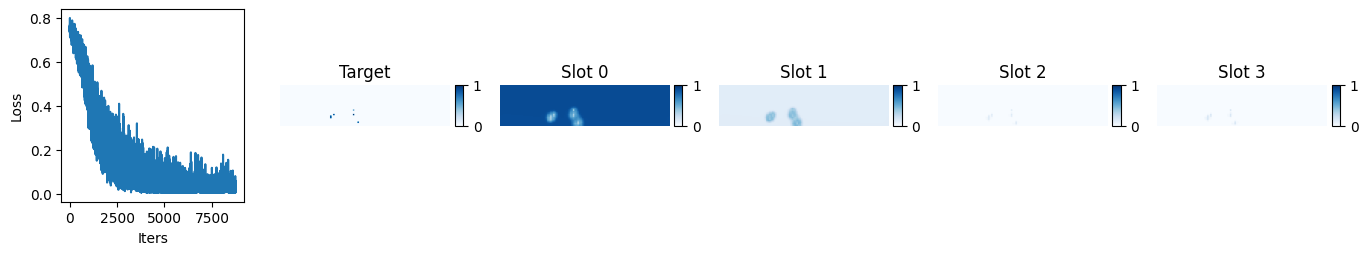

iter 8800 , loss 0.009132287 , lr 0.00026557698641636835


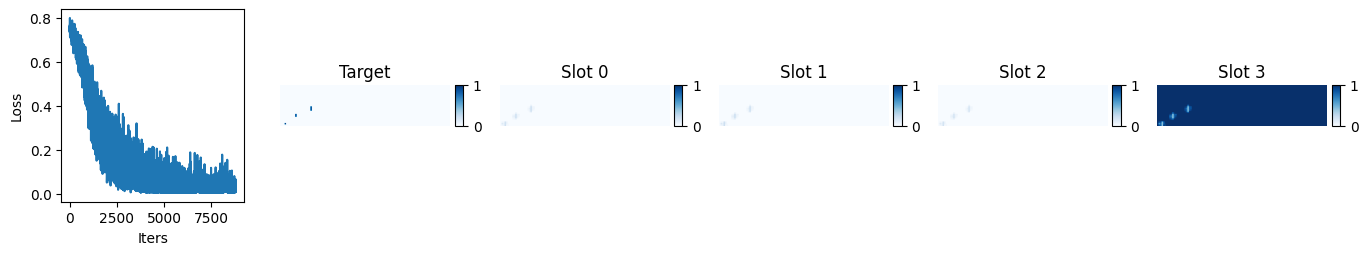

iter 8850 , loss 0.043105256 , lr 0.00026520062248822014


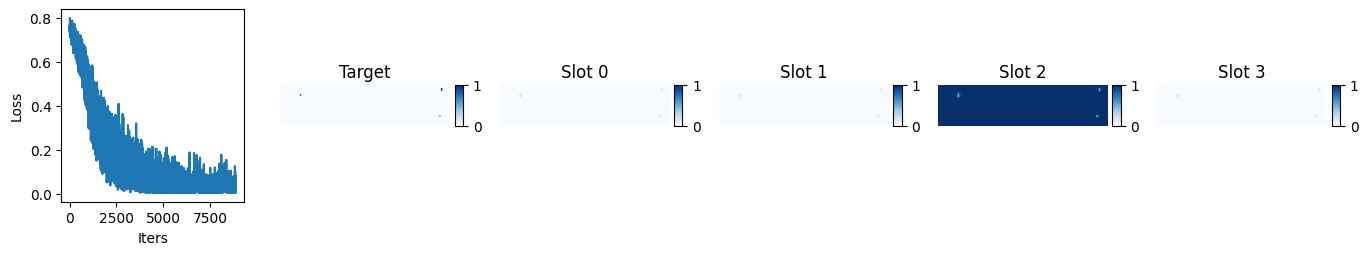

iter 8900 , loss 0.074521035 , lr 0.00026482248202396323


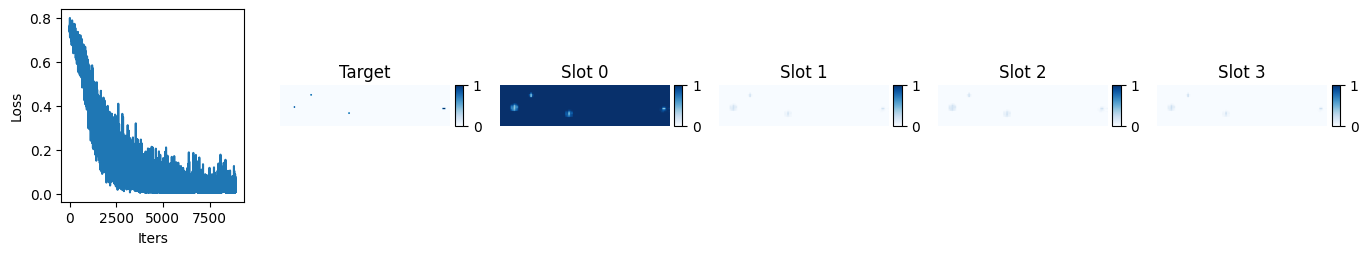

iter 8950 , loss 0.005666607 , lr 0.0002644425708549913


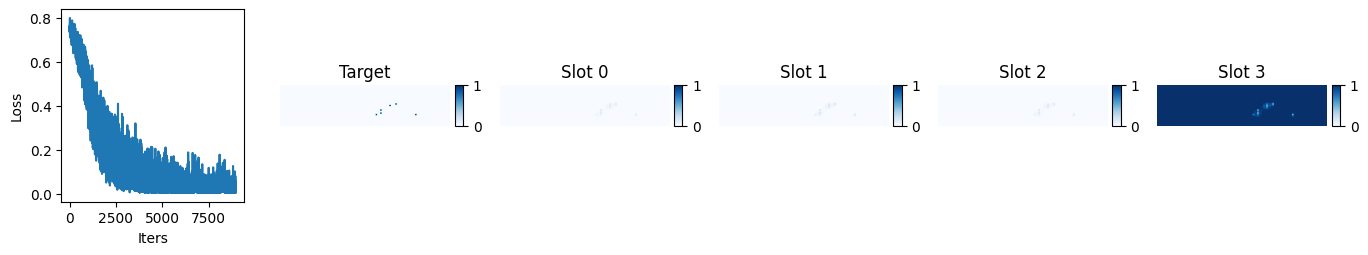

iter 9000 , loss 0.0064465874 , lr 0.00026406089484000466


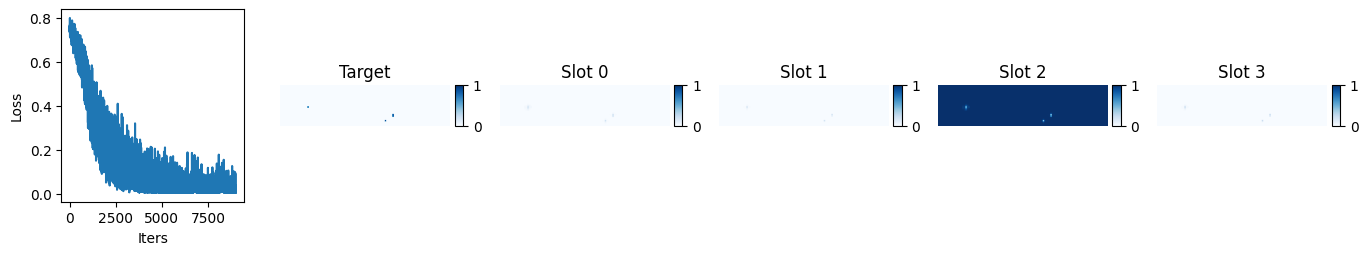

iter 9050 , loss 0.013182322 , lr 0.0002636774598649195


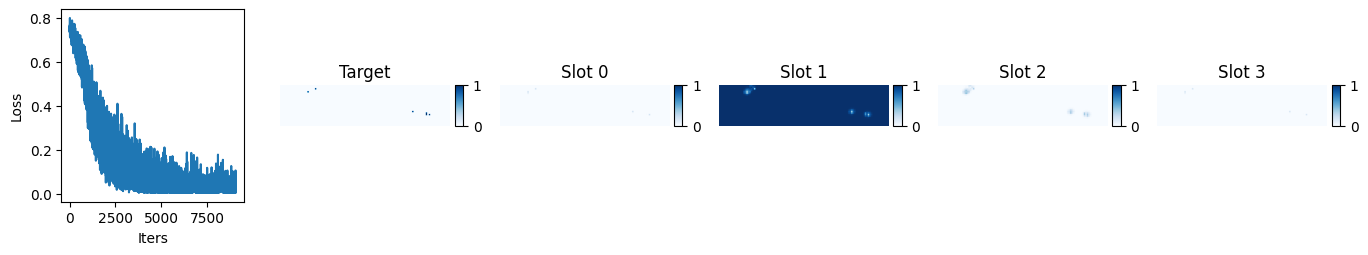

iter 9100 , loss 0.074345164 , lr 0.00026329227184277755


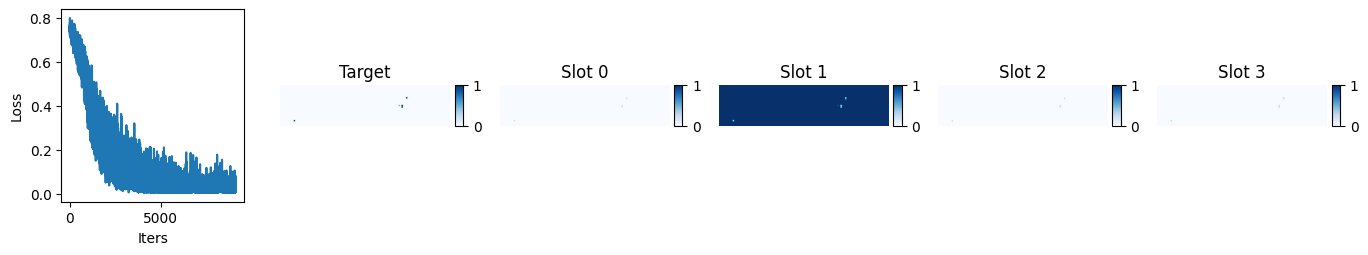

iter 9150 , loss 0.087971084 , lr 0.00026290533671365454


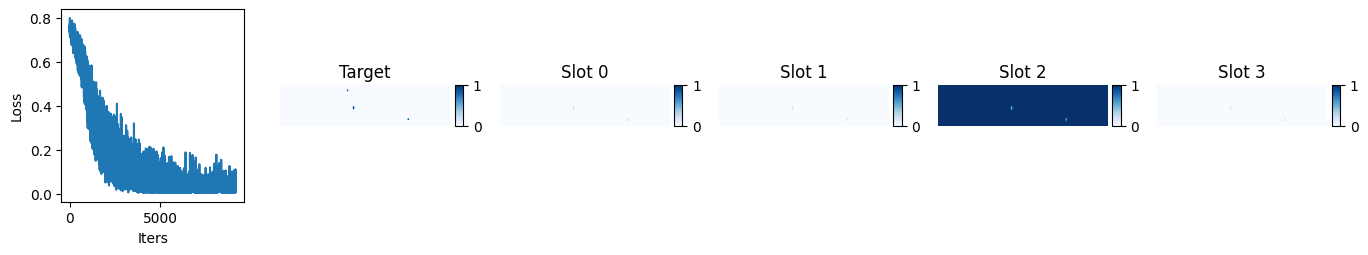

iter 9200 , loss 0.008697276 , lr 0.0002625166604445689


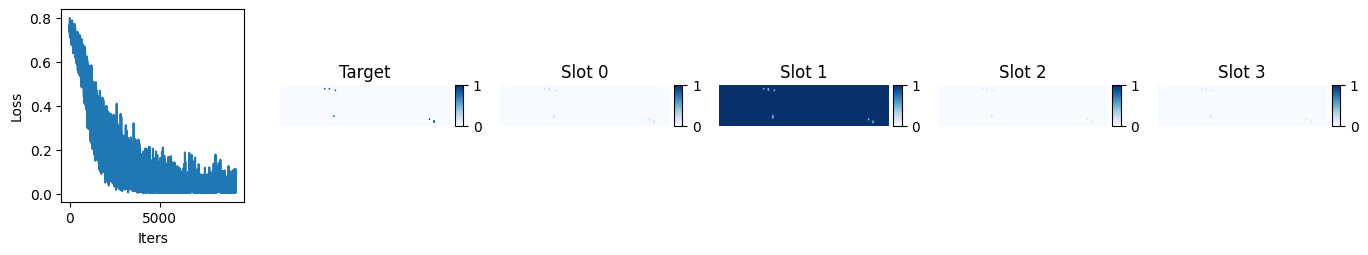

iter 9250 , loss 0.006753344 , lr 0.0002621262490293895


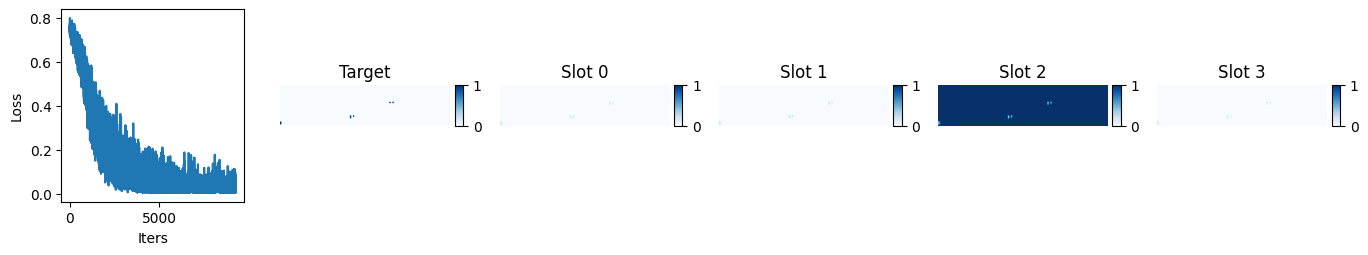

iter 9300 , loss 0.015836203 , lr 0.0002617341084887433


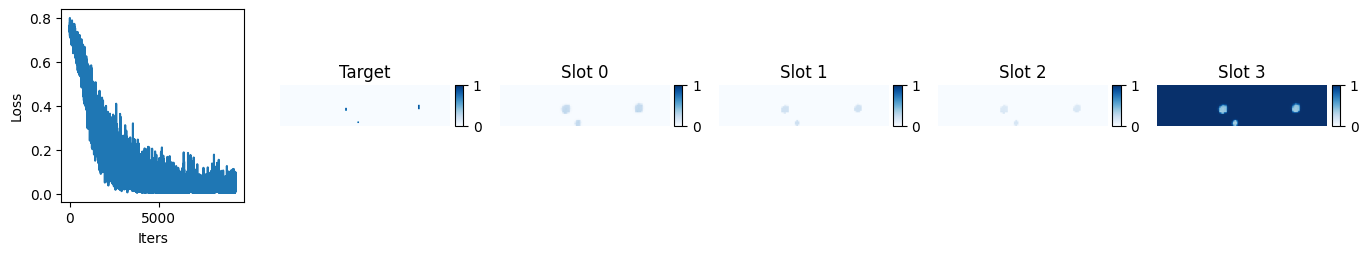

iter 9350 , loss 0.019921064 , lr 0.0002613402448699225


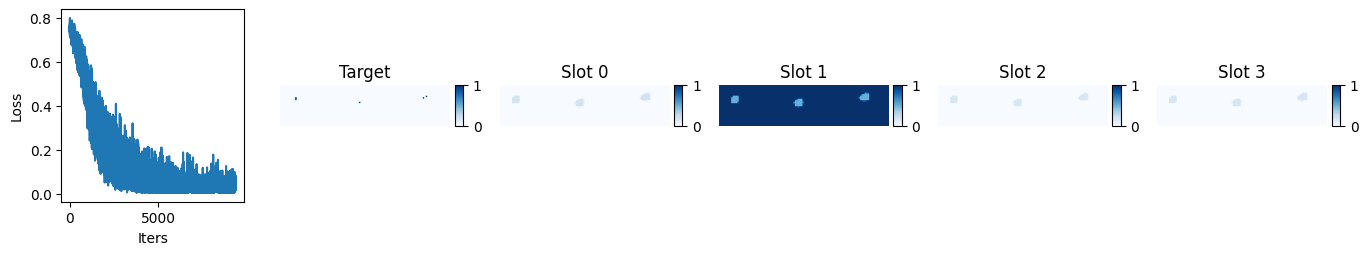

iter 9400 , loss 0.01694329 , lr 0.00026094466424679146


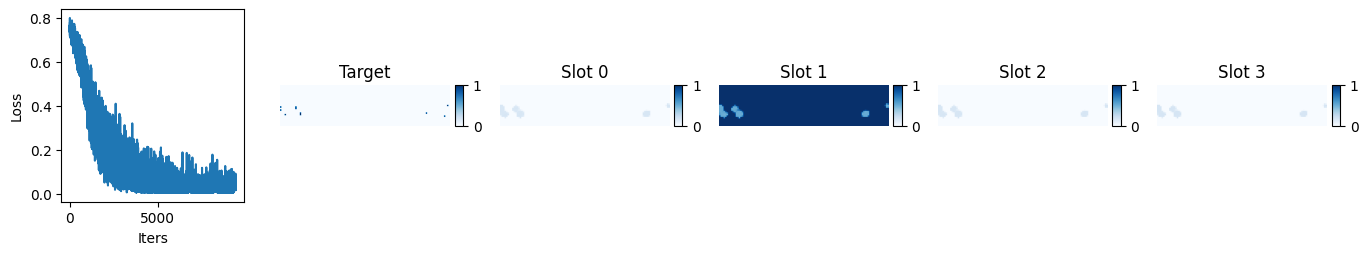

iter 9450 , loss 0.014120653 , lr 0.0002605473727196926


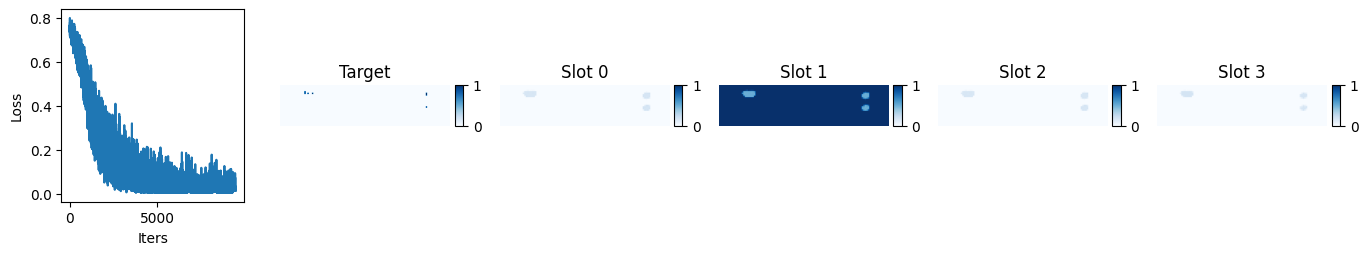

iter 9500 , loss 0.018185772 , lr 0.0002601483764153528


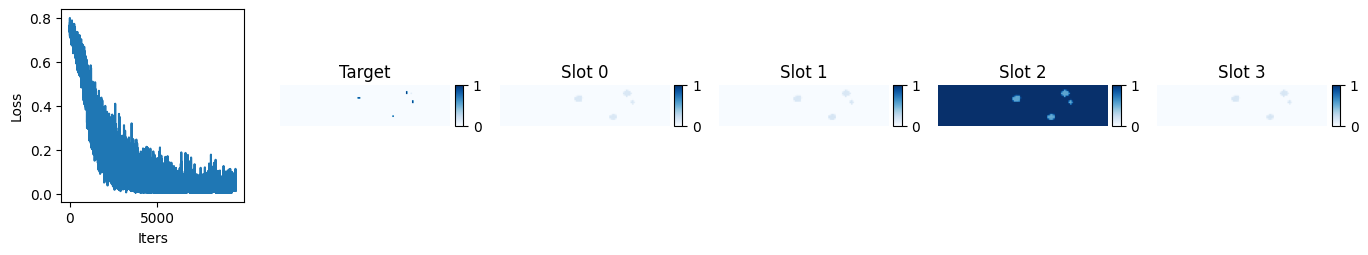

iter 9550 , loss 0.016177652 , lr 0.0002597476814867887


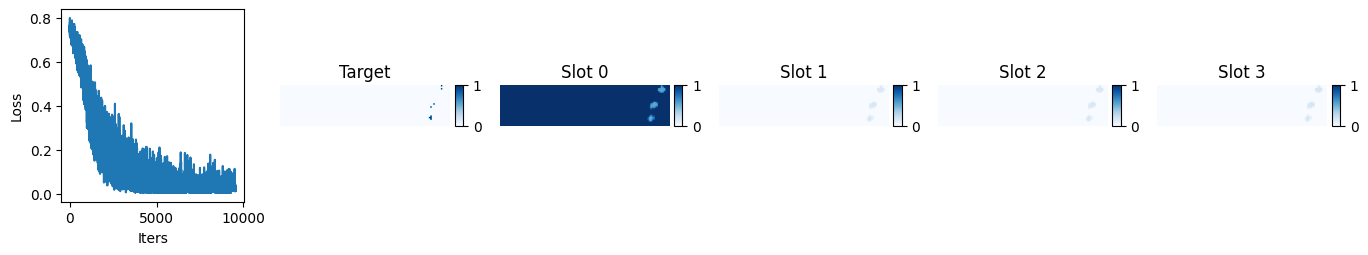

iter 9600 , loss 0.02737214 , lr 0.0002593452941132117


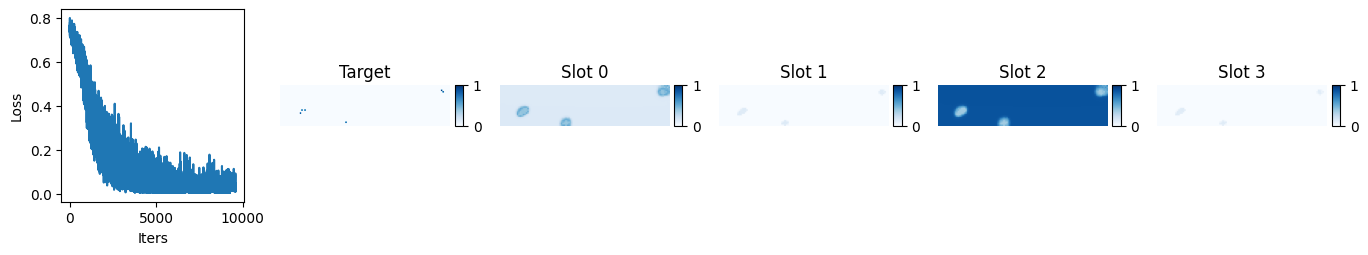

iter 9650 , loss 0.008155978 , lr 0.000258941220499933


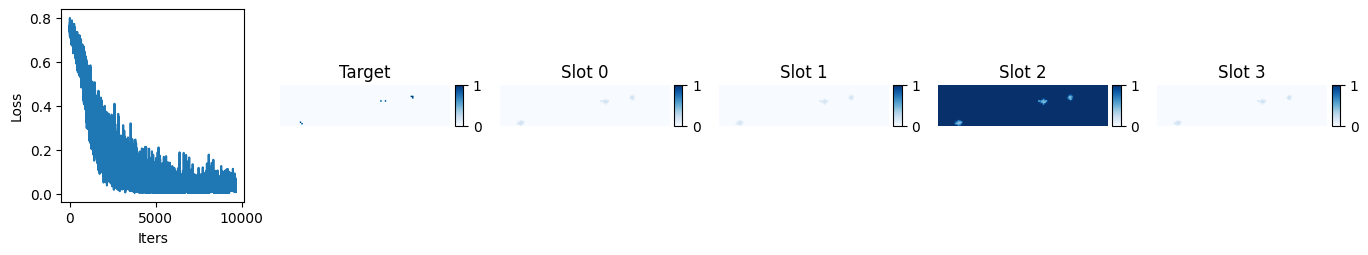

iter 9700 , loss 0.00879101 , lr 0.0002585354668782674


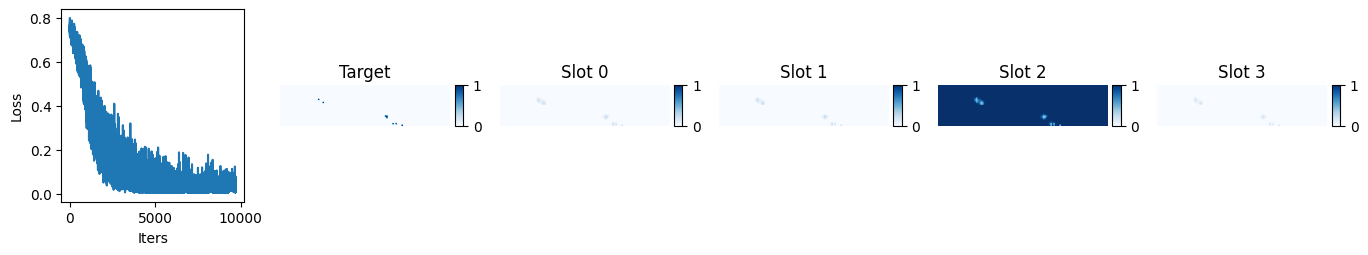

iter 9750 , loss 0.014530047 , lr 0.0002581280395054378


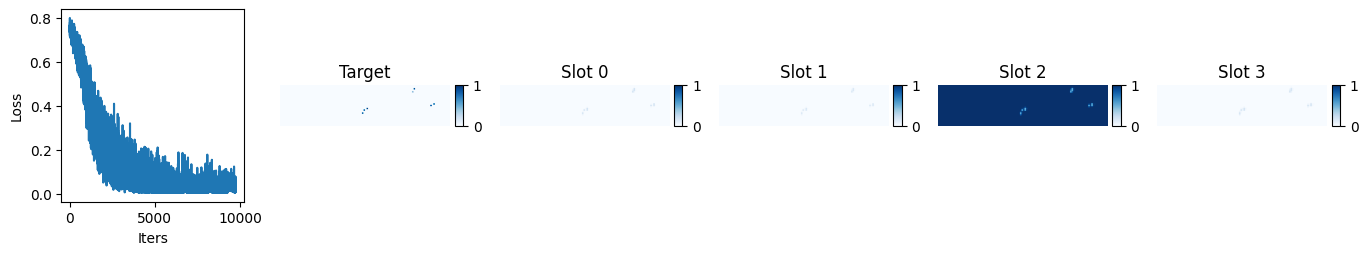

iter 9800 , loss 0.040527843 , lr 0.0002577189446644783


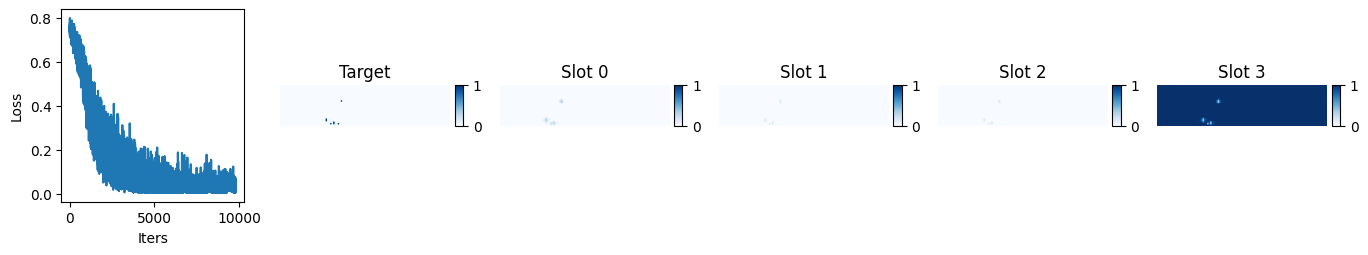

iter 9850 , loss 0.0149940895 , lr 0.0002573081886641374


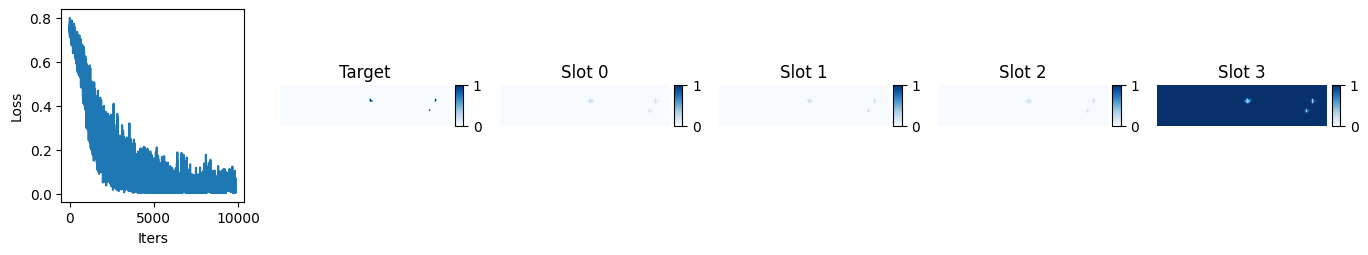

iter 9900 , loss 0.005884366 , lr 0.0002568957778387808


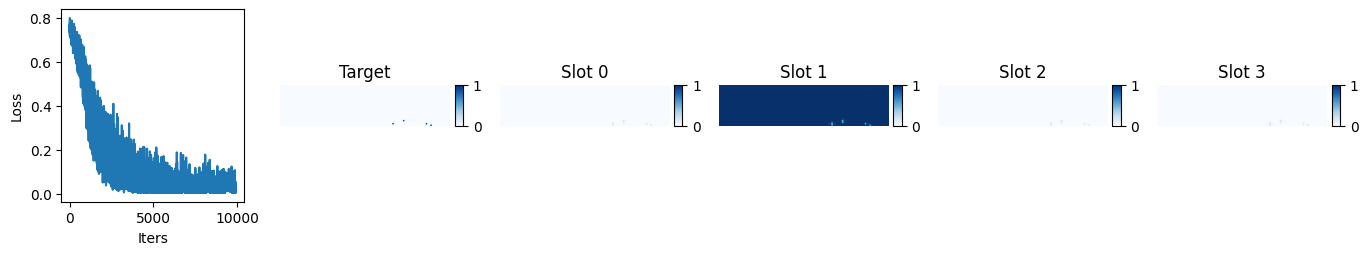

iter 9950 , loss 0.006067616 , lr 0.00025648171854829354


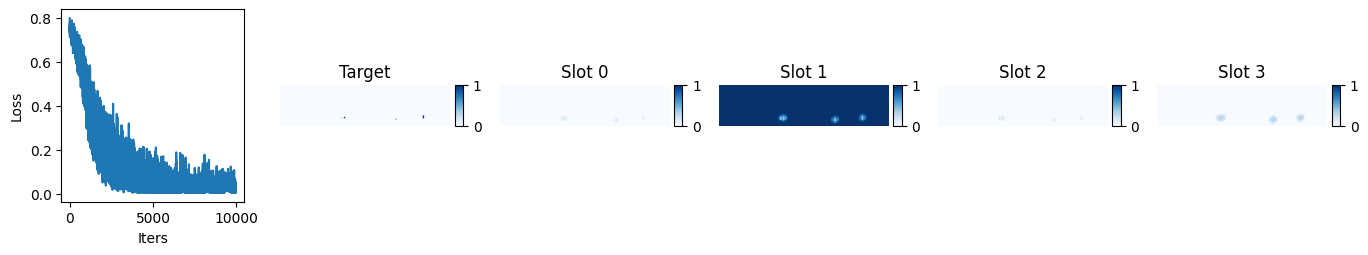

iter 10000 , loss 0.06689559 , lr 0.00025606601717798207


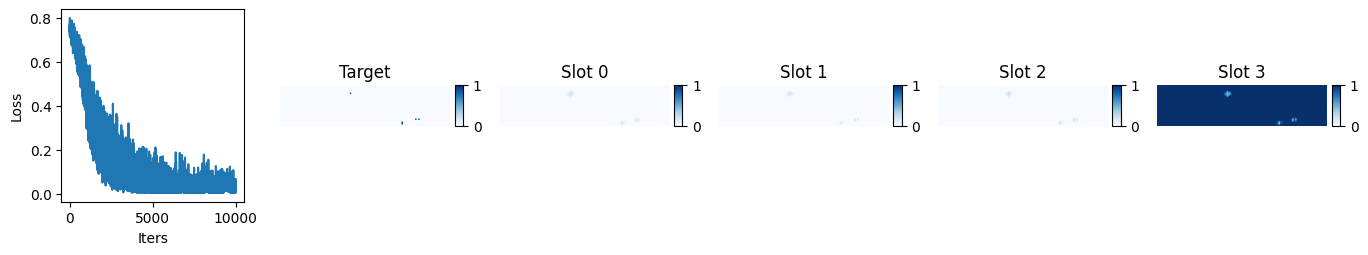

iter 10050 , loss 0.009555991 , lr 0.00025564868013847595


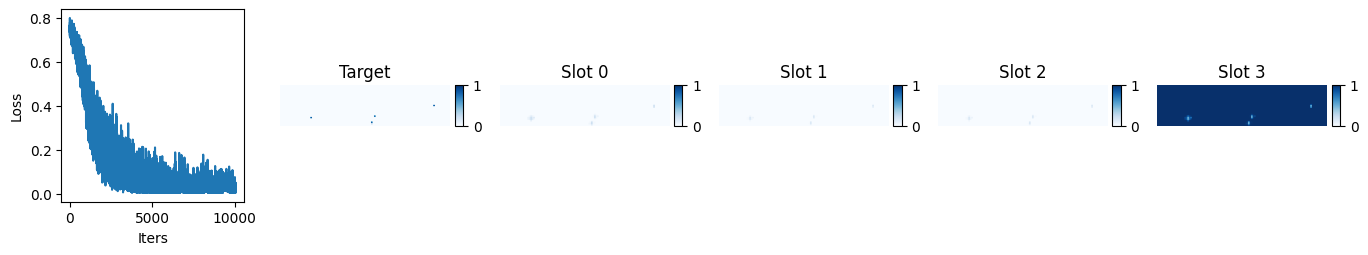

iter 10100 , loss 0.005567976 , lr 0.00025522971386562833


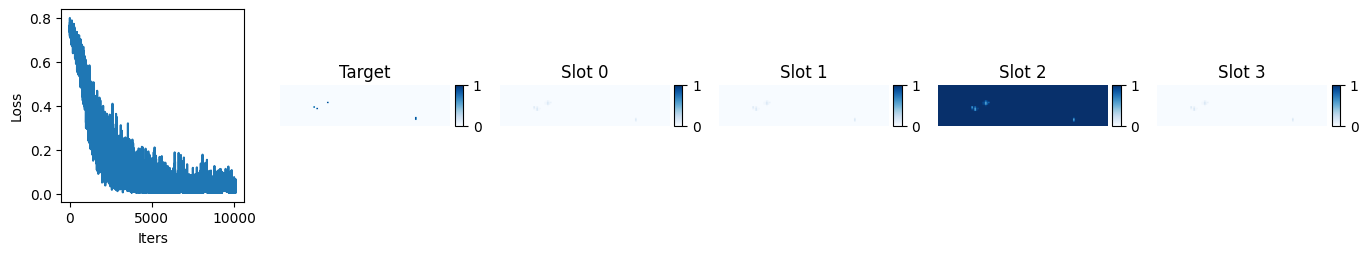

iter 10150 , loss 0.0056244726 , lr 0.0002548091248204176


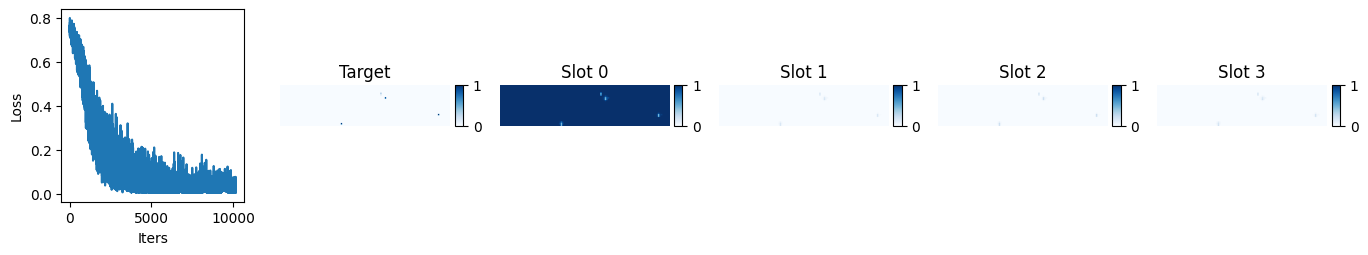

iter 10200 , loss 0.0064633307 , lr 0.0002543869194888471


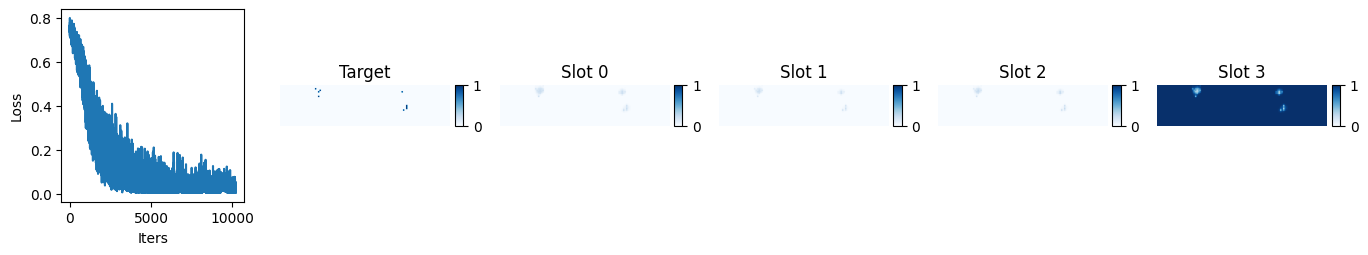

iter 10250 , loss 0.009536724 , lr 0.00025396310438184535


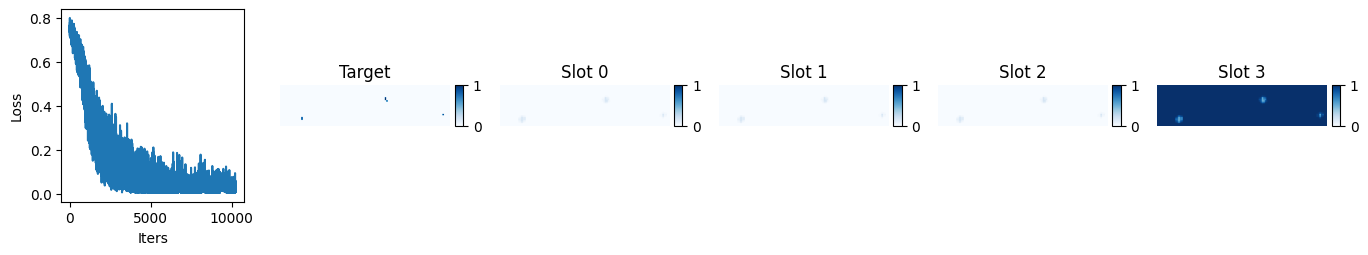

iter 10300 , loss 0.030561384 , lr 0.00025353768603516555


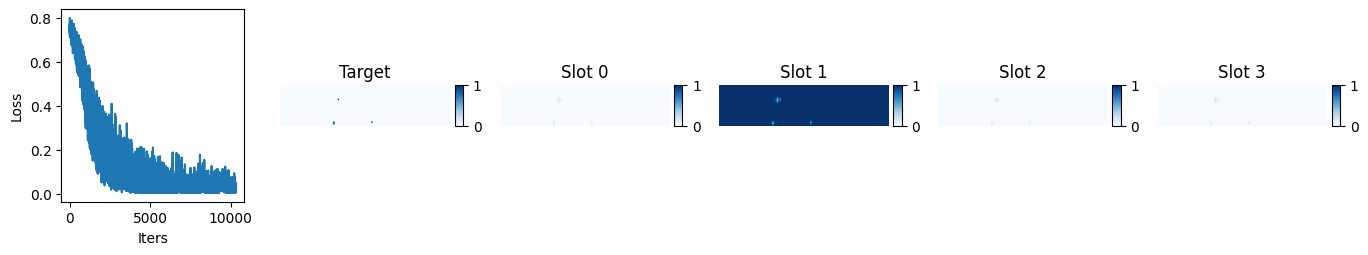

iter 10350 , loss 0.06377158 , lr 0.0002531106710092849


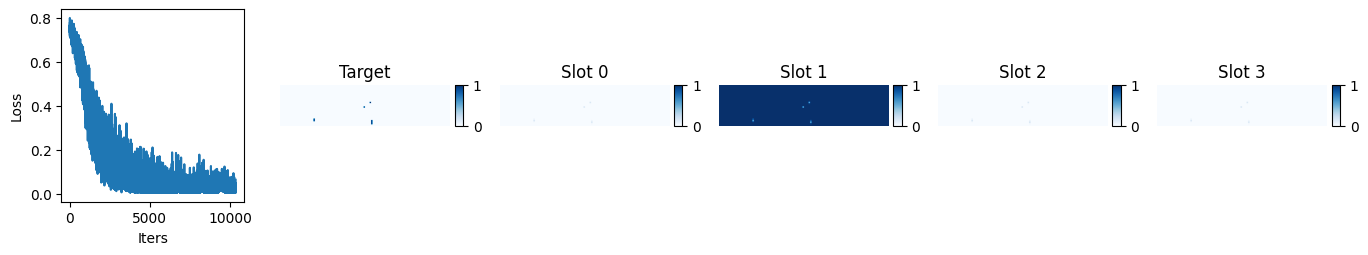

iter 10400 , loss 0.006371175 , lr 0.0002526820658893033


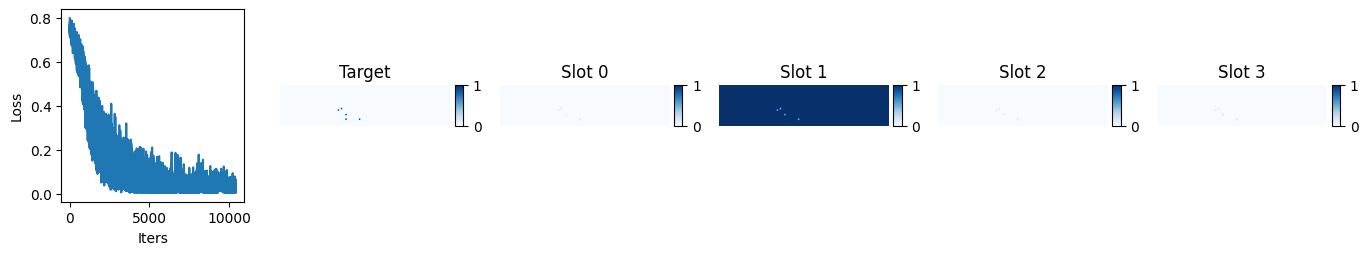

iter 10450 , loss 0.006205469 , lr 0.00025225187728484193


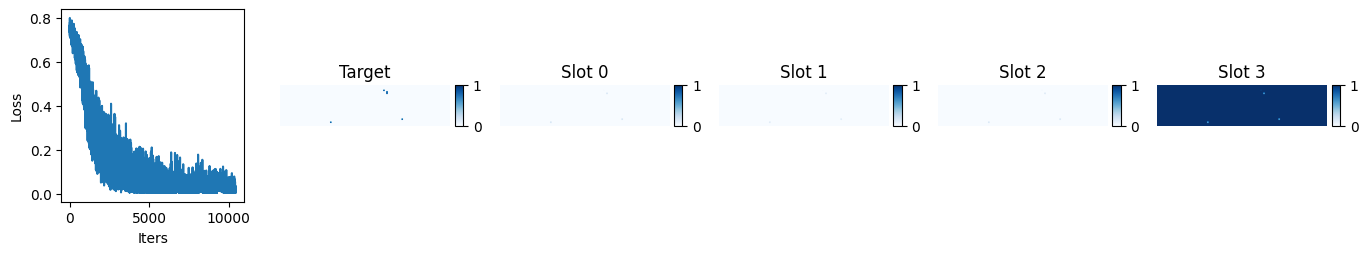

iter 10500 , loss 0.0097253295 , lr 0.0002518201118299413


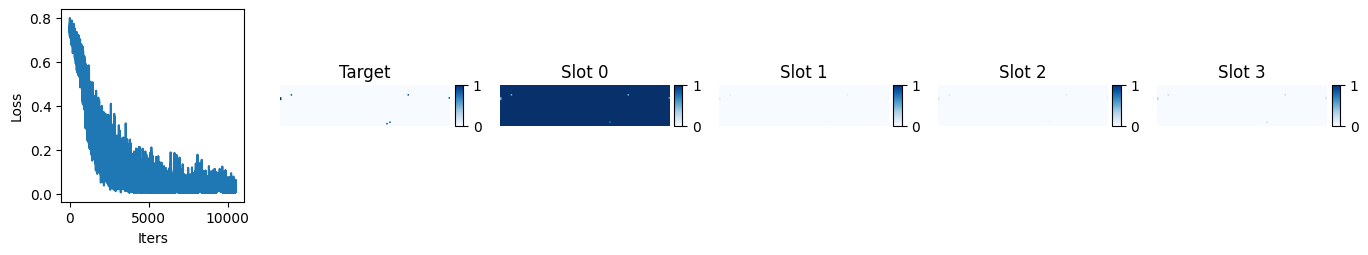

iter 10550 , loss 0.024316946 , lr 0.0002513867761829587


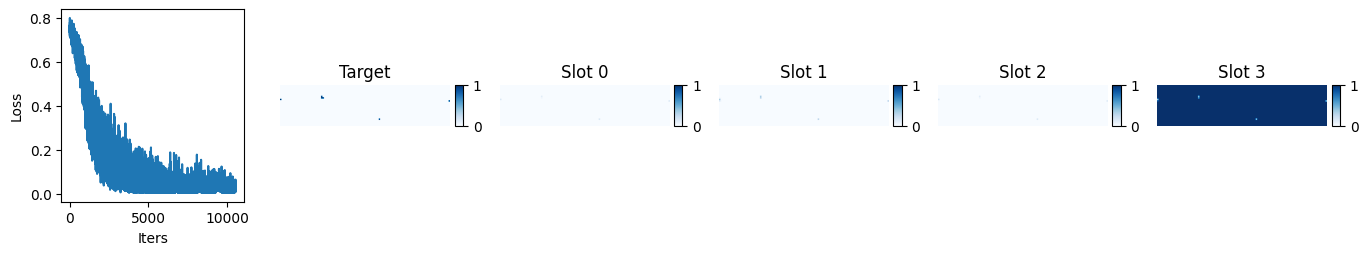

iter 10600 , loss 0.029309023 , lr 0.00025095187702646595


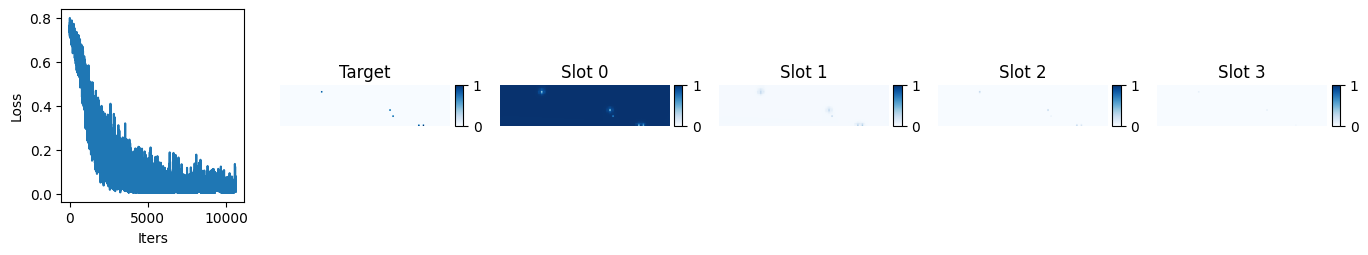

iter 10650 , loss 0.0069605615 , lr 0.00025051542106714614


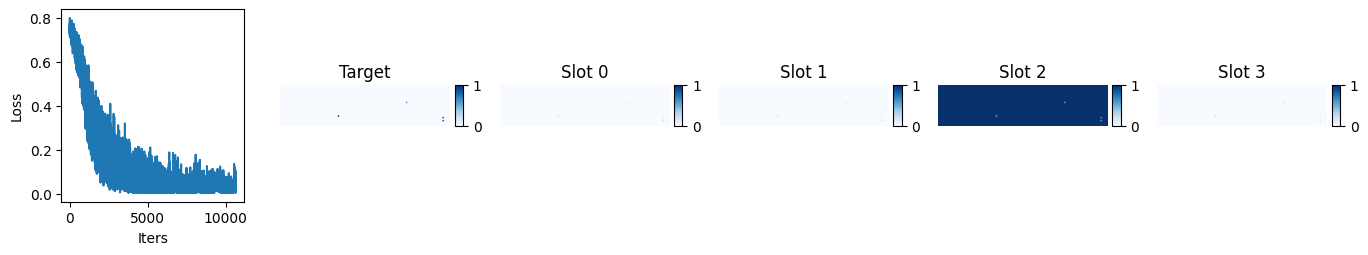

iter 10700 , loss 0.021220105 , lr 0.0002500774150356899


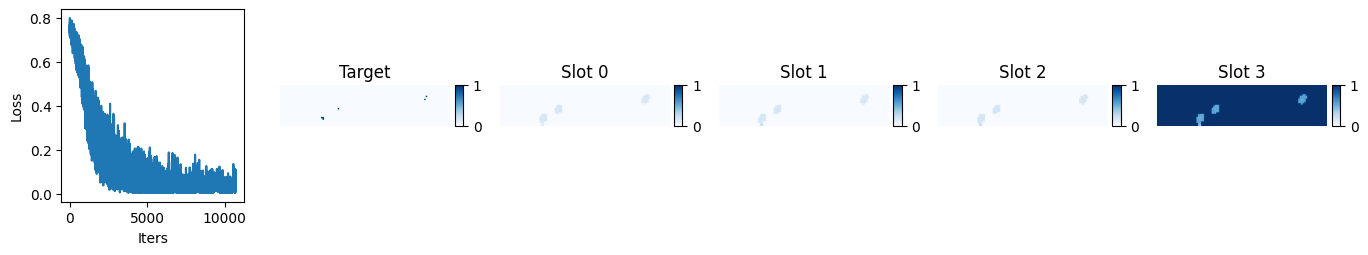

iter 10750 , loss 0.059386984 , lr 0.00024963786568669223


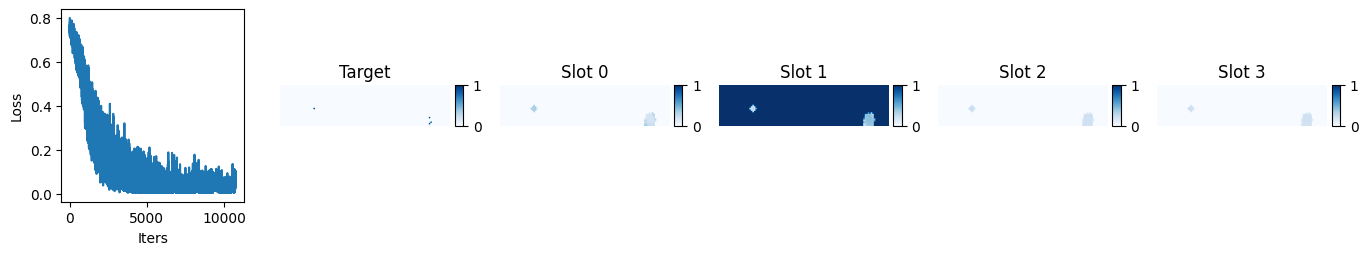

iter 10800 , loss 0.018282365 , lr 0.00024919677979854776


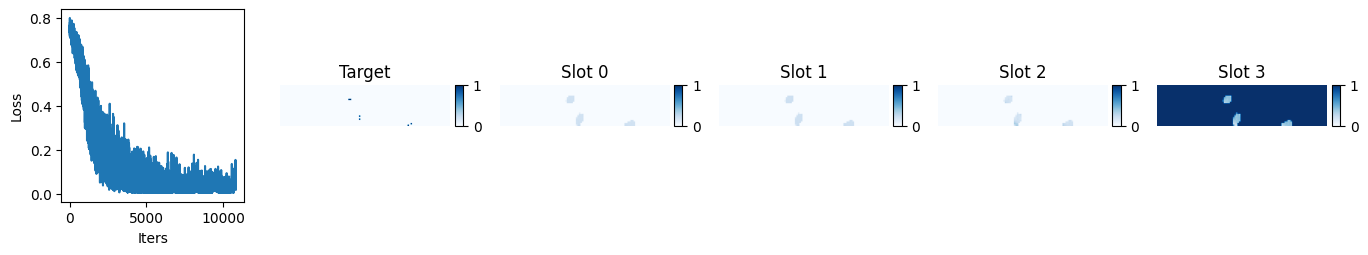

iter 10850 , loss 0.030261336 , lr 0.00024875416417334653


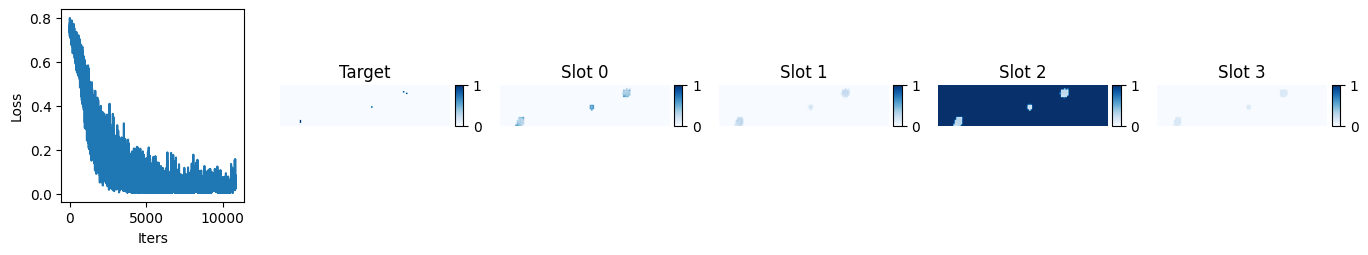

iter 10900 , loss 0.042393837 , lr 0.00024831002563676903


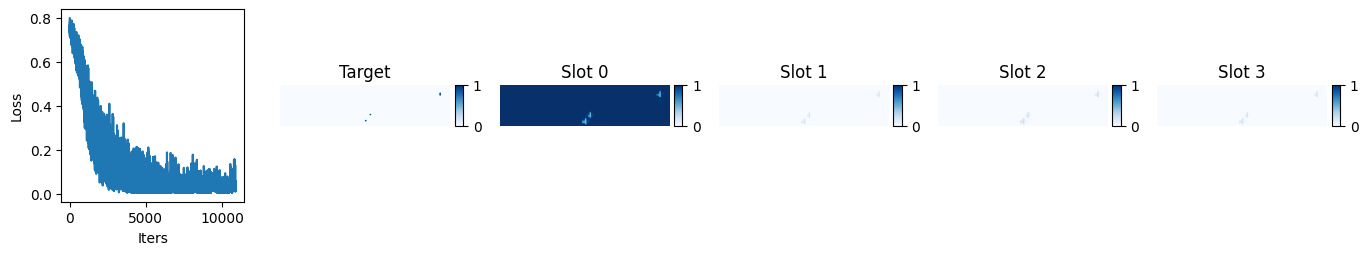

iter 10950 , loss 0.022578616 , lr 0.00024786437103798103


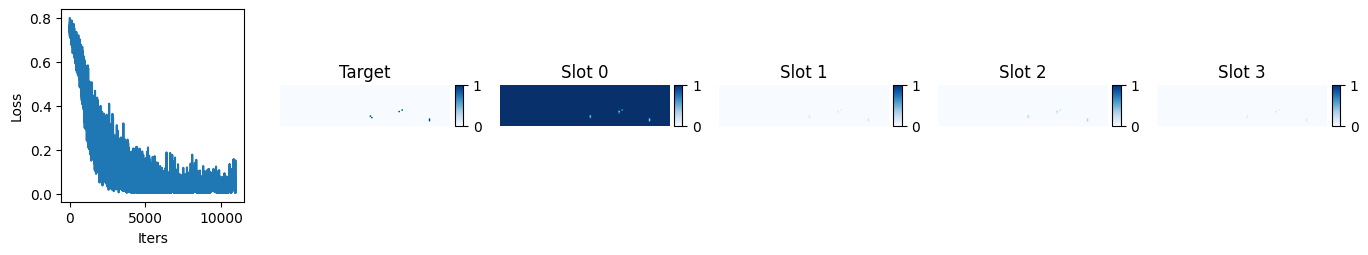

iter 11000 , loss 0.056655332 , lr 0.00024741720724952754


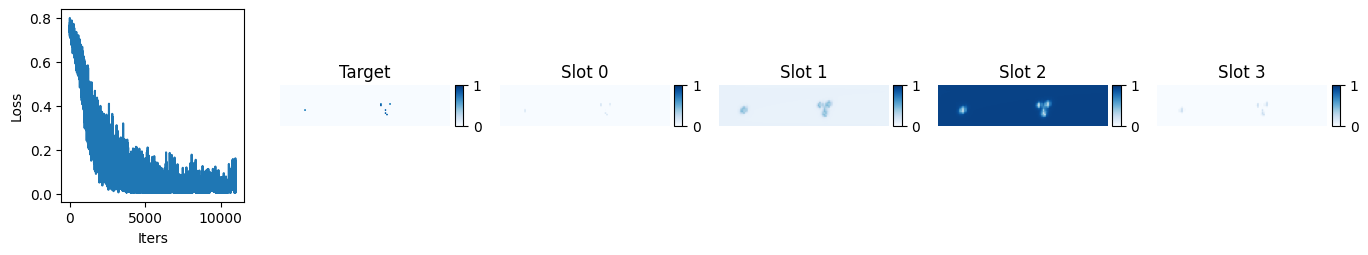

iter 11050 , loss 0.0058662 , lr 0.00024696854116722743


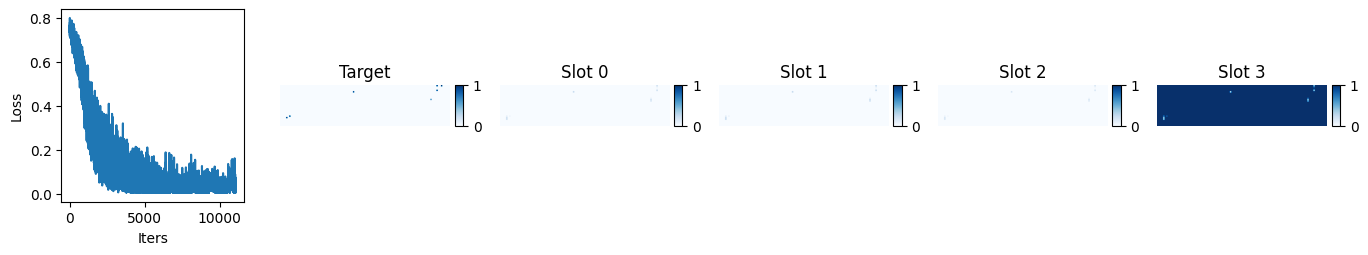

iter 11100 , loss 0.0075938664 , lr 0.00024651837971006687


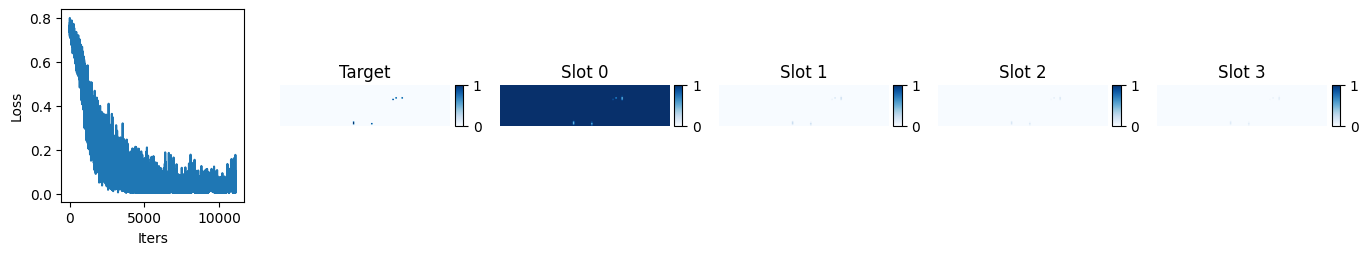

iter 11150 , loss 0.083959475 , lr 0.00024606672982009214


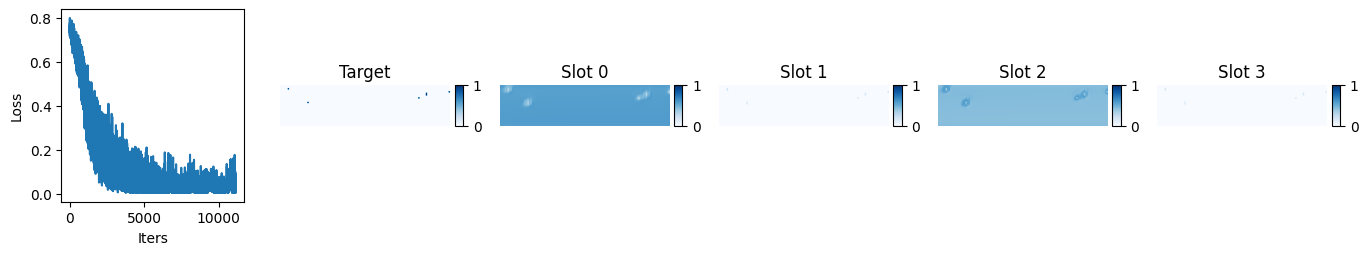

iter 11200 , loss 0.00611337 , lr 0.0002456135984623034


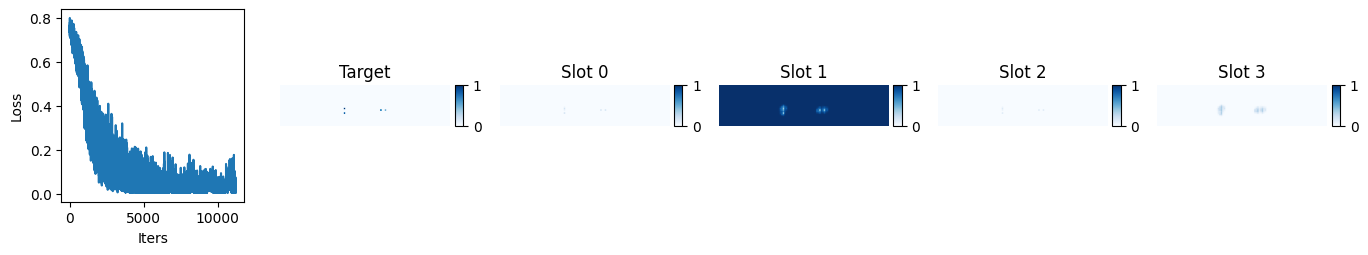

iter 11250 , loss 0.007463181 , lr 0.0002451589926245468


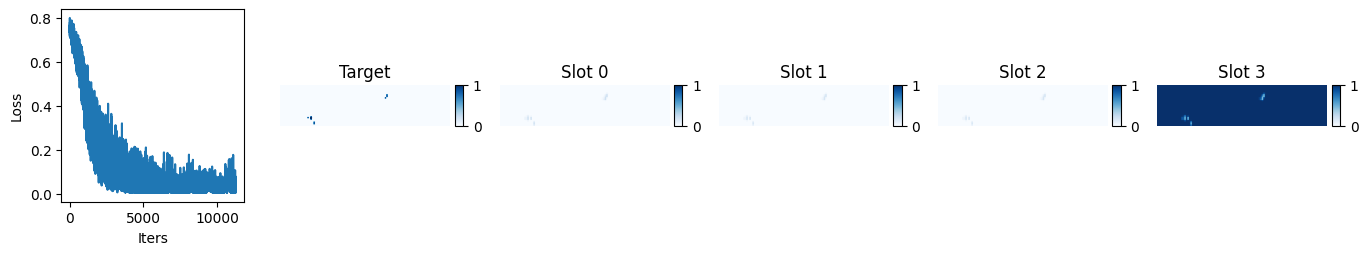

iter 11300 , loss 0.04333304 , lr 0.0002447029193174066


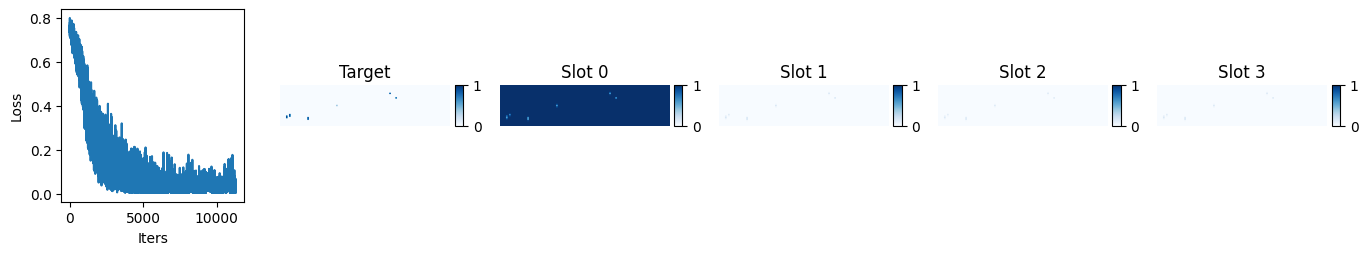

iter 11350 , loss 0.05609579 , lr 0.00024424538557409753


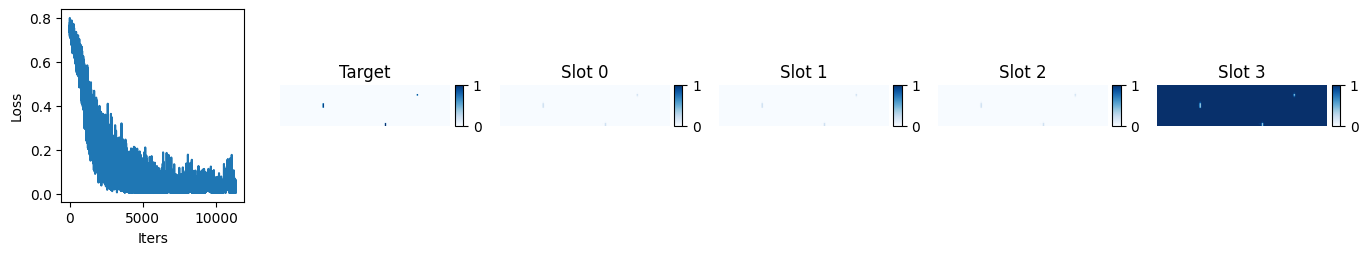

iter 11400 , loss 0.005569591 , lr 0.00024378639845035579


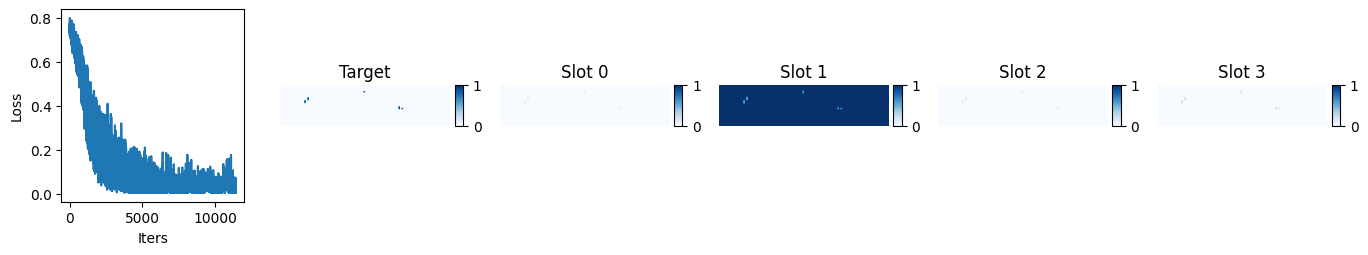

iter 11450 , loss 0.011691741 , lr 0.00024332596502433057


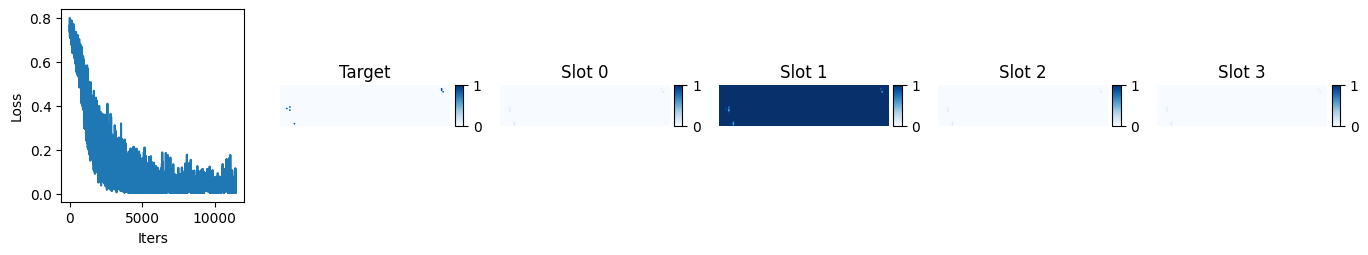

iter 11500 , loss 0.023078911 , lr 0.00024286409239647507


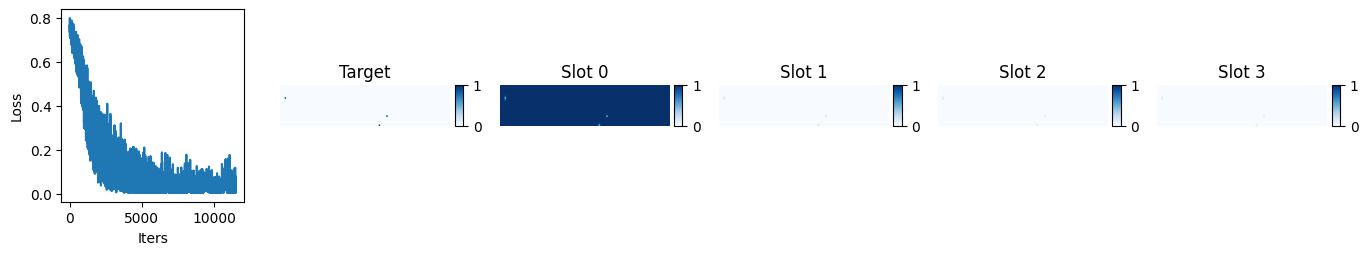

iter 11550 , loss 0.0056215585 , lr 0.00024240078768943647


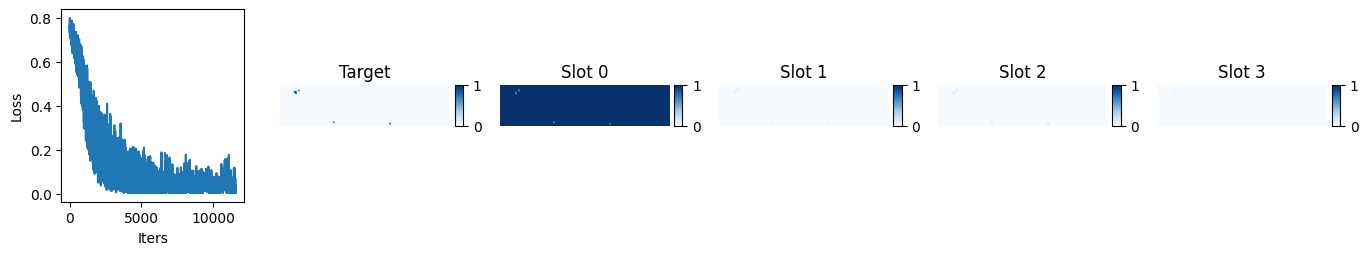

iter 11600 , loss 0.04208578 , lr 0.00024193605804794646


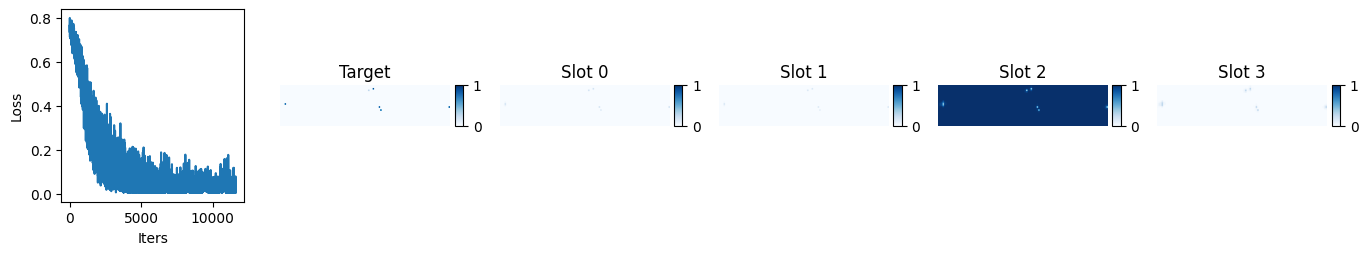

iter 11650 , loss 0.0080951955 , lr 0.00024146991063871107


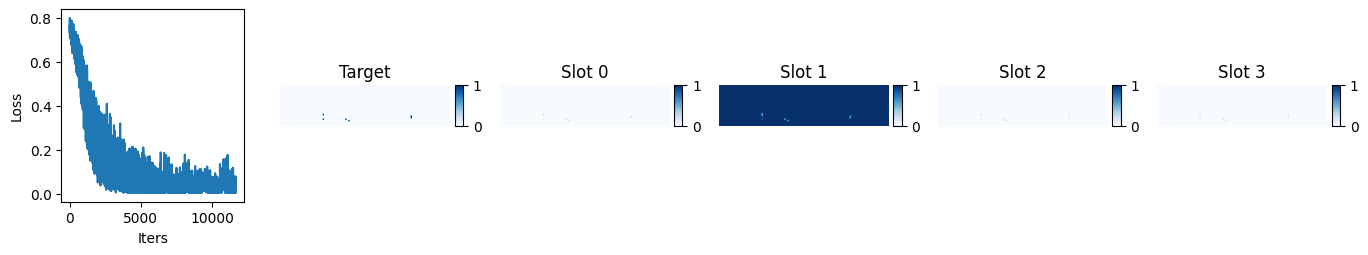

iter 11700 , loss 0.045662537 , lr 0.00024100235265029992


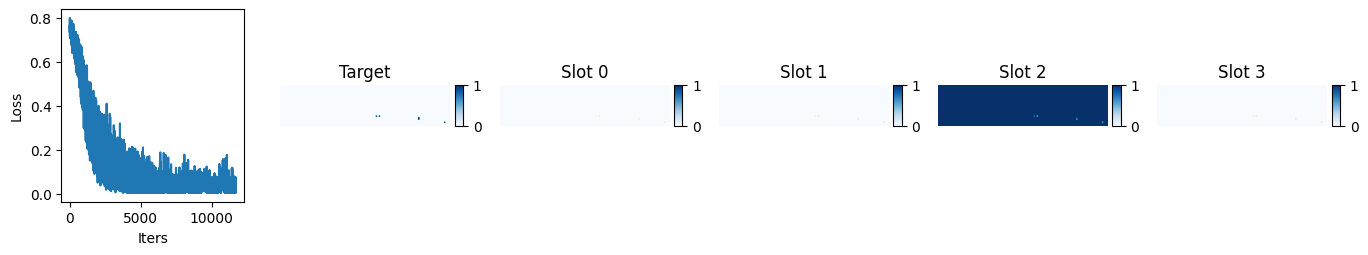

iter 11750 , loss 0.007899364 , lr 0.0002405333912930357


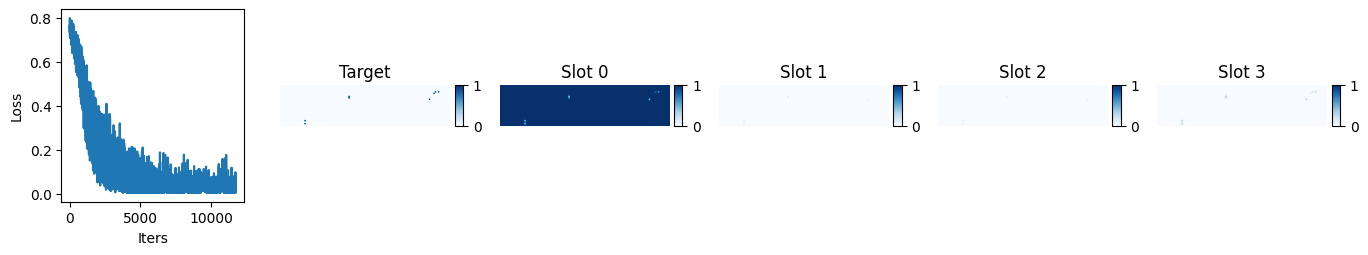

iter 11800 , loss 0.0076633547 , lr 0.0002400630337988826


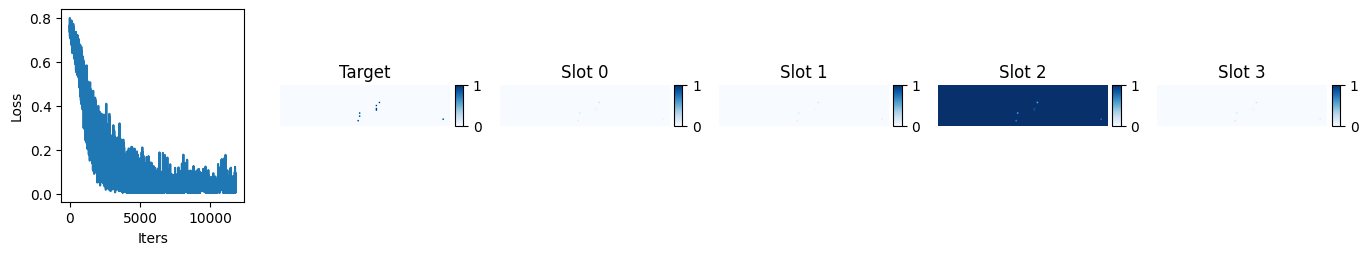

iter 11850 , loss 0.0057680956 , lr 0.00023959128742133504


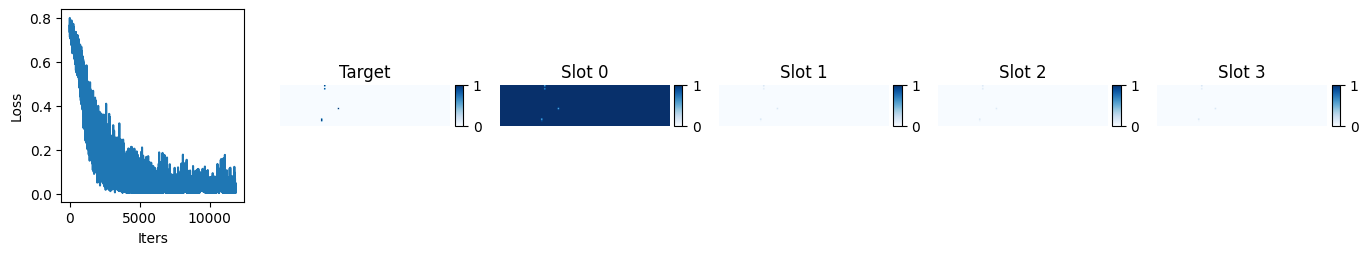

iter 11900 , loss 0.0070190853 , lr 0.00023911815943530577


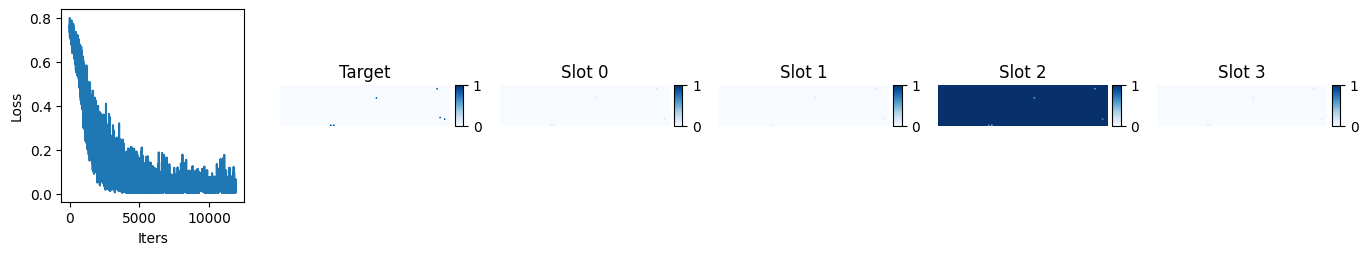

iter 11950 , loss 0.00813063 , lr 0.00023864365713701356


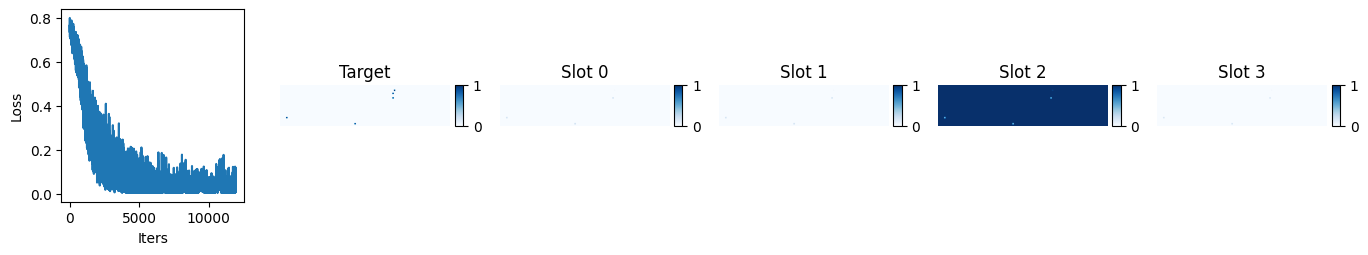

iter 12000 , loss 0.01060404 , lr 0.00023816778784387094


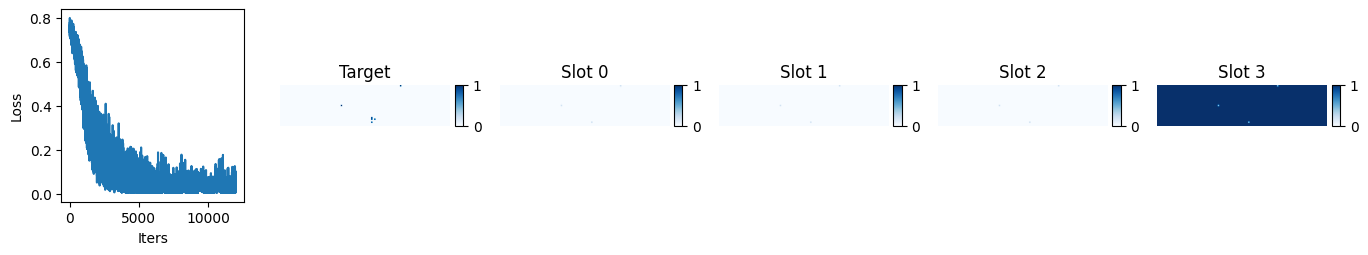

iter 12050 , loss 0.008998062 , lr 0.00023769055889437103


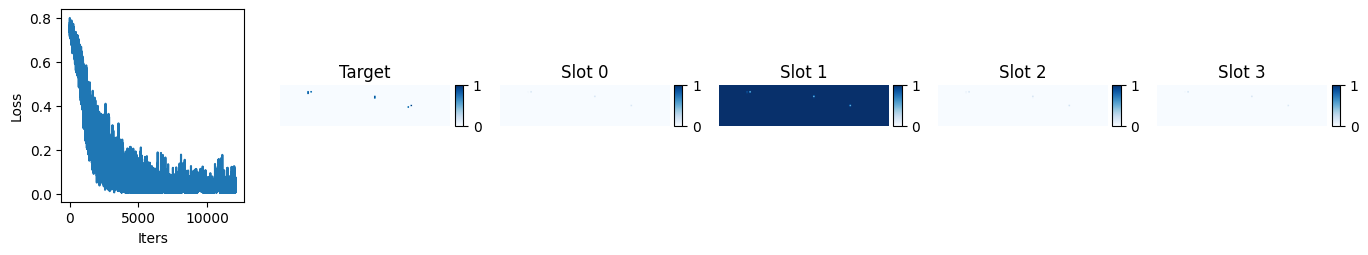

iter 12100 , loss 0.05092125 , lr 0.00023721197764797454


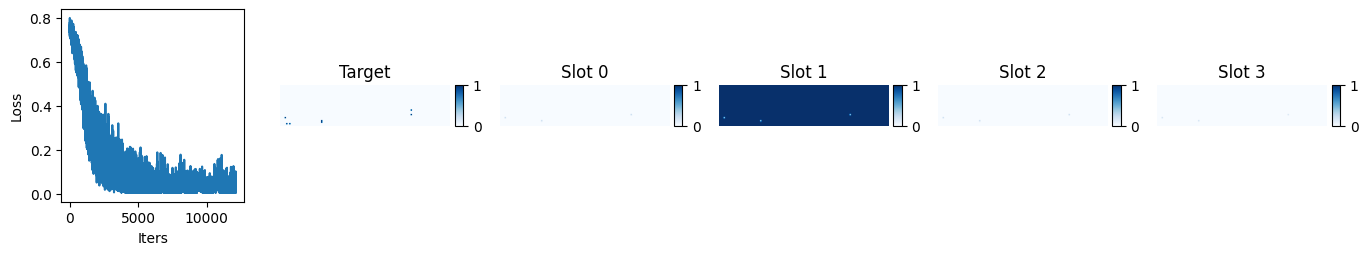

iter 12150 , loss 0.005321786 , lr 0.00023673205148499644


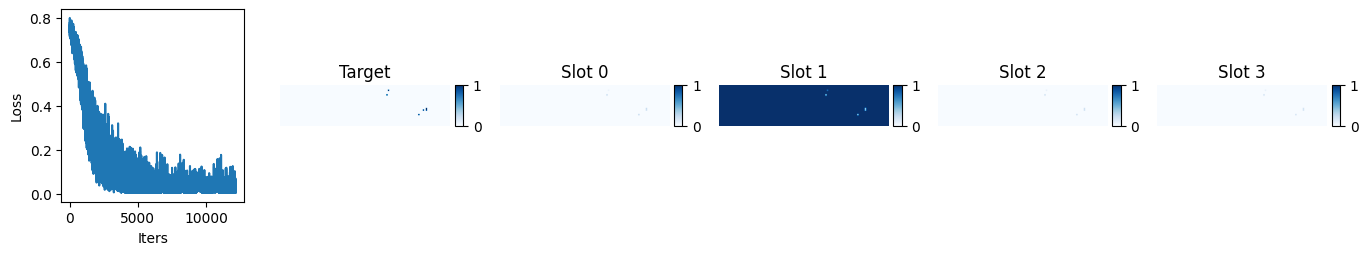

iter 12200 , loss 0.005193067 , lr 0.00023625078780649178


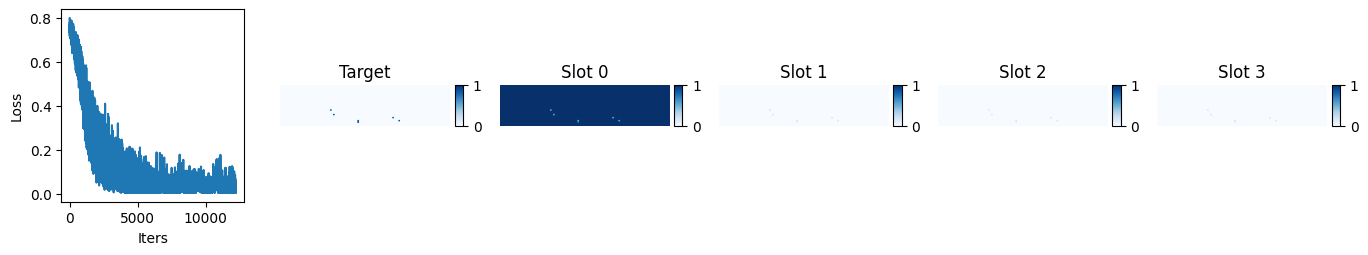

iter 12250 , loss 0.012854581 , lr 0.0002357681940341418


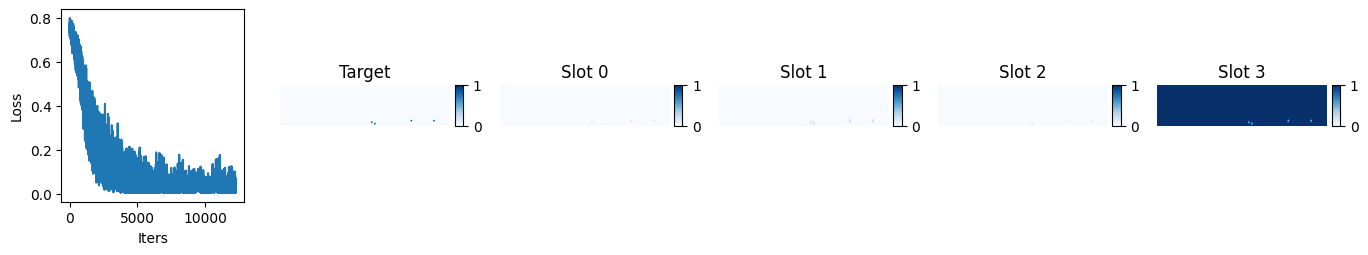

iter 12300 , loss 0.012029452 , lr 0.00023528427761013962


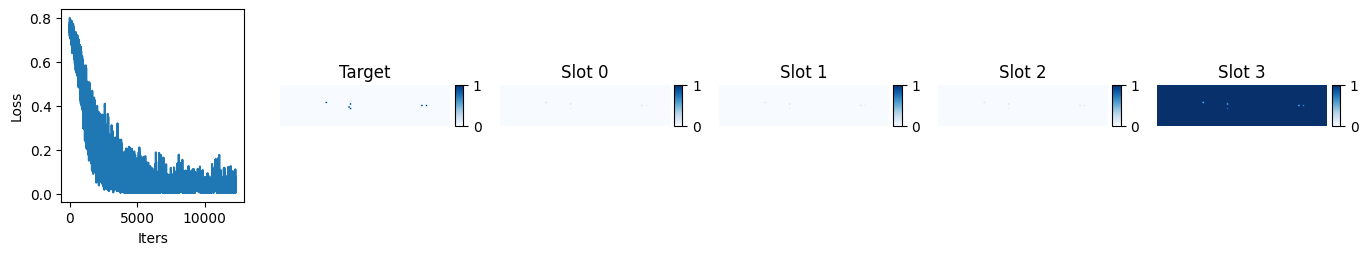

iter 12350 , loss 0.011188471 , lr 0.0002347990459970749


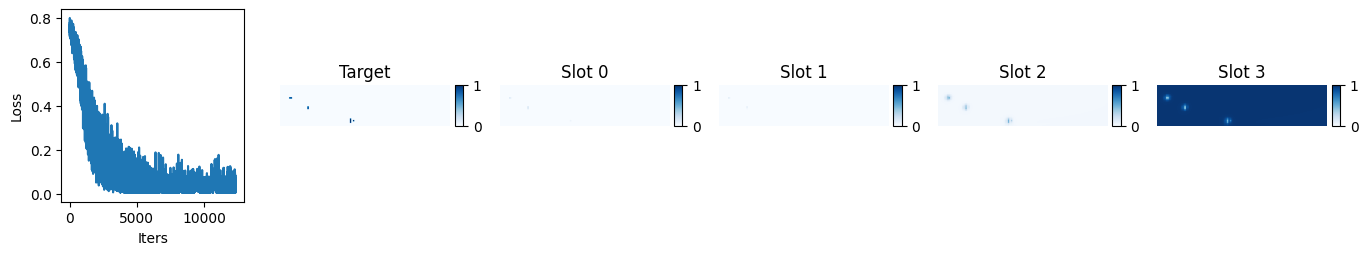

iter 12400 , loss 0.056536496 , lr 0.00023431250667781958


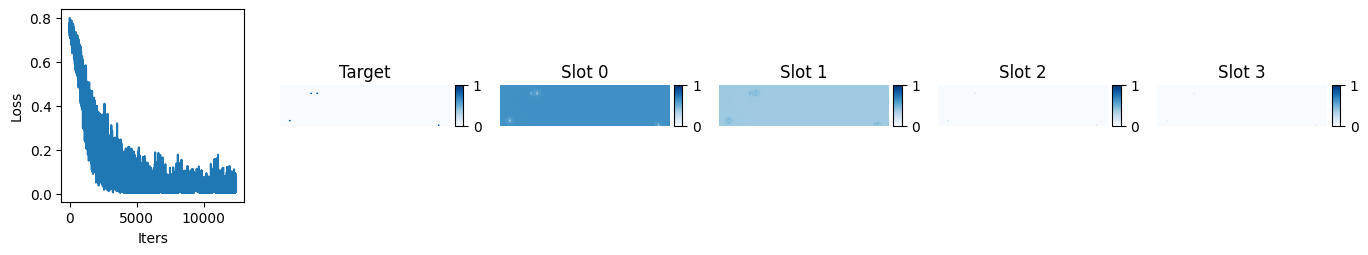

iter 12450 , loss 0.011944452 , lr 0.00023382466715541174


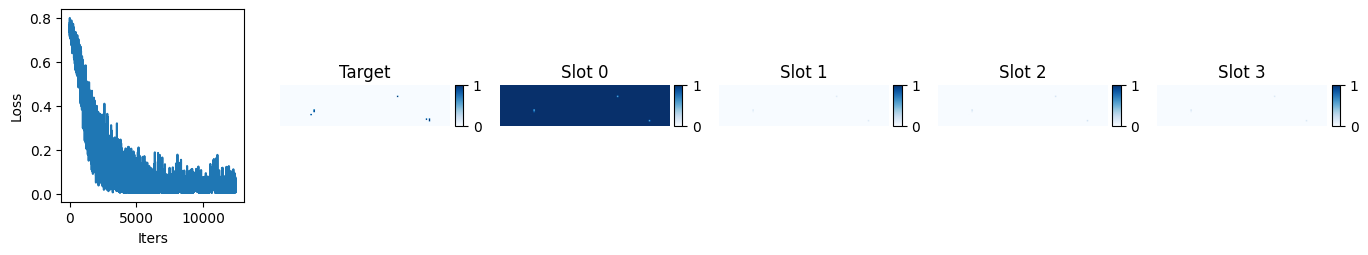

iter 12500 , loss 0.0059809512 , lr 0.00023333553495294033


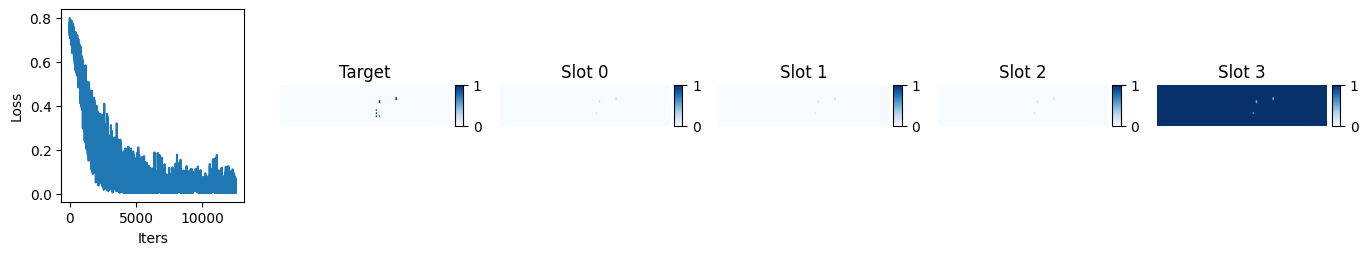

iter 12550 , loss 0.005832549 , lr 0.00023284511761342895


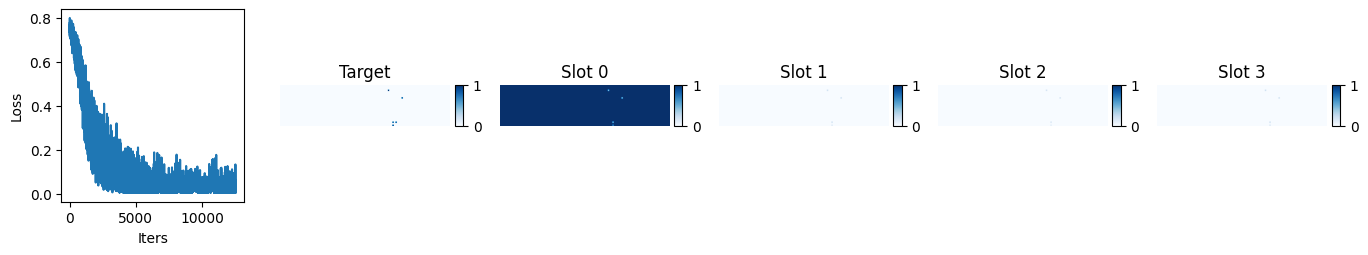

iter 12600 , loss 0.051186007 , lr 0.00023235342269971974


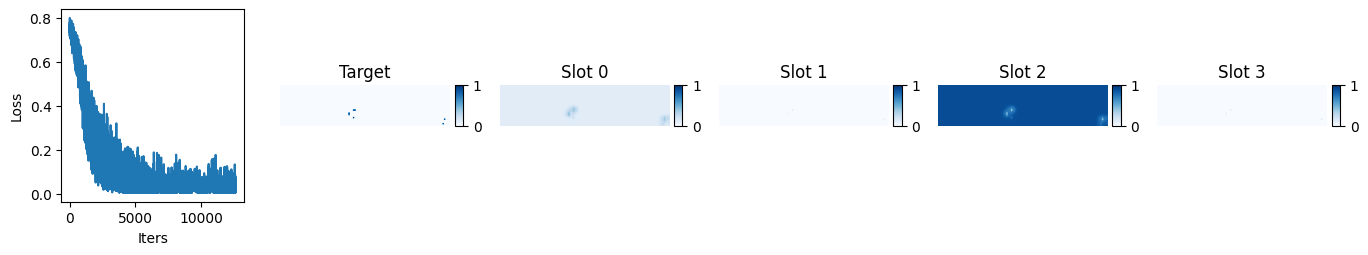

iter 12650 , loss 0.011150858 , lr 0.00023186045779435648


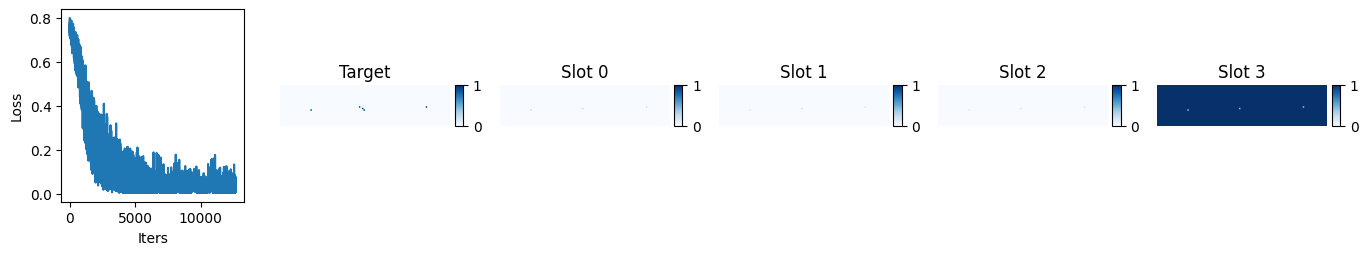

iter 12700 , loss 0.013224757 , lr 0.00023136623049946784


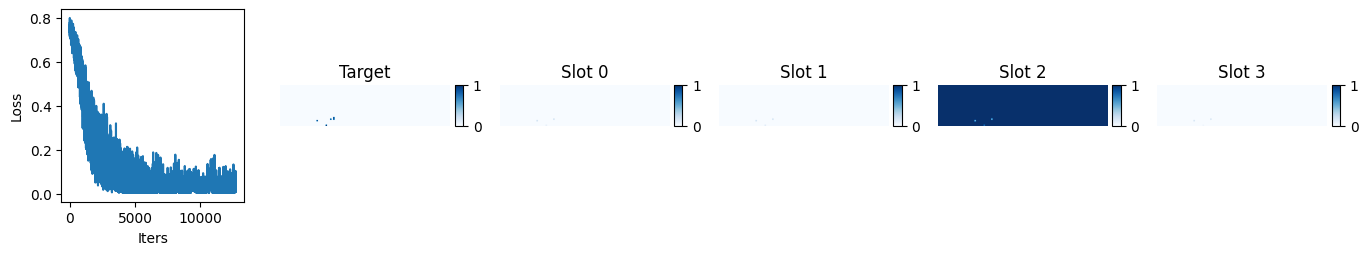

iter 12750 , loss 0.00686202 , lr 0.00023087074843665


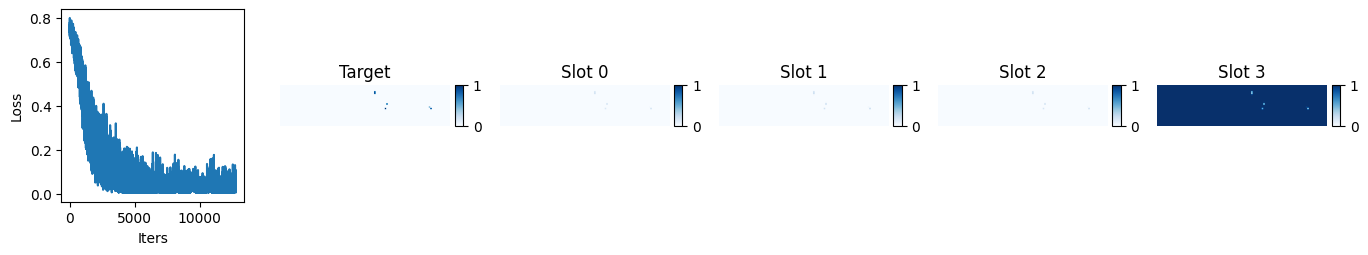

iter 12800 , loss 0.050074674 , lr 0.00023037401924684946


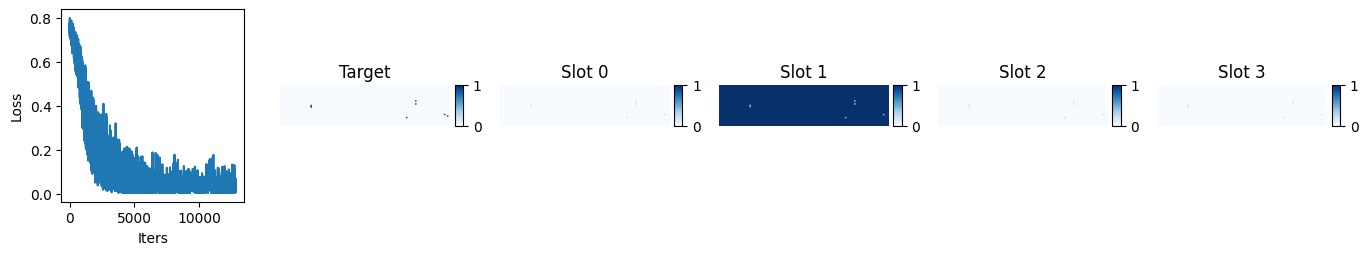

iter 12850 , loss 0.014608587 , lr 0.00022987605059024475


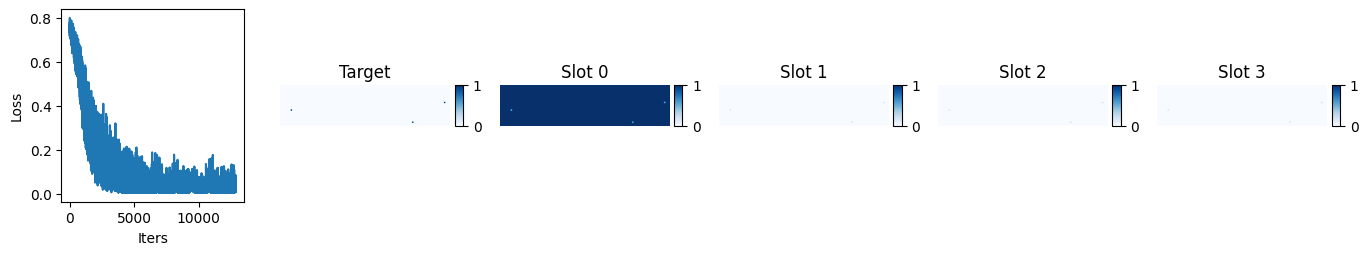

iter 12900 , loss 0.012152474 , lr 0.00022937685014612856


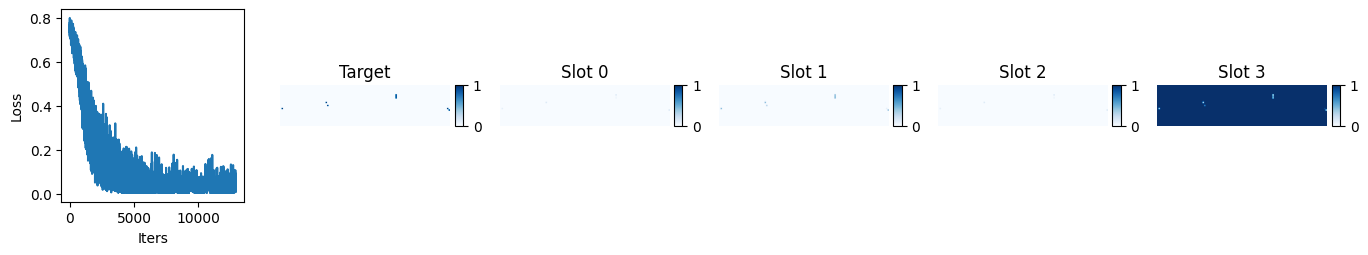

iter 12950 , loss 0.01015803 , lr 0.0002288764256127893


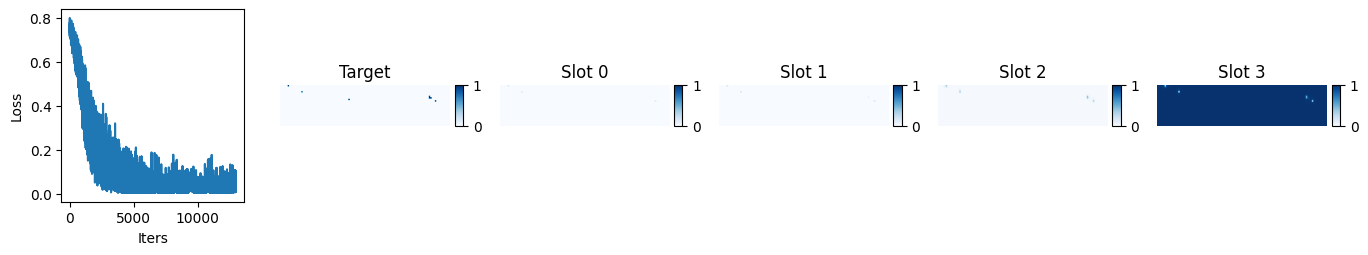

iter 13000 , loss 0.008337272 , lr 0.0002283747847073923


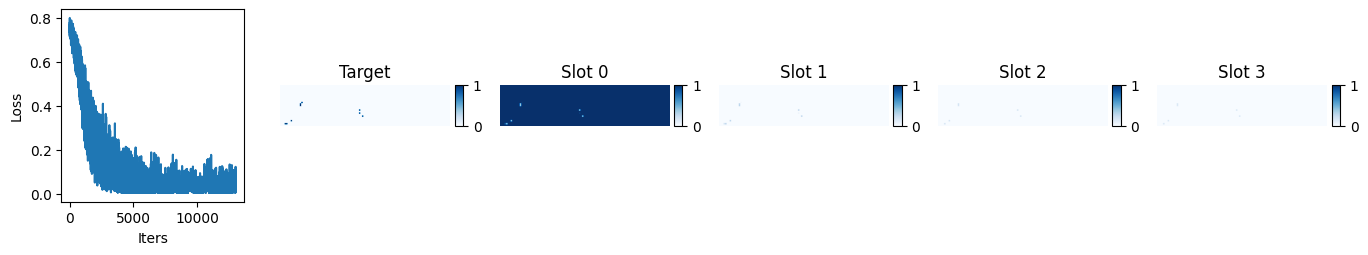

iter 13050 , loss 0.006807128 , lr 0.00022787193516586091


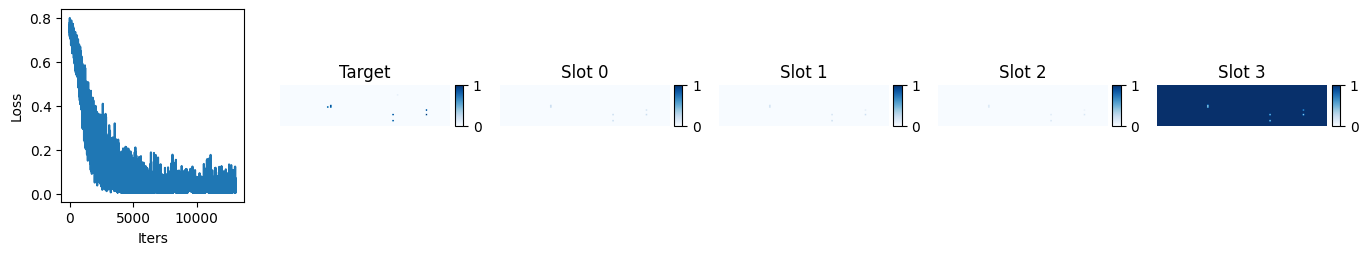

iter 13100 , loss 0.026303202 , lr 0.00022736788474275708


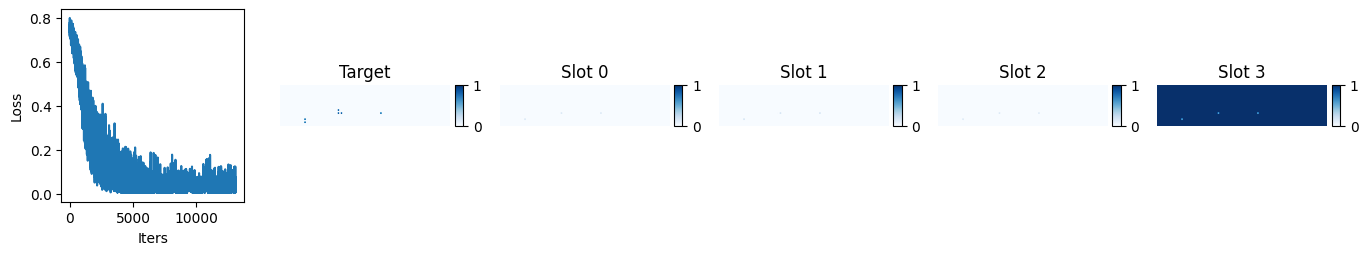

iter 13150 , loss 0.01749128 , lr 0.00022686264121116195


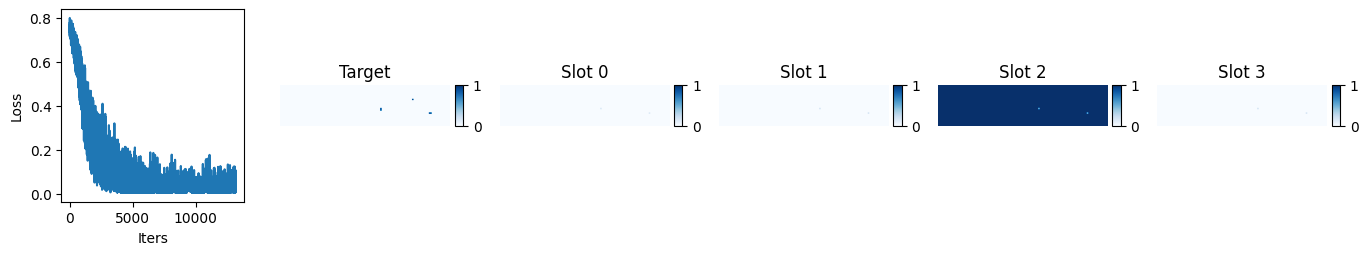

iter 13200 , loss 0.0095478725 , lr 0.00022635621236255567


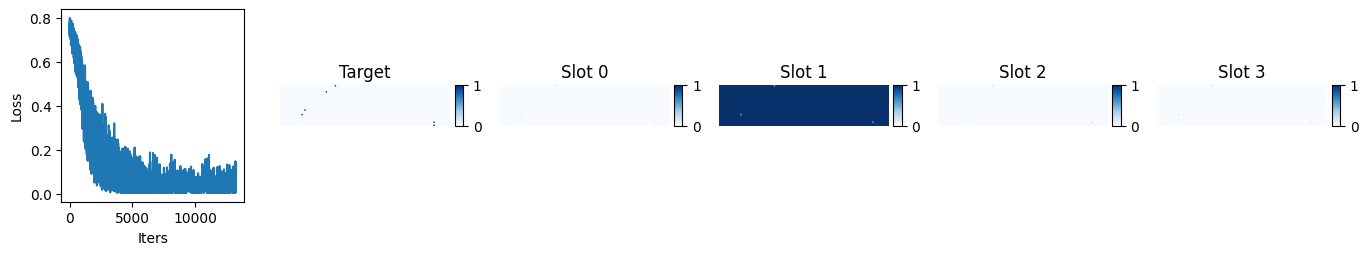

iter 13250 , loss 0.0077164704 , lr 0.00022584860600669766


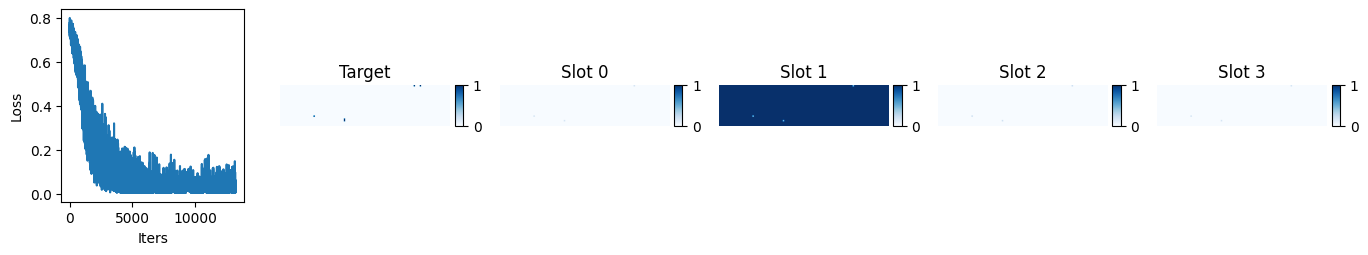

iter 13300 , loss 0.0087778075 , lr 0.00022533982997150585


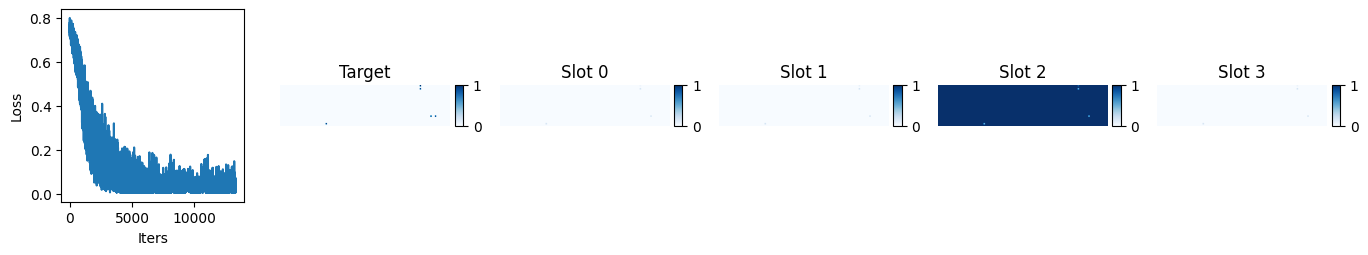

iter 13350 , loss 0.0071788942 , lr 0.0002248298921029361


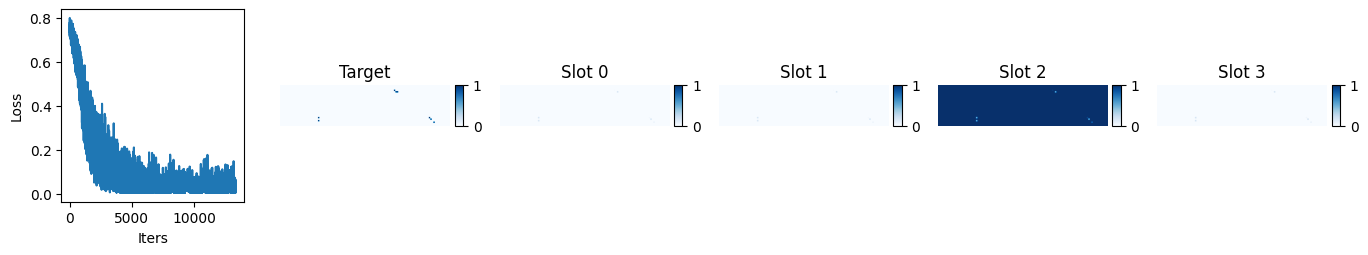

iter 13400 , loss 0.011118996 , lr 0.00022431880026486112


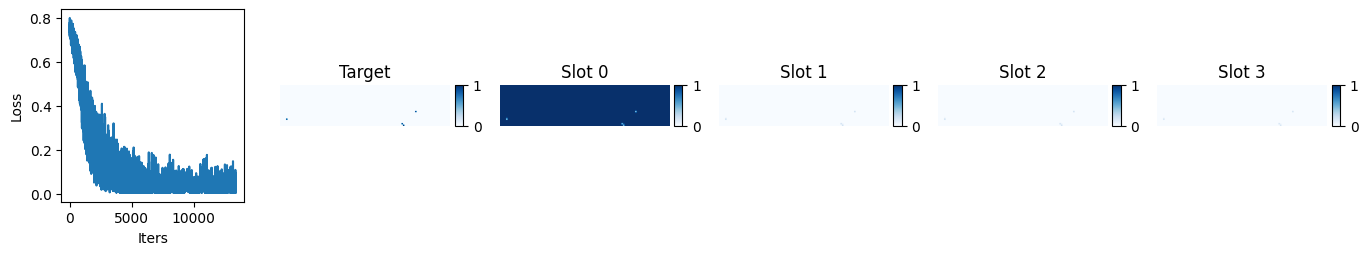

iter 13450 , loss 0.004691013 , lr 0.00022380656233894934


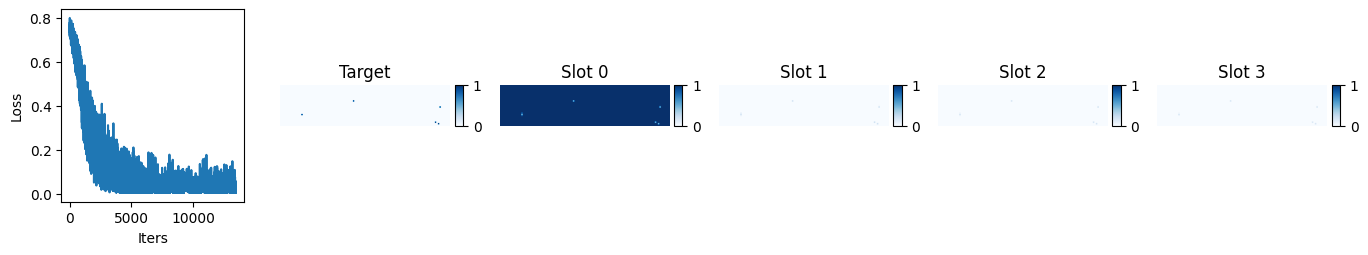

iter 13500 , loss 0.009889583 , lr 0.00022329318622454325


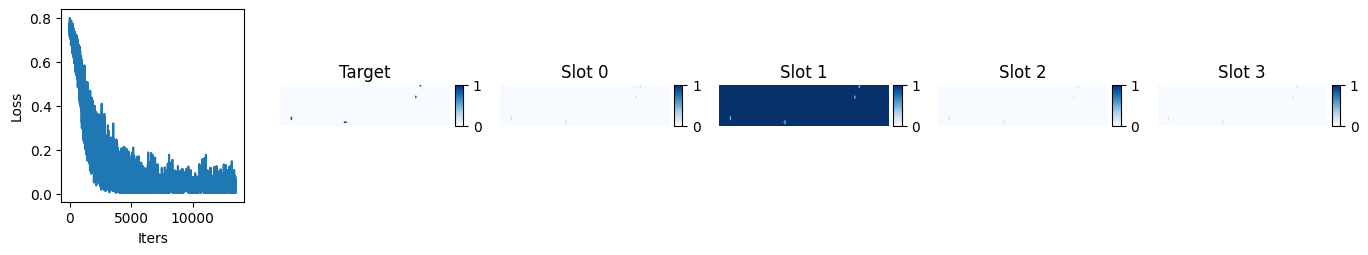

iter 13550 , loss 0.028170025 , lr 0.00022277867983853754


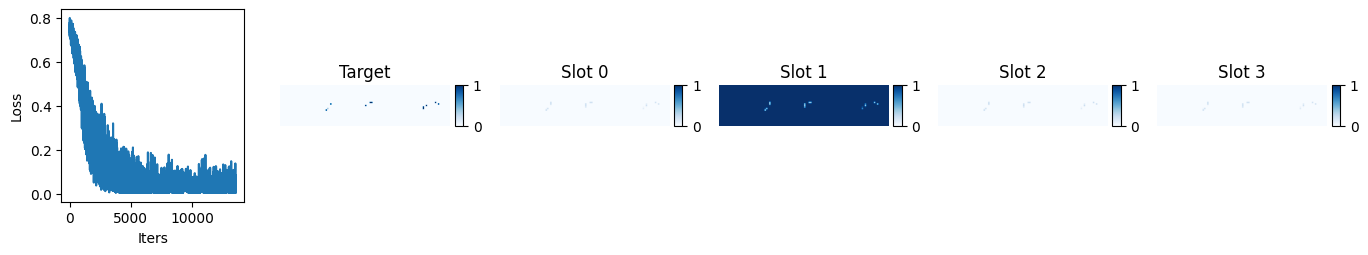

iter 13600 , loss 0.031514198 , lr 0.00022226305111525726


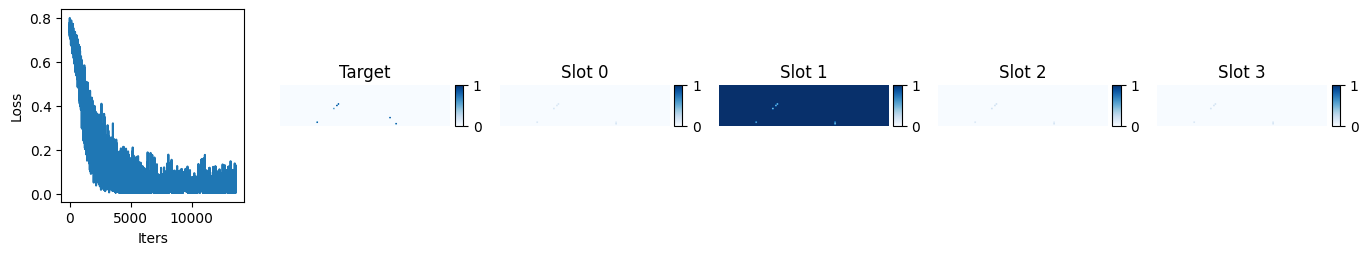

iter 13650 , loss 0.03644051 , lr 0.00022174630800633516


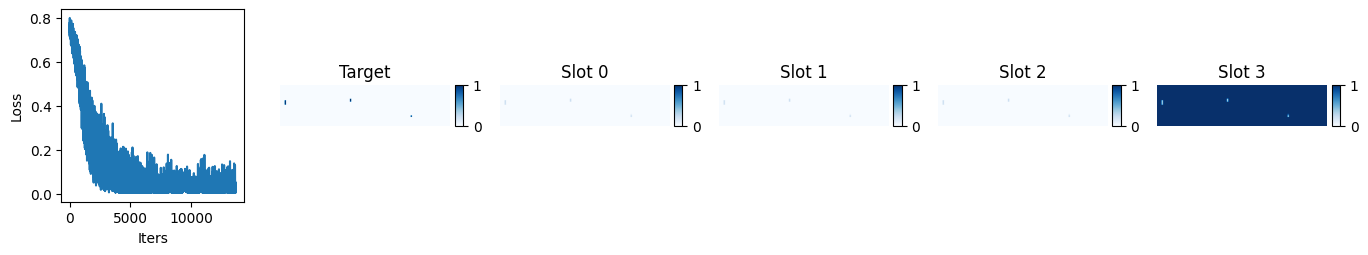

iter 13700 , loss 0.007832942 , lr 0.00022122845848058918


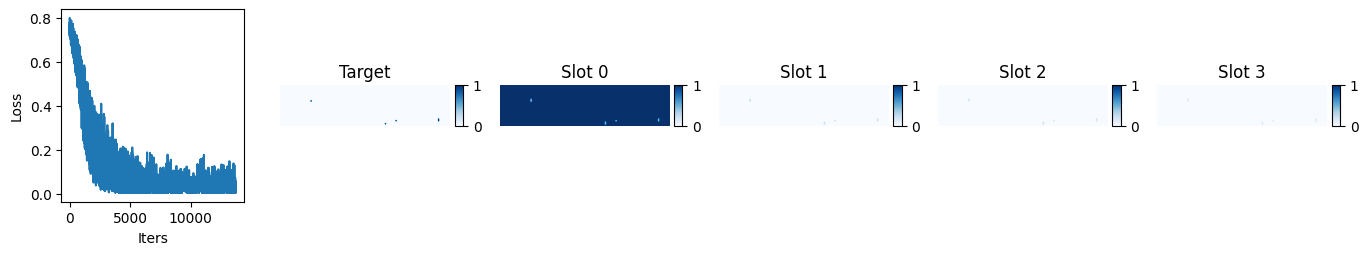

iter 13750 , loss 0.0045562927 , lr 0.00022070951052389966


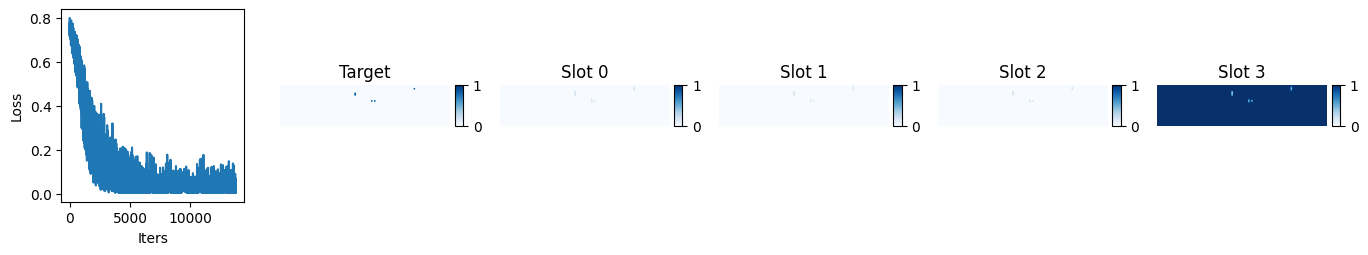

iter 13800 , loss 0.0056978953 , lr 0.000220189472139086


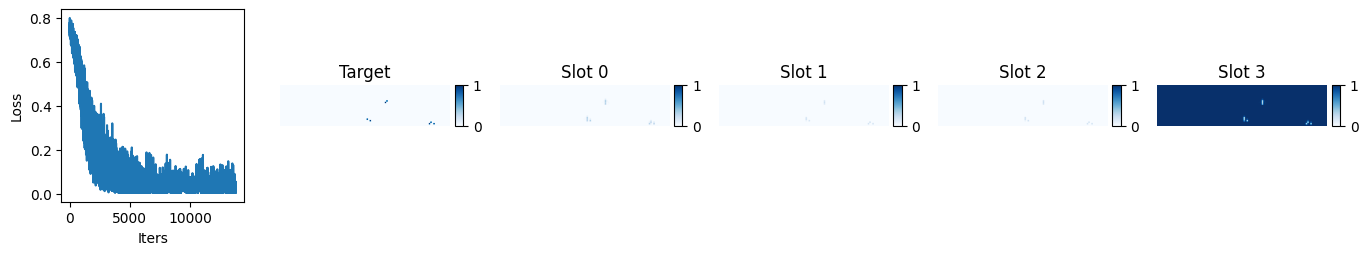

iter 13850 , loss 0.005881483 , lr 0.00021966835134578345


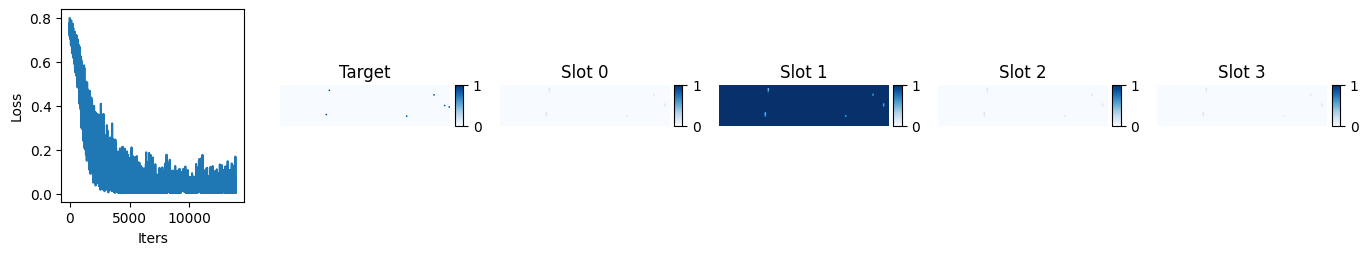

iter 13900 , loss 0.094262965 , lr 0.00021914615618031933


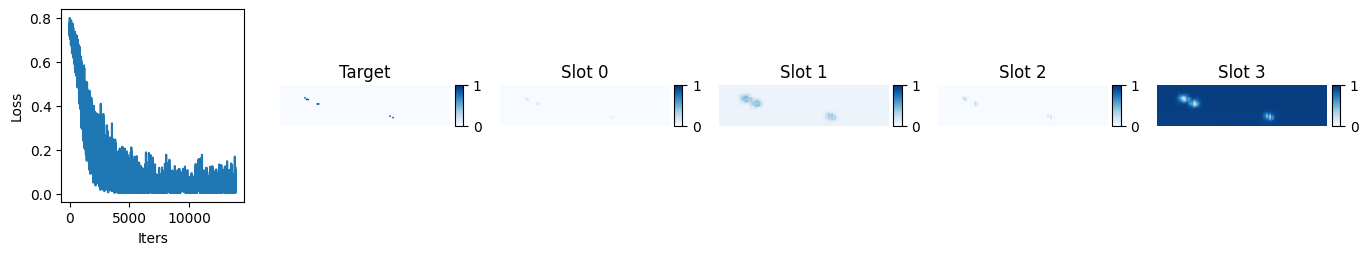

iter 13950 , loss 0.013239029 , lr 0.00021862289469558904


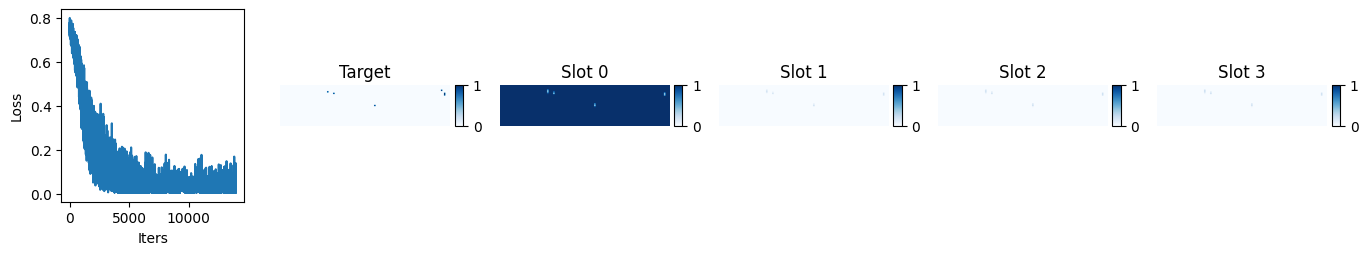

iter 14000 , loss 0.0050588246 , lr 0.00021809857496093199


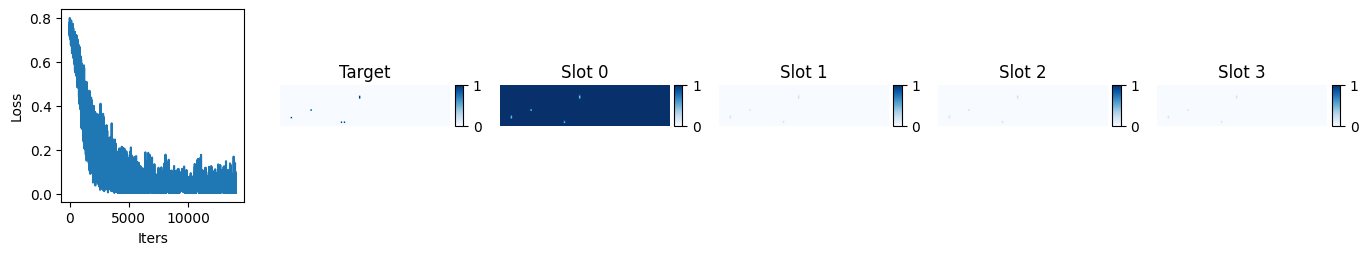

iter 14050 , loss 0.010312246 , lr 0.00021757320506200713


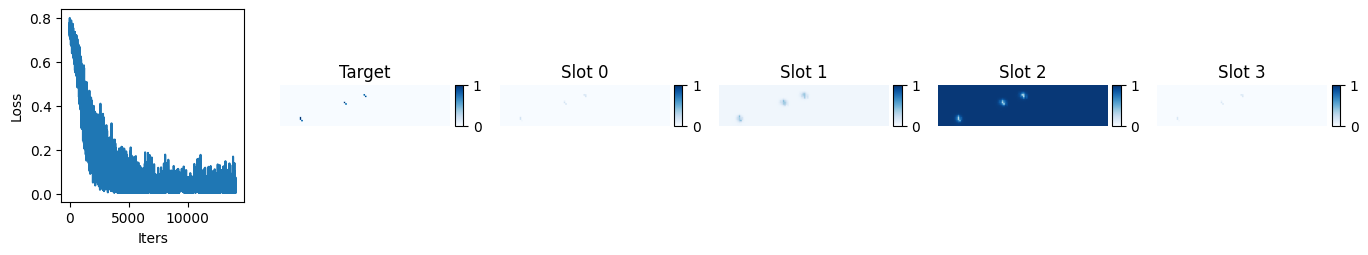

iter 14100 , loss 0.037488796 , lr 0.00021704679310066818


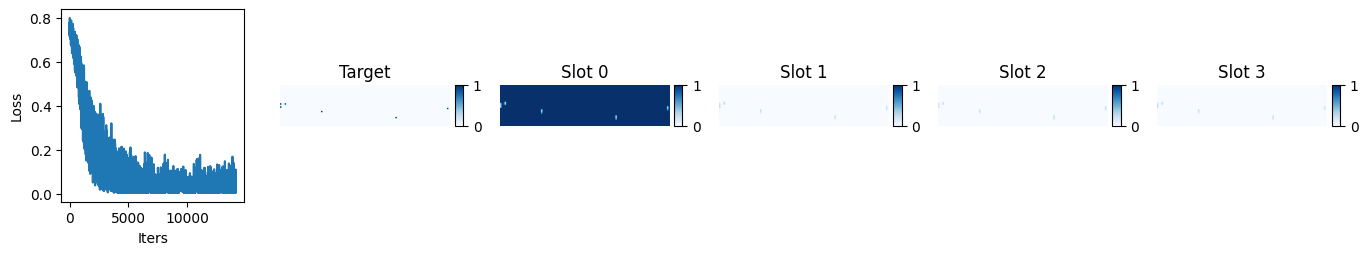

iter 14150 , loss 0.0067601562 , lr 0.00021651934719483875


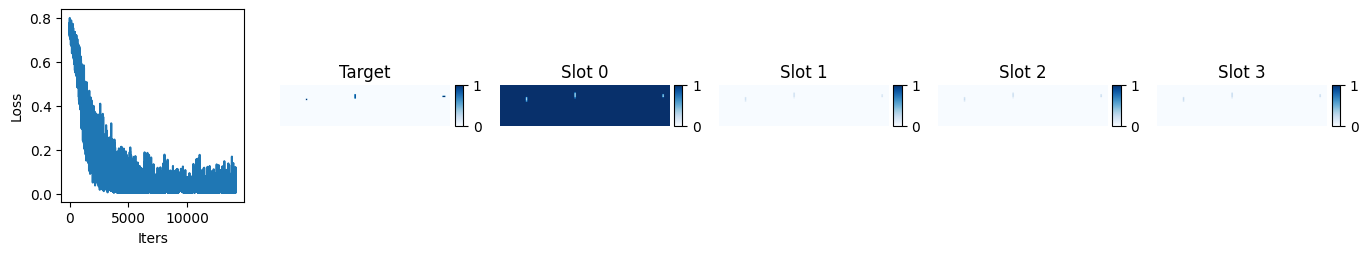

iter 14200 , loss 0.010662128 , lr 0.00021599087547838727


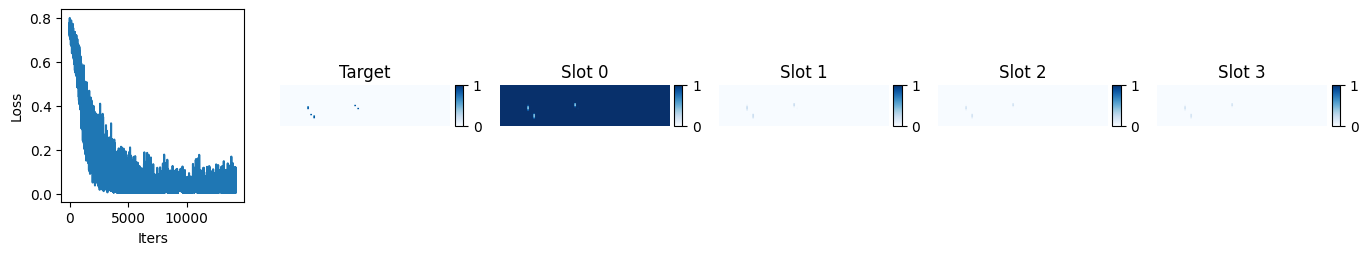

iter 14250 , loss 0.04513181 , lr 0.0002154613861010013


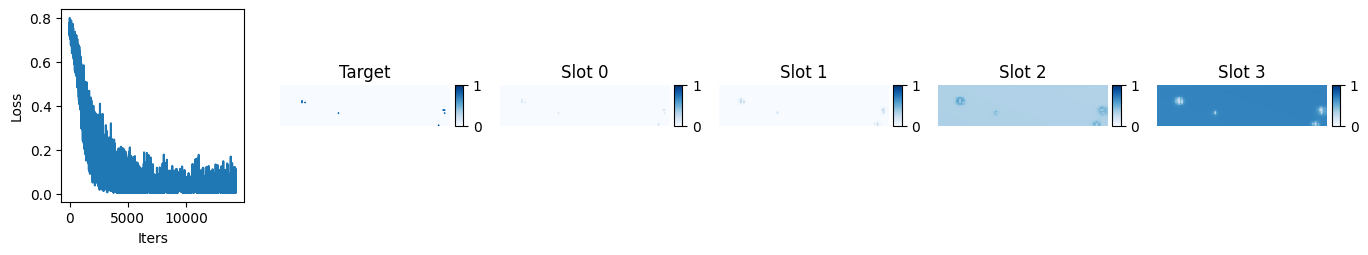

iter 14300 , loss 0.0058665876 , lr 0.00021493088722806207


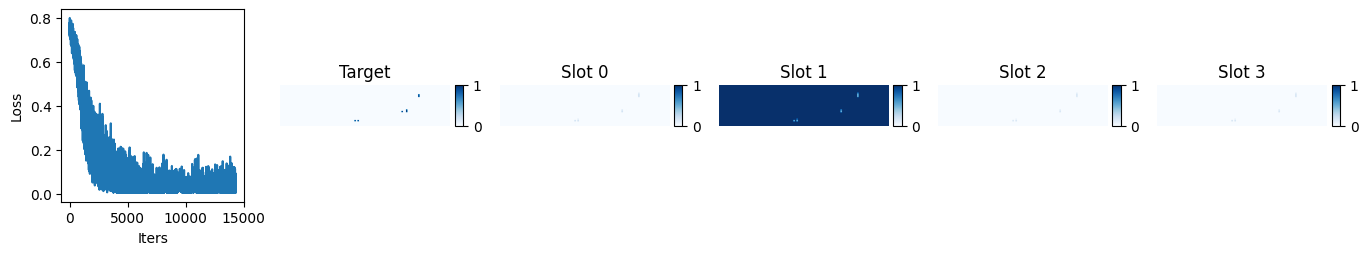

In [ ]:
losses=[]

out = train_ISA(m,Ntrain=40_000,bs=bs,device=device,
                modelDir=modelDir,figDir=figDir,plot_every=50)

In [ ]:
model, X,Y,mask, init_q, init_pos = out

In [ ]:
queries, pos_scale, att, wts = model(X)

In [ ]:
att[4]

**Ideas:**
1. I could see if an L2 regularization would help
- Plot the min and max of the model parameters over time
2. Would gradient clipping help?
- I feel like it seems more sus smth else in the opt pipeline rn

In [ ]:
encoded_data

In [ ]:
i_fail = 0

In [ ]:
encoded_data = model.CNN_encoder(X) # Apply the CNN encoder
encoded_data = torch.permute(encoded_data,(0,2,3,1)) # Put channel dim at the end
encoded_data = torch.flatten(encoded_data,1,2) # flatten pixel dims
encoded_data = model.dataN(encoded_data)

# Use the init Q from the failure mode
queries = copy(init_q)
pos_scale = copy(init_pos)

'''
Step 3: Iterate through the reconstruction
'''
for i in range(model.n_iter):
    # queries, pos_scale = model.iterate(queries, pos_scale, encoded_data)    

    print('t=',i)
    
    # Get the keys and values in the ref ref frame
    keys, vals = model.get_keys_vals(encoded_data,pos_scale)

    print('keys',keys[i_fail].isnan().sum().item(),f'max {keys[i_fail].max().item():.2f},min {keys[i_fail].min().item():.2f}')
    print('vals',vals[i_fail].isnan().sum().item(),f'max {vals[i_fail].max().item():.2f},min {vals[i_fail].min().item():.2f}')
    
    # att,wts: (bs, k_slots, img_dim)
    att,wts = model.attention_and_weights(model.queryN(queries),keys)   

    print('att',att[i_fail].isnan().sum().item(),f'max {att[i_fail].max().item():.2f},min {att[i_fail].min().item():.2f}')
    print('wts',wts[i_fail].isnan().sum().item(),f'max {wts[i_fail].max().item():.2f},min {wts[i_fail].min().item():.2f}')

    new_pos_scale = model.update_frames(wts)

    # Update the queries with the recurrent block
    updates = torch.einsum('bsd,bsde->bse',wts,vals) # bs, n_slots, query_dim

    updates = model.gru(
        updates.reshape(-1,model.query_dim),
        queries.reshape(-1,model.query_dim),
    )

    queries,pos_scale = updates.reshape(queries.shape), new_pos_scale
    
    
    print(i,queries[i_fail],pos_scale[i_fail])
    
    break
    
    
# # With the final query vector, calc the attn, weights, + rel ref frames
# keys, vals = model.get_keys_vals(encoded_data,pos_scale)
# att, wts = model.attention_and_weights(model.queryN(queries),keys)   
# new_pos_scale = model.update_frames(wts)

In [ ]:
X2, Y2, mask2 = make_batch(N_events=2,device=device, **{'isRing': True, 'N_clusters':2})
        

In [ ]:
# m_cpu = model.to(device)

In [ ]:
model(X2)

In [ ]:
plt.hist(encoded_data.flatten().detach().cpu().numpy())

In [ ]:
# Get the relative position embedding
rel_grid = model.abs_grid.unsqueeze(1) - init_pos[:,:,:2].unsqueeze(2)
rel_grid /= init_pos[:,:,-1].unsqueeze(2).unsqueeze(-1)

# Embed it in the same space as the query dimension 
embed_grid = model.pixel_mult * model.dense( rel_grid )

# keys, vals: (bs, img_dim, query_dim)
k0 = model.toK(encoded_data).unsqueeze(1) + embed_grid
v0 = model.toV(encoded_data).unsqueeze(1) + embed_grid

k0 = model.init_mlp(k0)
v0 = model.init_mlp(v0)

In [ ]:
nb=100
r=(-5,5)
plt.hist(k0.flatten().detach().cpu().numpy(),nb,r,label='keys',
         color='g',histtype='step',lw=2)
plt.hist(v0.flatten().detach().cpu().numpy(),nb,r,label='values',
         color='b',histtype='step',lw=2)

plt.xlabel('features')
plt.ylabel('entries')
plt.legend()
plt.show()

In [ ]:
nb=100
r=(-5,5)
plt.hist(k0[i_fail].flatten().detach().cpu().numpy(),nb,r,label='keys',
         color='g',histtype='step',lw=2)
plt.hist(v0[i_fail].flatten().detach().cpu().numpy(),nb,r,label='values',
         color='b',histtype='step',lw=2)

plt.xlabel('features')
plt.ylabel('entries')
plt.title(f'Event {i_fail} (evt with nans)')
plt.legend()
plt.show()

In [ ]:
k0[i_fail].shape

In [ ]:
k0[i_fail][abs(k0[i_fail])>100]

In [ ]:
v0[i_fail][abs(v0[i_fail])>100]

In [ ]:
for p in model.parameters():
    print(p.shape,p)
    # plt.hist(p.detach().cpu().numpy(),histtype='step')

In [ ]:
losses

In [ ]:
att.isnan().sum()

In [ ]:
for i, att_i in enumerate(att):
    if att_i.isnan().sum() > 0:
        print(i)

In [ ]:
i_fail = 23

In [ ]:
init_q[i_fail]

In [ ]:
init_pos[i_fail]

In [ ]:
np.prod(att.shape)

In [ ]:
init_q

In [ ]:
init_pos

In [ ]:
copy(att)

In [ ]:
att.shape

In [ ]:
m,losses = out

In [ ]:
model, X,Y,mask = out

In [ ]:
queries, pos_scale, att, wts = m(X)
        
print( torch.isnan(att).sum() >0 )

In [ ]:
losses

In [ ]:
# att_img = att[iEvt].reshape(model.k_slots,*resolution)
# plot_kslots(losses, 
#             mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
#             att_img.detach().cpu().numpy(),
#             k_slots, color=color,cmap=cmap,
#             figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg)
